In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
from sklearn.metrics import confusion_matrix

import os
import pandas as pd
import time
import warnings
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

import re
import librosa
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")

warnings.filterwarnings('ignore')

Using device: cuda


In [111]:
# Scale data based on the overall dataset
# complete_features = pd.read_csv("/home/distasiom/Documents/Summer2024/data/complete_dataset.csv")
# complete_features = complete_features.iloc[:,2:]
# scaler = StandardScaler()
# minmax = MinMaxScaler()
# robust = RobustScaler()
# scaler.fit(complete_features)
# minmax.fit(complete_features)
# robust.fit(complete_features)

# dump(scaler, 'StandardScaler.joblib')
# dump(minmax, 'MinMaxScaler.joblib')
# dump(robust, 'RobustScaler.joblib')

['RobustScaler.joblib']

In [112]:
# Scale spectrograms in batchs based on the overall dataset
# directory = "/home/distasiom/Documents/Summer2024/complete_dataset_spectrograms"
# means = []
# variances = []
# medians = []
# iqr_list = []
# min_vals = []
# max_vals = []
# batch_size = 1000

# all_filenames = [filename for filename in os.listdir(directory) if filename.endswith('.pt')]


# for filename in tqdm(all_filenames):
#     file_path = os.path.join(directory, filename)
#     tensor = torch.load(file_path)
#     data = tensor.numpy().flatten()
#     data[np.isnan(data)] = 0 
    
#     # Batch processing
#     for i in range(0, len(data), batch_size):
#         batch = data[i:i + batch_size]
#         means.append(np.mean(batch))
#         variances.append(np.var(batch))
#         medians.append(np.median(batch))
#         q75, q25 = np.percentile(batch, [75, 25])
#         iqr_list.append(q75 - q25)
#         min_vals.append(np.min(batch))
#         max_vals.append(np.max(batch))

# # Aggregate statistics
# mean = np.mean(means)
# scale_std = np.sqrt(np.mean(variances))
# median = np.median(medians)
# iqr = np.median(iqr_list)
# min_val = np.min(min_vals)
# max_val = np.max(max_vals)

# scalerSpect = StandardScaler()
# scalerSpect.mean_ = np.array([mean])
# scalerSpect.scale_ = np.array([scale_std])

# robustSpect = RobustScaler()
# robustSpect.center_ = np.array([median])
# robustSpect.scale_ = np.array([iqr])

# minmaxSpect = MinMaxScaler()
# minmaxSpect.min_ = np.array([min_val])
# minmaxSpect.scale_ = np.array([1/(max_val - min_val)])


# dump(scalerSpect, 'StandardScalerSpect.joblib')
# dump(minmaxSpect, 'MinMaxScalerSpect.joblib')
# dump(robustSpect, 'RobustScalerSpect.joblib')

 48%|████▊     | 9275/19256 [05:41<06:19, 26.30it/s]

In [ ]:
# scalerSpect = load("./StandardScalerSpect.joblib")
# print(scalerSpect.mean_, scalerSpect.scale_)

[-0.39753428] [0.21884337]


In [2]:

class AnechoicDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.spectrograms = spectrogram_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = {
            'Drone': 0,
            'No Drone': 1
        }

#         self.scaler = load("./StandardScaler.joblib")
#         self.robust = load("./RobustScaler.joblib")
#         self.minmax = load("./MinMaxScaler.joblib")
#         self.scalerSpect = load("./StandardScalerSpect.joblib")
#         self.robustSpect = load("./RobustScalerSpect.joblib")
#         self.minmaxSpect = load("./MinMaxScalerSpect.joblib")


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = torch.FloatTensor(self.df.iloc[idx, 2:])
#         features = features.unsqueeze(dim=0)
#         features = self.scaler.transform(features)
#         features = self.minmax.transform(features)
#         features = self.robust.transform(features)
#         features = features.squeeze()

        
        spectrogram_filename = f"{self.df.iloc[idx, 0].split('/')[-1][0:-4]}_spectrogram.pt"
        spectrogram_path = os.path.join(self.spectrograms, spectrogram_filename)
        spectrogram = torch.load(spectrogram_path)
        spectrogram = torch.nan_to_num(spectrogram)
#         spectrogram = np.array(spectrogram)
#         spectrogram_flat = spectrogram.reshape(-1, spectrogram.shape[-1])
#         spectrogram_flat = self.scalerSpect.transform(spectrogram_flat)
#         spectrogram_flat = self.robustSpect.transform(spectrogram_flat)
#         spectrogram_flat = self.minmaxSpect.transform(spectrogram_flat)
#         spectrogram = spectrogram_flat.reshape(spectrogram.shape)
#         spectrogram = torch.nan_to_num(torch.from_numpy(spectrogram))

        label = self.df.iloc[idx, 1]
        
        if self.target_transform:
            label = self.target_transform(label)
        

        return torch.FloatTensor(spectrogram), torch.FloatTensor(features), torch.tensor(label)
    

# Usage example
csv_file = "/home/distasiom/Documents/Summer2024/data/complete_dataset_features.csv"
spectrogram_dir = "/home/distasiom/Documents/Summer2024/data/complete_dataset_spectrograms"

# Define any transformations if needed
transform = None
target_transform = None

combined_dataset = AnechoicDataset(csv_file, spectrogram_dir, transform=transform, target_transform=target_transform)

In [31]:
class EscapeDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.spectrograms = spectrogram_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = {
            'Drone': 0,
            'No Drone': 1
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Dataset has no label
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = torch.FloatTensor(self.df.iloc[idx, 1:])
        filename = self.df.iloc[idx, 0][0:-4]
        spectrogram_filename = f"{self.df.iloc[idx, 0].split('/')[-1][0:-4]}_spectrogram.pt"
        spectrogram_path = os.path.join(self.spectrograms, spectrogram_filename)
        spectrogram = torch.load(spectrogram_path)
        spectrogram = torch.nan_to_num(spectrogram)
        
        return filename, torch.tensor(spectrogram), torch.tensor(features)

# Usage example
csv_file = "/home/distasiom/Documents/Summer2024/data/ESCAPEII_DADS_only_features.csv"
spectrogram_dir = "/home/distasiom/Documents/Summer2024/data/ESCAPEII_DADS_only_spectrograms"

# Define any transformations if needed
transform = None
target_transform = None

escape_dataset = EscapeDataset(csv_file, spectrogram_dir, transform=transform, target_transform=target_transform)
escape_loader = DataLoader(
    escape_dataset,
    batch_size=64,
    shuffle=False
)

In [3]:
train_size = int(.8 * len(combined_dataset))
test_size = int(.75 * (len(combined_dataset) - train_size))
val_size = len(combined_dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size, val_size])
print(train_dataset)
print(train_dataset[0])

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

(tensor([[[ 0.4763,  0.5931,  0.8322,  ...,  0.5911,  0.3445,  0.5752],
         [ 0.7459,  0.8969,  0.9789,  ...,  0.7534,  0.7150,  0.5919],
         [ 0.8254,  0.9739,  1.0000,  ...,  0.7414,  0.6955,  0.5635],
         ...,
         [-0.8654, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9691],
         [-0.8654, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9692],
         [-0.8655, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9692]]]), tensor([ -86.6671, -129.8180, -205.2355,  ...,    1.3882,    1.3882,
           1.3882]), tensor(1))


In [7]:
for spectrogram, feature, label in train_loader:
    if spectrogram.mean() != 0:
        print(spectrogram)

tensor([[[[-0.5835,  0.1948,  0.4152,  ...,  0.5338,  0.5743,  0.6809],
          [ 0.4927,  0.5393,  0.6172,  ...,  0.6799,  0.5781,  0.7770],
          [ 0.7410,  0.8774,  0.9468,  ...,  0.8340,  0.9325,  0.8650],
          ...,
          [-0.5448, -0.6946, -1.0000,  ..., -1.0000, -1.0000, -0.9133],
          [-0.5454, -0.6983, -1.0000,  ..., -1.0000, -1.0000, -0.9254],
          [-0.5456, -0.6959, -1.0000,  ..., -1.0000, -1.0000, -0.9362]]],


        [[[ 0.5175,  0.6821,  0.7342,  ...,  0.4578,  0.6798,  0.5303],
          [ 0.4715,  0.5652,  0.5954,  ...,  0.6190,  0.6336,  0.5044],
          [ 0.3490,  0.0816,  0.2704,  ...,  0.4316,  0.4463,  0.4110],
          ...,
          [-0.7248, -0.8742, -1.0000,  ..., -1.0000, -0.8557, -0.6586],
          [-0.7263, -0.8777, -1.0000,  ..., -1.0000, -0.8598, -0.6594],
          [-0.7273, -0.8822, -1.0000,  ..., -1.0000, -0.8574, -0.6597]]],


        [[[ 0.7609,  0.9579,  0.9261,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.7249,  0.889

tensor([[[[ 0.7132,  0.5247,  0.1822,  ...,  0.4748,  0.2688, -0.1691],
          [ 0.8059,  0.6555,  0.5275,  ...,  0.6544,  0.4812,  0.1116],
          [ 0.8876,  0.9429,  0.9041,  ...,  0.7904,  0.5710,  0.1078],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6707, -0.4731],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6724, -0.4732],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6699, -0.4731]]],


        [[[ 0.4637,  0.6162,  0.6038,  ...,  0.5398,  0.4720,  0.3140],
          [ 0.4128,  0.5269,  0.4983,  ...,  0.3789,  0.3847,  0.2314],
          [ 0.2344,  0.2171,  0.1450,  ...,  0.2507,  0.3462,  0.2630],
          ...,
          [ 0.0243, -0.0549, -0.0442,  ...,  0.0267,  0.1782, -0.0057],
          [ 0.1620,  0.2233,  0.1250,  ...,  0.1127,  0.2430,  0.1086],
          [ 0.2038,  0.2963,  0.1629,  ...,  0.1309,  0.2736,  0.1547]]],


        [[[ 0.7353,  0.6875,  0.5638,  ...,  0.6925,  0.8483,  0.8497],
          [ 0.7253,  0.579

tensor([[[[ 0.4416,  0.6388,  0.5620,  ...,  0.7131,  0.6643,  0.7114],
          [ 0.6036,  0.7693,  0.8925,  ...,  0.8561,  0.8062,  0.6402],
          [ 0.6414,  0.7877,  0.8364,  ...,  0.8390,  0.8237,  0.3836],
          ...,
          [-0.7122, -0.8651, -1.0000,  ..., -1.0000, -0.9062, -0.7077],
          [-0.7123, -0.8651, -1.0000,  ..., -1.0000, -0.9066, -0.7077],
          [-0.7123, -0.8654, -1.0000,  ..., -1.0000, -0.9061, -0.7077]]],


        [[[ 0.4211,  0.5134,  0.4758,  ...,  0.2928,  0.2374,  0.0573],
          [ 0.3894,  0.3988,  0.3258,  ...,  0.1311,  0.1178,  0.0186],
          [ 0.3667, -0.0011,  0.0429,  ..., -0.2561, -0.1405, -0.1305],
          ...,
          [-0.8635, -1.0000, -1.0000,  ..., -1.0000, -0.6625, -0.4652],
          [-0.8636, -1.0000, -1.0000,  ..., -1.0000, -0.6625, -0.4652],
          [-0.8636, -1.0000, -1.0000,  ..., -1.0000, -0.6625, -0.4652]]],


        [[[ 0.8483,  0.7989, -0.1874,  ..., -0.0026,  0.4002,  0.2587],
          [ 0.8457,  0.901

tensor([[[[-6.1118e-01,  4.9136e-01,  7.1314e-01,  ..., -3.4619e-01,
            5.3342e-01,  7.1723e-01],
          [ 6.6983e-01,  7.7174e-01,  8.4204e-01,  ...,  6.4094e-01,
            7.1584e-01,  7.6029e-01],
          [ 7.9596e-01,  9.3070e-01,  9.3161e-01,  ...,  8.6236e-01,
            8.6405e-01,  7.7371e-01],
          ...,
          [-7.1884e-01, -8.7155e-01, -1.0000e+00,  ..., -1.0000e+00,
           -8.1928e-01, -6.2191e-01],
          [-7.1891e-01, -8.7141e-01, -1.0000e+00,  ..., -1.0000e+00,
           -8.1874e-01, -6.2171e-01],
          [-7.1897e-01, -8.7190e-01, -1.0000e+00,  ..., -1.0000e+00,
           -8.1828e-01, -6.2160e-01]]],


        [[[ 3.2288e-01,  2.9593e-01, -2.1516e-01,  ...,  4.7334e-01,
            3.9180e-01,  2.3970e-01],
          [ 4.0816e-01,  1.9951e-01,  1.3327e-01,  ...,  2.7030e-01,
            4.5322e-01,  2.2733e-01],
          [ 5.0957e-01,  6.0564e-01,  6.4310e-01,  ...,  5.9909e-01,
            5.8215e-01,  3.8615e-01],
          ...,
   

tensor([[[[ 0.4828, -0.1318, -0.1149,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.6496,  0.5680,  0.4049,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.7353,  0.7639,  0.6980,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.7614, -0.9143, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7614, -0.9143, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7614, -0.9143, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3266,  0.4377,  0.4728,  ...,  0.4409,  0.3238,  0.1020],
          [ 0.3674,  0.2421,  0.5224,  ...,  0.3399,  0.2490, -0.0503],
          [ 0.4081,  0.5458,  0.6061,  ...,  0.1745,  0.1974,  0.0899],
          ...,
          [ 0.6206,  0.5215, -0.1044,  ..., -0.0546,  0.5222,  0.6261],
          [ 0.4243,  0.3811,  0.0217,  ..., -0.0878,  0.3878,  0.4183],
          [ 0.3600,  0.2896, -0.3431,  ..., -0.0692,  0.2769,  0.3430]]],


        [[[-0.7655, -0.3339, -0.5674,  ..., -0.3637, -0.2969, -0.0616],
          [-0.1698, -0.043

tensor([[[[-0.1766, -0.0647, -0.0440,  ...,  0.4569,  0.4190,  0.3260],
          [ 0.0725,  0.0493, -0.4258,  ...,  0.3692,  0.1926,  0.2939],
          [ 0.2250,  0.0361,  0.0082,  ...,  0.2572,  0.2481,  0.2502],
          ...,
          [-0.4903, -0.6350, -1.0000,  ..., -0.2754, -0.2122, -0.2524],
          [-0.4901, -0.6346, -1.0000,  ..., -0.2782, -0.2536, -0.3034],
          [-0.4903, -0.6349, -1.0000,  ..., -0.2830, -0.1556, -0.2049]]],


        [[[ 0.0549,  0.4972,  0.6613,  ...,  0.7724,  0.7227,  0.5700],
          [ 0.1817,  0.4563,  0.5533,  ...,  0.6638,  0.5877,  0.5091],
          [ 0.3070,  0.2933,  0.3140,  ...,  0.4560,  0.0877,  0.2571],
          ...,
          [ 0.3451,  0.1885, -0.0507,  ...,  0.2343,  0.2013,  0.2602],
          [ 0.2487,  0.2016,  0.0236,  ...,  0.0665, -0.0065,  0.0630],
          [ 0.1381,  0.0104,  0.1160,  ...,  0.0290, -0.2361,  0.0603]]],


        [[[ 0.8626,  0.9722,  0.6885,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8272,  0.932

tensor([[[[-0.1645,  0.4956,  0.6721,  ...,  0.5489,  0.4911,  0.5873],
          [ 0.2949,  0.5681,  0.5562,  ...,  0.6219,  0.6177,  0.4960],
          [ 0.5272,  0.6850,  0.6393,  ...,  0.6610,  0.6219,  0.2733],
          ...,
          [-0.6748, -0.8273, -1.0000,  ..., -1.0000, -0.9393, -0.7454],
          [-0.6742, -0.8208, -1.0000,  ..., -1.0000, -0.9474, -0.7489],
          [-0.6746, -0.8302, -1.0000,  ..., -1.0000, -0.9611, -0.7515]]],


        [[[ 0.4475,  0.6664,  0.7910,  ...,  0.7168,  0.6060,  0.4125],
          [ 0.3547,  0.5528,  0.6843,  ...,  0.5829,  0.4723,  0.3564],
          [ 0.1359,  0.3888,  0.2509,  ...,  0.4277,  0.4347,  0.3317],
          ...,
          [-0.5266, -0.6007, -0.5096,  ..., -1.0000, -0.4878, -0.3373],
          [-0.4438, -0.4691, -0.6121,  ..., -1.0000, -0.4878, -0.3373],
          [-0.3849, -0.4646, -1.0000,  ..., -1.0000, -0.4878, -0.3373]]],


        [[[ 0.1296,  0.5737,  0.7101,  ...,  0.4604,  0.3793,  0.0562],
          [ 0.2900,  0.529

tensor([[[[-0.2759, -0.3486, -0.7204,  ..., -0.3168, -0.8644, -0.1796],
          [-0.2464, -0.3455, -0.6255,  ..., -0.4017, -0.2743, -0.1004],
          [-0.1773, -0.1997, -0.3887,  ...,  0.0128, -0.0197,  0.0105],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9345, -0.7359],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9345, -0.7359],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9346, -0.7359]]],


        [[[ 0.8269,  0.7732,  0.4334,  ...,  0.8415,  0.7139,  0.9205],
          [ 0.8019,  0.8428,  0.7481,  ...,  0.9349,  0.9709,  0.9084],
          [ 0.7189,  0.7481,  0.8186,  ...,  0.9025,  0.9313,  0.8394],
          ...,
          [-0.4860, -0.6406, -1.0000,  ..., -1.0000, -1.0000, -0.7994],
          [-0.4793, -0.6339, -1.0000,  ..., -1.0000, -0.9385, -0.7868],
          [-0.4744, -0.6025, -1.0000,  ..., -1.0000, -0.9920, -0.7810]]],


        [[[ 0.7760,  0.7218,  0.7290,  ...,  0.7383,  0.5066,  0.6767],
          [ 0.7493,  0.786

tensor([[[[-0.0642, -0.1609, -0.6606,  ...,  0.0392, -0.0662, -0.5417],
          [-0.0194, -0.0620, -0.1624,  ..., -0.0308, -0.0948, -0.4059],
          [ 0.0241,  0.1087,  0.0962,  ..., -0.4167, -0.1803, -0.5130],
          ...,
          [-0.6174, -0.7685, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6175, -0.7685, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6175, -0.7685, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.1999, -0.3977, -0.6659,  ...,  0.0777, -0.2497, -0.0410],
          [-0.2037, -0.2394, -0.4363,  ..., -0.1334,  0.0624,  0.0718],
          [-0.1491, -0.6394, -0.1391,  ...,  0.0245,  0.1393,  0.1308],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8909, -0.7983],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9202, -0.7695],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7826]]],


        [[[ 0.6126,  0.6203,  0.1696,  ...,  0.1268,  0.8334,  0.7912],
          [ 0.5797,  0.592

tensor([[[[-0.1909, -0.3346,  0.1096,  ...,  0.2349,  0.2924,  0.2870],
          [ 0.1709,  0.2065,  0.2590,  ..., -0.1204,  0.1603,  0.2344],
          [ 0.3217,  0.4194,  0.3607,  ...,  0.2284,  0.0542,  0.1931],
          ...,
          [-0.4458, -0.5971, -1.0000,  ..., -0.1765, -0.0529, -0.1307],
          [-0.4457, -0.5971, -1.0000,  ..., -0.4210, -0.2550, -0.3160],
          [-0.4457, -0.5967, -1.0000,  ..., -0.4172, -0.4698, -0.6635]]],


        [[[-0.2207, -0.4616,  0.1295,  ...,  0.3274,  0.0812,  0.3903],
          [ 0.3495,  0.3573,  0.4041,  ..., -0.1793,  0.3945,  0.4449],
          [ 0.4953,  0.5607,  0.6246,  ...,  0.3836,  0.5188,  0.4928],
          ...,
          [-0.6996, -0.8496, -1.0000,  ..., -1.0000, -0.8064, -0.6111],
          [-0.7002, -0.8544, -1.0000,  ..., -1.0000, -0.8136, -0.6112],
          [-0.7000, -0.8478, -1.0000,  ..., -1.0000, -0.8049, -0.6109]]],


        [[[ 0.6561,  0.7902,  0.7955,  ...,  0.5585,  0.5777,  0.4322],
          [ 0.6039,  0.682

tensor([[[[ 0.9482,  0.9191,  0.4997,  ...,  0.7993,  0.6989,  0.5518],
          [ 0.9266,  0.9533,  0.7710,  ...,  0.8592,  0.8217,  0.6477],
          [ 0.8553,  0.8714,  0.8299,  ...,  0.7563,  0.7930,  0.6800],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8041, -0.6098],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8087, -0.6103],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8106, -0.6109]]],


        [[[ 0.3329,  0.3997,  0.8734,  ...,  0.2107,  0.8770,  0.9137],
          [ 0.5375,  0.6135,  0.8838,  ...,  0.8139,  0.9350,  0.8871],
          [ 0.6100,  0.7446,  0.7673,  ...,  0.8477,  0.8552,  0.7968],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9261, -0.7292],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9260, -0.7292],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9261, -0.7292]]],


        [[[ 0.2924,  0.5503,  0.6790,  ...,  0.5296,  0.6416,  0.5400],
          [ 0.2448,  0.447

tensor([[[[ 0.2738,  0.1739,  0.2603,  ...,  0.5508,  0.6088,  0.4380],
          [ 0.2530,  0.1706,  0.2743,  ...,  0.3547,  0.5939,  0.4635],
          [ 0.1481,  0.0965,  0.2751,  ...,  0.4345,  0.5827,  0.4663],
          ...,
          [-0.6353, -0.7871, -1.0000,  ..., -1.0000, -0.6625, -0.4638],
          [-0.6350, -0.7882, -1.0000,  ..., -1.0000, -0.6621, -0.4639],
          [-0.6348, -0.7859, -1.0000,  ..., -1.0000, -0.6645, -0.4642]]],


        [[[ 0.9492,  0.8901,  0.5302,  ...,  0.8085,  0.3371,  0.4363],
          [ 0.9338,  0.9696,  0.8417,  ...,  0.8711,  0.6928,  0.4691],
          [ 0.8733,  0.9231,  0.8304,  ...,  0.8248,  0.7049,  0.4767],
          ...,
          [-0.8129, -0.9657, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8129, -0.9657, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8129, -0.9657, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0414, -0.1313, -0.2514,  ..., -0.2421, -0.4581, -0.9222],
          [-0.0882, -0.244

tensor([[[[ 0.6572,  0.8149,  0.8238,  ...,  0.6764,  0.5393,  0.3283],
          [ 0.6065,  0.7082,  0.7215,  ...,  0.5727,  0.4243,  0.2010],
          [ 0.4349,  0.1226,  0.4464,  ...,  0.3913,  0.1112,  0.2160],
          ...,
          [-0.0020, -0.2376, -0.0653,  ...,  0.0769,  0.1486,  0.1489],
          [ 0.0794,  0.0858,  0.0416,  ...,  0.2532,  0.3580,  0.2569],
          [ 0.1221,  0.1987,  0.0959,  ...,  0.3251,  0.4191,  0.2917]]],


        [[[ 0.7604,  0.5885,  0.5917,  ...,  0.7115,  0.3220,  0.2800],
          [ 0.7496,  0.7920,  0.7445,  ...,  0.6765,  0.5219,  0.2985],
          [ 0.6941,  0.7270,  0.7122,  ...,  0.4465,  0.4820,  0.2941],
          ...,
          [-0.7534, -0.9062, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7534, -0.9062, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7534, -0.9062, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5792,  0.8503,  0.7984,  ...,  0.8750,  0.8788,  0.4883],
          [ 0.5835,  0.798

tensor([[[[ 0.5628,  0.6313,  0.8864,  ...,  0.7629,  0.4925,  0.4923],
          [ 0.6367,  0.6024,  0.9354,  ...,  0.6565,  0.6683,  0.5683],
          [ 0.6697,  0.8402,  0.9590,  ...,  0.2925,  0.6358,  0.5810],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9250, -0.7281],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9250, -0.7281],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9250, -0.7281]]],


        [[[ 0.6457,  0.8570,  0.6870,  ...,  0.7540,  0.3996,  0.5850],
          [ 0.6210,  0.8349,  0.8277,  ...,  0.7834,  0.6192,  0.6887],
          [ 0.5631,  0.7444,  0.7238,  ...,  0.6836,  0.7759,  0.7244],
          ...,
          [-0.3101, -0.4606, -1.0000,  ..., -1.0000, -0.6846, -0.4902],
          [-0.3102, -0.4629, -1.0000,  ..., -1.0000, -0.6844, -0.4914],
          [-0.3098, -0.4579, -1.0000,  ..., -1.0000, -0.7027, -0.4939]]],


        [[[ 0.5060,  0.6247,  0.6010,  ...,  0.7622,  0.6692,  0.4981],
          [ 0.4684,  0.530

tensor([[[[ 0.5363,  0.5085,  0.2937,  ...,  0.5480,  0.3883,  0.2523],
          [ 0.5210,  0.4777,  0.4398,  ...,  0.4612,  0.1289,  0.2403],
          [ 0.4641,  0.4306,  0.4003,  ..., -0.0806,  0.3420,  0.3017],
          ...,
          [-0.5203, -0.7098, -0.7028,  ...,  0.0943,  0.0222, -0.3220],
          [-0.4637, -0.5350, -0.6813,  ..., -0.3190, -0.0966, -0.2694],
          [-0.4336, -0.4455, -0.7278,  ..., -0.1746, -0.2125, -0.4620]]],


        [[[ 0.4999,  0.2851, -0.1023,  ...,  0.0958,  0.0983,  0.2637],
          [ 0.5211,  0.3458,  0.1755,  ...,  0.0924,  0.2239,  0.2399],
          [ 0.6439,  0.4883,  0.4365,  ...,  0.4261,  0.2669,  0.3338],
          ...,
          [-0.7487, -0.9045, -1.0000,  ..., -1.0000, -0.9995, -0.8013],
          [-0.7491, -0.9028, -1.0000,  ..., -1.0000, -0.9997, -0.8015],
          [-0.7493, -0.9055, -1.0000,  ..., -1.0000, -0.9994, -0.8014]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7870],
          [-1.0000, -1.000

tensor([[[[ 0.2002,  0.8088,  0.9420,  ...,  0.8490,  0.9197,  0.7489],
          [ 0.4883,  0.7849,  0.8699,  ...,  0.8320,  0.8501,  0.7136],
          [ 0.5078,  0.5929,  0.6142,  ...,  0.5437,  0.6067,  0.5961],
          ...,
          [-0.7591, -0.8983, -1.0000,  ..., -1.0000, -1.0000, -0.9007],
          [-0.7618, -0.9417, -1.0000,  ..., -1.0000, -1.0000, -0.9057],
          [-0.7588, -0.8796, -1.0000,  ..., -1.0000, -1.0000, -0.9271]]],


        [[[ 0.9084,  0.8733,  0.6948,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8823,  0.9504,  0.8893,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.7945,  0.8614,  0.8710,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.7199, -0.9040, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7308, -0.8639, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7379, -0.9482, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7540,  0.7686,  0.5436,  ...,  0.3075,  0.8608,  0.8353],
          [ 0.7245,  0.794

tensor([[[[-0.2051, -0.0021,  0.0080,  ...,  0.0565,  0.0529, -0.0745],
          [-0.1805, -0.0686, -0.1467,  ..., -0.0979, -0.0512, -0.1124],
          [-0.1829, -0.2182, -0.7818,  ..., -0.8407, -0.3571, -0.2298],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9558],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9558],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9558]]],


        [[[ 0.3547,  0.4423, -0.0175,  ...,  0.2297,  0.2645,  0.1164],
          [ 0.7075,  0.7269,  0.8155,  ...,  0.3403,  0.2307,  0.1754],
          [ 0.8335,  0.9617,  0.9782,  ...,  0.4441,  0.4661,  0.3429],
          ...,
          [-0.7738, -0.9271, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7739, -0.9271, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7739, -0.9271, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.9073,  0.7773,  0.7053,  ...,  0.5255,  0.6772,  0.8313],
          [ 0.9002,  0.944

tensor([[[[ 2.3788e-01,  3.1812e-01,  3.4419e-01,  ..., -4.4653e-01,
            2.0786e-01, -1.1798e-02],
          [ 2.3806e-01,  8.9063e-02,  3.5301e-01,  ...,  2.0589e-01,
            2.4562e-01,  1.6744e-01],
          [ 3.1774e-01,  3.5645e-01,  2.3123e-01,  ...,  2.1897e-01,
            3.1278e-02,  2.7288e-01],
          ...,
          [ 3.9059e-02,  9.3503e-02, -2.7332e-02,  ..., -9.0680e-02,
            1.4650e-01,  7.0724e-02],
          [-6.3807e-03,  1.2018e-01, -3.4643e-02,  ...,  7.0007e-02,
            1.9270e-01,  5.4041e-02],
          [-1.6322e-01,  1.0124e-01, -1.0157e-02,  ...,  9.3920e-02,
            2.0392e-01, -6.4027e-04]]],


        [[[ 8.7567e-01,  9.9781e-01,  8.5343e-01,  ...,  9.3171e-01,
            1.0166e-01,  7.3762e-01],
          [ 8.3295e-01,  9.2052e-01,  8.9887e-01,  ...,  8.8455e-01,
            8.0171e-01,  7.2773e-01],
          [ 6.9381e-01,  6.4004e-01,  6.5671e-01,  ...,  6.0168e-01,
            6.4520e-01,  6.6397e-01],
          ...,
   

tensor([[[[ 0.3413,  0.4985,  0.5131,  ...,  0.5541,  0.4000, -0.3766],
          [ 0.2970,  0.4072,  0.3810,  ...,  0.4896,  0.3777,  0.1465],
          [ 0.1958,  0.0391,  0.0993,  ...,  0.4340, -0.1049,  0.2529],
          ...,
          [-0.6352, -0.8106, -1.0000,  ..., -1.0000, -0.4857, -0.3413],
          [-0.6393, -0.8158, -1.0000,  ..., -1.0000, -0.4859, -0.3416],
          [-0.6406, -0.8173, -1.0000,  ..., -1.0000, -0.4861, -0.3417]]],


        [[[ 0.3227,  0.5313,  0.6054,  ...,  0.6229,  0.6578,  0.5408],
          [ 0.2738,  0.4597,  0.4509,  ...,  0.5064,  0.5559,  0.4852],
          [ 0.1900,  0.3469,  0.2573,  ...,  0.2960,  0.1776,  0.2460],
          ...,
          [-0.1181, -0.1038, -0.1775,  ..., -0.1954,  0.0358,  0.0513],
          [-0.1161,  0.0057, -0.1086,  ..., -0.1474,  0.0034, -0.0125],
          [-0.1582,  0.0189, -0.1421,  ..., -0.1829, -0.1321, -0.2253]]],


        [[[-0.0257, -0.5296,  0.0409,  ..., -0.3541, -1.0000, -0.3179],
          [-0.0169,  0.067

tensor([[[[ 0.1120,  0.2453, -0.1257,  ...,  0.7030,  0.7218,  0.6011],
          [ 0.0405,  0.2217,  0.2281,  ...,  0.9117,  0.8942,  0.7565],
          [-0.3214,  0.1351,  0.1960,  ...,  0.9323,  0.9312,  0.8131],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8752, -0.6772],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8772, -0.6774],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8734, -0.6771]]],


        [[[ 0.1979,  0.3398,  0.4533,  ...,  0.6945,  0.6750,  0.4583],
          [ 0.0932,  0.2953, -0.1700,  ...,  0.7565,  0.7664,  0.6366],
          [ 0.2721,  0.4217,  0.5392,  ...,  0.6558,  0.7160,  0.6823],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2824,  0.3157,  0.6030,  ...,  0.4521,  0.0916,  0.2758],
          [ 0.3218,  0.475

tensor([[[[ 0.6675,  0.7028,  0.4643,  ...,  0.6185,  0.0103,  0.2275],
          [ 0.7239,  0.7635,  0.4266,  ...,  0.7008,  0.6213,  0.5546],
          [ 0.7931,  0.8934,  0.8404,  ...,  0.9076,  0.8150,  0.6580],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8285],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8285],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8285]]],


        [[[-0.1442,  0.2870,  0.4029,  ...,  0.2693,  0.1913, -0.1076],
          [-0.0987,  0.2758,  0.3273,  ..., -0.3642,  0.2762,  0.0425],
          [ 0.2291,  0.2027,  0.0977,  ...,  0.4378,  0.3933,  0.2233],
          ...,
          [-0.3323, -0.3676, -0.3766,  ..., -0.1894, -0.9271, -0.1159],
          [-0.1457, -0.1448, -0.2965,  ..., -0.2311, -0.0617, -0.0259],
          [-0.0807, -0.0640, -0.2467,  ..., -0.3643, -0.0063,  0.0180]]],


        [[[ 0.3404,  0.1896, -0.4404,  ..., -0.4923, -0.2726, -0.4762],
          [ 0.3401,  0.186

tensor([[[[ 0.2135,  0.5927,  0.7069,  ...,  0.7008,  0.6410,  0.1117],
          [ 0.2211,  0.5445,  0.6217,  ...,  0.6352,  0.6250,  0.4175],
          [ 0.2272,  0.3560,  0.3351,  ...,  0.3380,  0.4697,  0.4366],
          ...,
          [-0.6004, -0.7379, -1.0000,  ..., -1.0000, -0.9735, -0.7770],
          [-0.6062, -0.7596, -1.0000,  ..., -1.0000, -0.9714, -0.7780],
          [-0.6115, -0.7776, -1.0000,  ..., -1.0000, -0.9971, -0.7821]]],


        [[[ 0.3083,  0.2371,  0.3671,  ..., -0.5577,  0.2256,  0.1170],
          [ 0.2804,  0.3307,  0.3933,  ...,  0.2228,  0.1709,  0.0607],
          [ 0.1871,  0.1755,  0.1584,  ...,  0.0377, -0.0157, -0.1831],
          ...,
          [-0.6534, -0.8032, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6541, -0.8035, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6548, -0.8093, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1667, -0.1797, -0.0259,  ..., -0.0261, -0.2035, -0.1425],
          [ 0.2147,  0.100

tensor([[[[-0.2435,  0.2216, -0.2236,  ...,  0.2840,  0.2260,  0.2109],
          [ 0.1943,  0.3307,  0.3282,  ...,  0.2400,  0.3764,  0.3509],
          [ 0.2804,  0.3803,  0.3068,  ...,  0.2182,  0.3550,  0.3895],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9486],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9511],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9563]]],


        [[[ 0.4827,  0.2523, -0.3512,  ..., -0.2070, -0.0961,  0.2263],
          [ 0.5005,  0.3212, -0.0750,  ...,  0.0597,  0.1541,  0.3641],
          [ 0.5451,  0.3314,  0.3226,  ..., -0.0141,  0.3153,  0.4117],
          ...,
          [-0.5350, -0.6855, -1.0000,  ..., -1.0000, -0.7230, -0.5252],
          [-0.5350, -0.6864, -1.0000,  ..., -1.0000, -0.7234, -0.5256],
          [-0.5349, -0.6851, -1.0000,  ..., -1.0000, -0.7258, -0.5259]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.000

tensor([[[[ 0.8093,  0.6848, -0.3705,  ...,  0.2723,  0.6735,  0.6895],
          [ 0.8277,  0.8054,  0.6717,  ...,  0.5539,  0.7843,  0.7324],
          [ 0.8185,  0.9118,  0.9283,  ...,  0.9047,  0.9123,  0.7798],
          ...,
          [-0.9802, -1.0000, -1.0000,  ..., -1.0000, -0.9371, -0.7400],
          [-0.9802, -1.0000, -1.0000,  ..., -1.0000, -0.9374, -0.7401],
          [-0.9798, -1.0000, -1.0000,  ..., -1.0000, -0.9372, -0.7401]]],


        [[[ 0.8520,  0.9068,  0.3710,  ...,  0.8067,  0.7050,  0.7589],
          [ 0.8166,  0.8841,  0.8543,  ...,  0.8419,  0.7734,  0.7259],
          [ 0.7055,  0.7090,  0.6418,  ...,  0.6092,  0.5942,  0.6173],
          ...,
          [-0.7927, -0.9840, -1.0000,  ..., -1.0000, -0.8988, -0.7663],
          [-0.7934, -0.9233, -1.0000,  ..., -1.0000, -1.0000, -0.7725],
          [-0.7919, -0.9666, -1.0000,  ..., -1.0000, -0.9181, -0.7750]]],


        [[[ 0.7959,  0.9646,  0.7740,  ...,  0.9120,  0.5391,  0.5131],
          [ 0.7639,  0.926

tensor([[[[ 0.3636,  0.2652, -0.0174,  ...,  0.1141,  0.1469,  0.1741],
          [ 0.3487,  0.2246,  0.1275,  ...,  0.2042,  0.1213,  0.0916],
          [ 0.3480,  0.0960,  0.1075,  ..., -0.0262,  0.0620, -0.0201],
          ...,
          [-0.5712, -0.7242, -1.0000,  ..., -1.0000, -0.6590, -0.4622],
          [-0.5707, -0.7230, -1.0000,  ..., -1.0000, -0.6593, -0.4622],
          [-0.5704, -0.7218, -1.0000,  ..., -1.0000, -0.6592, -0.4622]]],


        [[[ 0.6471,  0.7057,  0.9573,  ...,  0.6203,  0.7494,  0.6752],
          [ 0.7135,  0.8458,  0.8906,  ...,  0.5736,  0.6713,  0.6213],
          [ 0.7294,  0.7349,  0.5949,  ...,  0.3407,  0.4355,  0.4374],
          ...,
          [-0.5210, -0.6603, -1.0000,  ..., -1.0000, -0.7637, -0.5988],
          [-0.5252, -0.6873, -1.0000,  ..., -1.0000, -0.8395, -0.6063],
          [-0.5277, -0.6777, -1.0000,  ..., -1.0000, -0.7896, -0.6092]]],


        [[[-0.2823,  0.0684,  0.0683,  ..., -0.0917,  0.0158, -0.5410],
          [-0.0326,  0.133

tensor([[[[ 0.4507,  0.5767,  0.5278,  ..., -1.0000, -0.7330, -0.5803],
          [ 0.4173,  0.5495,  0.2469,  ..., -1.0000, -0.7329, -0.5803],
          [ 0.3564,  0.5038,  0.4335,  ..., -1.0000, -0.7329, -0.5803],
          ...,
          [ 0.5863,  0.6242,  0.5513,  ..., -0.0250,  0.5413,  0.6441],
          [ 0.3135,  0.4317,  0.3968,  ..., -0.0522,  0.4133,  0.4437],
          [-0.1993,  0.1602,  0.1022,  ..., -0.0670,  0.3071,  0.3713]]],


        [[[ 0.8999,  0.9536,  0.7420,  ...,  0.6004,  0.7871,  0.3013],
          [ 0.8760,  0.9920,  0.9809,  ...,  0.8830,  0.8491,  0.6742],
          [ 0.7986,  0.9275,  0.8702,  ...,  0.8076,  0.8211,  0.7028],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9744, -0.8169],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8074],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9695, -0.8037]]],


        [[[ 0.2979,  0.2297,  0.4588,  ...,  0.2967,  0.4270,  0.3709],
          [ 0.2739,  0.334

tensor([[[[-0.2102,  0.2939,  0.3056,  ..., -0.3257, -0.1714,  0.0821],
          [ 0.2719,  0.3427,  0.1833,  ..., -0.0947, -0.0882,  0.1259],
          [ 0.3732,  0.3634, -0.1524,  ...,  0.1800,  0.1589,  0.0218],
          ...,
          [-0.0028, -0.1115, -0.5705,  ..., -1.0000, -0.1561, -0.0028],
          [-0.0320, -0.1919, -0.6291,  ..., -1.0000, -0.1572, -0.0036],
          [-0.0538, -0.2715, -0.6567,  ..., -1.0000, -0.1569, -0.0038]]],


        [[[ 0.6981,  0.7338,  0.5278,  ...,  0.4442, -0.0279,  0.0717],
          [ 0.6707,  0.6509,  0.5229,  ...,  0.4455,  0.4240,  0.3136],
          [ 0.6395,  0.3822,  0.4969,  ...,  0.4310,  0.4818,  0.4132],
          ...,
          [-0.8052, -0.9583, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8055, -0.9587, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8058, -0.9605, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0040,  0.2309,  0.2842,  ...,  0.5808,  0.4885,  0.2683],
          [-0.0128,  0.133

tensor([[[[ 7.9245e-01,  5.5276e-01,  4.9963e-01,  ..., -9.7202e-02,
           -2.2452e-01,  9.9583e-02],
          [ 8.6094e-01,  7.5332e-01,  5.3386e-01,  ...,  1.9774e-01,
            1.6436e-01,  3.3953e-02],
          [ 9.2551e-01,  9.5190e-01,  7.9210e-01,  ...,  2.1178e-01,
            2.5297e-01,  2.4212e-02],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -9.7585e-01,
           -9.4108e-01, -9.0008e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -9.8960e-01,
           -9.7474e-01, -9.3719e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -8.6440e-01,
           -1.0000e+00, -1.0000e+00]]],


        [[[ 1.4176e-01,  5.4909e-01,  1.2038e-01,  ...,  5.4004e-01,
            4.8827e-01,  4.3673e-01],
          [ 5.7111e-01,  6.8175e-01,  6.5850e-01,  ...,  6.9655e-01,
            6.2689e-01,  4.3470e-01],
          [ 6.6600e-01,  7.4482e-01,  6.5697e-01,  ...,  7.0090e-01,
            6.3624e-01,  3.8288e-01],
          ...,
   

tensor([[[[-1.0000,  0.0485,  0.2523,  ...,  0.1403, -0.3493, -0.1241],
          [-0.2401,  0.0078,  0.1874,  ...,  0.1601,  0.0059, -0.1846],
          [-0.1621, -0.3477,  0.0215,  ...,  0.0151, -0.0024, -0.5176],
          ...,
          [-0.7470, -0.8748, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7406, -0.9068, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7380, -0.8611, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0770,  0.1157, -0.2009,  ..., -0.2942, -0.2855, -0.1590],
          [ 0.0587,  0.1534, -0.1206,  ..., -0.1291, -0.2810, -0.1203],
          [-0.0047,  0.1292,  0.1696,  ..., -0.0720, -0.1322, -0.0920],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7530,  0.7665,  0.5249,  ...,  0.8965,  0.7126,  0.4259],
          [ 0.7239,  0.811

tensor([[[[ 0.5611,  0.6923,  0.2582,  ...,  0.8950,  0.1832,  0.8058],
          [ 0.5883,  0.5513,  0.8633,  ...,  0.8870,  0.8629,  0.8213],
          [ 0.6334,  0.7698,  0.9337,  ...,  0.8143,  0.6911,  0.8287],
          ...,
          [-0.5211, -0.6628, -1.0000,  ..., -1.0000, -0.6760, -0.4686],
          [-0.5301, -0.6764, -1.0000,  ..., -1.0000, -0.6512, -0.4637],
          [-0.5367, -0.7139, -1.0000,  ..., -1.0000, -0.6593, -0.4617]]],


        [[[ 0.8720,  0.8324,  0.6657,  ...,  0.5606,  0.0366,  0.5128],
          [ 0.8722,  0.8548,  0.6576,  ...,  0.8084,  0.7539,  0.5880],
          [ 0.8539,  0.8978,  0.8250,  ...,  0.8910,  0.8159,  0.6403],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9158, -0.7174],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9157, -0.7174],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9158, -0.7174]]],


        [[[ 0.0658, -0.1835,  0.0569,  ...,  0.3244,  0.3888,  0.3104],
          [ 0.1344,  0.035

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.7663,  0.8774,  0.3627,  ...,  0.2816,  0.8444,  0.4769],
          [ 0.7439,  0.8827,  0.8802,  ...,  0.8923,  0.8891,  0.7470],
          [ 0.6581,  0.8003,  0.7687,  ...,  0.7112,  0.8837,  0.8203],
          ...,
          [-0.4977, -0.6556, -1.0000,  ..., -1.0000, -0.6083, -0.4117],
          [-0.4981, -0.6477, -1.0000,  ..., -1.0000, -0.6077, -0.4106],
          [-0.4982, -0.6554, -1.0000,  ..., -1.0000, -0.6039, -0.4095]]],


        [[[ 0.3844,  0.5590,  0.6700,  ...,  0.6507,  0.5605,  0.4170],
          [ 0.3106,  0.435

tensor([[[[ 0.4132,  0.8424,  0.6632,  ...,  0.5751,  0.7066,  0.4912],
          [ 0.6899,  0.8884,  0.8661,  ...,  0.9134,  0.8663,  0.7600],
          [ 0.7524,  0.8749,  0.8649,  ...,  0.8877,  0.9143,  0.8091],
          ...,
          [-0.4343, -0.5774, -1.0000,  ..., -1.0000, -0.9365, -0.7585],
          [-0.4387, -0.5938, -1.0000,  ..., -1.0000, -0.9804, -0.7613],
          [-0.4416, -0.5992, -1.0000,  ..., -1.0000, -0.9429, -0.7610]]],


        [[[-0.0744, -0.0881, -0.4908,  ..., -0.2559,  0.0433, -0.1368],
          [-0.0896, -0.0905, -0.3829,  ..., -0.1785,  0.0631,  0.0415],
          [-0.1359, -0.2164, -0.3001,  ..., -0.3123,  0.0646,  0.1483],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8144],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8144],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8144]]],


        [[[ 0.4579,  0.4972,  0.3838,  ...,  0.7149,  0.5205,  0.1296],
          [ 0.4229,  0.466

tensor([[[[ 0.2634,  0.6446,  0.7101,  ...,  0.0903,  0.7228,  0.6633],
          [ 0.5853,  0.7643,  0.8827,  ...,  0.9164,  0.9042,  0.8326],
          [ 0.6436,  0.7891,  0.8315,  ...,  0.9249,  0.9210,  0.8718],
          ...,
          [-0.6898, -0.8655, -1.0000,  ..., -1.0000, -0.7232, -0.5256],
          [-0.6849, -0.8384, -1.0000,  ..., -1.0000, -0.7213, -0.5259],
          [-0.6755, -0.7990, -1.0000,  ..., -1.0000, -0.7286, -0.5267]]],


        [[[ 0.0037,  0.4286,  0.5537,  ...,  0.5058,  0.4166,  0.3131],
          [ 0.1540,  0.4162,  0.6083,  ...,  0.4126,  0.1752,  0.2650],
          [ 0.2981,  0.5178,  0.6181,  ...,  0.2786,  0.1172,  0.2039],
          ...,
          [-0.1869, -0.3312, -1.0000,  ..., -0.0406,  0.0274, -0.0052],
          [-0.1873, -0.3316, -1.0000,  ..., -0.3106, -0.4013, -0.2175],
          [-0.1875, -0.3319, -1.0000,  ..., -0.4726, -0.3008, -0.4298]]],


        [[[ 0.4232,  0.3887,  0.3214,  ...,  0.3311,  0.0775,  0.0687],
          [ 0.3905,  0.439

tensor([[[[ 0.2968,  0.2675, -0.0396,  ..., -0.1825,  0.6619,  0.6802],
          [ 0.6004,  0.6440,  0.6148,  ...,  0.5479,  0.6154,  0.6463],
          [ 0.8095,  0.8824,  0.7584,  ...,  0.5440,  0.3123,  0.5891],
          ...,
          [-0.3325, -0.4860, -1.0000,  ..., -1.0000, -1.0000, -0.8304],
          [-0.3313, -0.4794, -1.0000,  ..., -1.0000, -1.0000, -0.8275],
          [-0.3311, -0.4836, -1.0000,  ..., -1.0000, -1.0000, -0.8258]]],


        [[[ 0.3294,  0.4169,  0.4913,  ...,  0.4963,  0.3720,  0.2033],
          [ 0.3321,  0.0257,  0.4269,  ...,  0.3865,  0.1990,  0.1422],
          [ 0.3289,  0.4192,  0.4209,  ...,  0.2068,  0.0111, -0.1617],
          ...,
          [-0.1801, -0.2442, -0.4998,  ..., -0.8227, -0.2733, -0.1209],
          [-0.2092, -0.3446, -0.5520,  ..., -0.8858, -0.2709, -0.1251],
          [-0.2468, -0.4984, -1.0000,  ..., -0.9983, -0.2926, -0.1278]]],


        [[[ 0.4513,  0.6084,  0.6407,  ..., -1.0000, -0.4247, -0.2754],
          [ 0.4195,  0.516

tensor([[[[ 0.1199,  0.2142,  0.1618,  ...,  0.0042,  0.1840, -0.1615],
          [ 0.0691,  0.2185,  0.3313,  ...,  0.2496,  0.1034, -0.0115],
          [-0.0829,  0.1141,  0.1967,  ...,  0.2421, -0.1321,  0.0471],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9182],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9188],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9196]]],


        [[[ 0.2952,  0.3554,  0.4314,  ...,  0.4530,  0.4236,  0.2876],
          [ 0.3154, -0.0496,  0.3470,  ...,  0.3748,  0.2773,  0.2143],
          [ 0.4221,  0.4570,  0.3249,  ...,  0.1930,  0.1435,  0.1070],
          ...,
          [-0.3116, -0.4618, -1.0000,  ..., -0.8374, -0.5438, -0.3860],
          [-0.3116, -0.4619, -1.0000,  ..., -0.7498, -0.5316, -0.3860],
          [-0.3116, -0.4619, -1.0000,  ..., -0.7460, -0.5313, -0.3859]]],


        [[[ 0.2950,  0.1012, -0.0303,  ..., -0.2370, -0.0146,  0.0878],
          [ 0.4372,  0.269

tensor([[[[ 0.8067,  0.8719, -0.0281,  ...,  0.7821,  0.6340,  0.7601],
          [ 0.7711,  0.8384,  0.8174,  ...,  0.7921,  0.7688,  0.7332],
          [ 0.6619,  0.6323,  0.6481,  ...,  0.5894,  0.5964,  0.6425],
          ...,
          [-0.8144, -0.9115, -1.0000,  ..., -1.0000, -1.0000, -0.7824],
          [-0.8347, -1.0000, -1.0000,  ..., -1.0000, -0.9140, -0.7549],
          [-0.8321, -0.9190, -1.0000,  ..., -1.0000, -0.9355, -0.7456]]],


        [[[ 0.7665,  0.8017,  0.3905,  ...,  0.4507,  0.6249,  0.5771],
          [ 0.7703,  0.8538,  0.6376,  ...,  0.5425,  0.6400,  0.5527],
          [ 0.7657,  0.8714,  0.7963,  ...,  0.7042,  0.4646,  0.4705],
          ...,
          [-0.9306, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8922],
          [-0.9298, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8919],
          [-0.9292, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8921]]],


        [[[ 0.2775,  0.5319,  0.6715,  ...,  0.6335,  0.6419,  0.5387],
          [ 0.1593,  0.465

tensor([[[[-0.6792, -0.5352, -0.5390,  ..., -0.2814, -0.2921, -0.3836],
          [-0.7253, -0.6438, -0.6469,  ..., -0.4710, -0.3952, -0.4739],
          [-0.8706, -1.0000, -0.9117,  ..., -0.5968, -0.5636, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7759, -0.5788],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7759, -0.5789],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7759, -0.5789]]],


        [[[ 0.8596,  0.6314,  0.5641,  ...,  0.3022,  0.5481,  0.1993],
          [ 0.8726,  0.9174,  0.8185,  ...,  0.7770,  0.6444,  0.3734],
          [ 0.8520,  0.9796,  0.9677,  ...,  0.7951,  0.6692,  0.4393],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7392,  0.9457,  0.8521,  ...,  0.2448,  0.4112,  0.4259],
          [ 0.6986,  0.884

tensor([[[[ 0.7166,  0.2016,  0.9036,  ...,  0.5885,  0.9722,  0.8917],
          [ 0.7095,  0.7939,  0.8644,  ...,  0.8985,  0.9143,  0.8456],
          [ 0.6564,  0.6705,  0.6081,  ...,  0.6625,  0.6686,  0.6944],
          ...,
          [-0.7175, -0.8788, -1.0000,  ..., -1.0000, -0.8961, -0.7517],
          [-0.7114, -0.8347, -1.0000,  ..., -1.0000, -0.9921, -0.7709],
          [-0.7130, -0.8910, -1.0000,  ..., -1.0000, -1.0000, -0.7890]]],


        [[[ 0.8767,  0.8527,  0.7522,  ...,  0.7337,  0.9350,  0.8210],
          [ 0.8478,  0.8829,  0.8604,  ...,  0.8412,  0.8712,  0.7789],
          [ 0.7600,  0.7176,  0.6569,  ...,  0.5669,  0.6495,  0.6401],
          ...,
          [-0.6022, -0.7448, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6046, -0.7456, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6095, -0.7843, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.9024,  0.5767,  0.6574,  ...,  0.8026,  0.3853,  0.2198],
          [ 0.9240,  0.938

tensor([[[[ 0.2963,  0.6735,  0.8037,  ...,  0.5787, -0.0231, -0.0525],
          [ 0.5999,  0.8211,  0.9388,  ...,  0.5914,  0.2356,  0.1087],
          [ 0.7371,  0.9111,  0.9711,  ...,  0.5127,  0.3758,  0.1338],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3184, -0.2028,  0.2255,  ...,  0.0751, -0.0938,  0.3461],
          [ 0.4386,  0.4004,  0.4253,  ...,  0.3809,  0.4076,  0.3522],
          [ 0.4826,  0.5764,  0.4759,  ...,  0.4320,  0.4134,  0.3330],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9298, -0.7330],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9299, -0.7330],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9299, -0.7330]]],


        [[[-0.3307,  0.2838,  0.7854,  ...,  0.2816,  0.6222,  0.3628],
          [ 0.3812,  0.558

tensor([[[[ 0.7504,  0.8921,  0.9081,  ...,  0.9123,  0.8475,  0.6914],
          [ 0.7044,  0.7871,  0.7655,  ...,  0.7617,  0.7304,  0.6433],
          [ 0.5589,  0.3740,  0.1274,  ...,  0.1523,  0.1846,  0.4909],
          ...,
          [ 0.0307, -0.1299, -0.9763,  ..., -0.5908, -0.0822,  0.0507],
          [ 0.0249, -0.1383, -1.0000,  ..., -0.6745, -0.1389,  0.0336],
          [ 0.0235, -0.1363, -1.0000,  ..., -1.0000, -0.1491,  0.0244]]],


        [[[ 0.2151,  0.5295,  0.7072,  ...,  0.6205,  0.5841,  0.3838],
          [ 0.3859,  0.5696,  0.6407,  ...,  0.5306,  0.4973,  0.2967],
          [ 0.4148,  0.4012,  0.3824,  ...,  0.2685,  0.3360, -0.0950],
          ...,
          [-0.5652, -0.7217, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5640, -0.7073, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5641, -0.7192, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7675,  0.8819,  0.7498,  ...,  0.8973,  0.7804,  0.5607],
          [ 0.7356,  0.823

tensor([[[[ 0.6909,  0.4404,  0.7431,  ...,  0.3859,  0.5527,  0.7502],
          [ 0.7259,  0.8047,  0.7960,  ...,  0.7102,  0.7445,  0.7367],
          [ 0.7196,  0.7800,  0.6918,  ...,  0.7162,  0.6148,  0.6747],
          ...,
          [-0.6256, -0.7800, -1.0000,  ..., -1.0000, -0.8682, -0.6806],
          [-0.6323, -0.7914, -1.0000,  ..., -1.0000, -0.8516, -0.6804],
          [-0.6346, -0.7941, -1.0000,  ..., -1.0000, -0.9365, -0.6894]]],


        [[[ 0.3377,  0.5303,  0.6239,  ...,  0.7144,  0.6834,  0.5202],
          [ 0.2531,  0.3863,  0.5321,  ...,  0.5782,  0.5898,  0.4596],
          [ 0.0590,  0.2343,  0.4913,  ..., -0.0938,  0.3357,  0.1767],
          ...,
          [ 0.0198,  0.1427, -0.0999,  ...,  0.0280,  0.0900, -0.1223],
          [ 0.1117,  0.2382,  0.1198,  ...,  0.0041,  0.1377,  0.0060],
          [ 0.1385,  0.2822,  0.1848,  ..., -0.0936,  0.1440,  0.0565]]],


        [[[-0.2815, -0.4986, -1.0000,  ..., -0.8714, -1.0000, -0.5842],
          [-0.2566, -0.473

tensor([[[[ 0.7490,  0.7787,  0.5177,  ...,  0.7214,  0.9400,  0.9435],
          [ 0.7118,  0.7608,  0.7562,  ...,  0.9150,  0.9277,  0.9015],
          [ 0.5960,  0.5691,  0.4999,  ...,  0.7155,  0.6854,  0.7703],
          ...,
          [-0.3548, -0.5096, -1.0000,  ..., -1.0000, -0.7399, -0.5526],
          [-0.3580, -0.5108, -1.0000,  ..., -1.0000, -0.7649, -0.5552],
          [-0.3595, -0.5170, -1.0000,  ..., -1.0000, -0.7440, -0.5553]]],


        [[[-0.0467,  0.1278,  0.0826,  ..., -0.8602, -0.7331, -0.5390],
          [-0.0256,  0.0912, -0.0969,  ..., -0.7205, -0.7077, -0.6223],
          [-0.0205,  0.0499, -0.3087,  ..., -0.2287, -0.2838, -0.3051],
          ...,
          [-0.7537, -0.9068, -1.0000,  ..., -1.0000, -1.0000, -0.8996],
          [-0.7540, -0.9075, -1.0000,  ..., -1.0000, -1.0000, -0.8994],
          [-0.7541, -0.9081, -1.0000,  ..., -1.0000, -1.0000, -0.8992]]],


        [[[ 0.7445,  0.4565,  0.5499,  ...,  0.6542,  0.8579,  0.8920],
          [ 0.7919,  0.852

tensor([[[[ 0.3193,  0.3853,  0.6452,  ...,  0.4345,  0.8544,  0.8078],
          [ 0.3929,  0.5037,  0.5121,  ...,  0.5885,  0.8943,  0.8526],
          [ 0.4323,  0.2701,  0.3519,  ...,  0.6998,  0.9238,  0.9120],
          ...,
          [-0.6342, -0.7549, -0.8860,  ..., -0.5873, -0.4414, -0.3351],
          [-0.6354, -0.7825, -0.9551,  ..., -0.5917, -0.7123, -0.3446],
          [-0.6373, -0.7976, -0.9653,  ..., -0.5967, -0.4321, -0.3349]]],


        [[[ 0.3416,  0.5343,  0.6563,  ...,  0.1462,  0.4036,  0.3161],
          [ 0.2808,  0.3888,  0.5619,  ...,  0.4463,  0.4115,  0.2650],
          [ 0.1146,  0.2526,  0.2798,  ...,  0.3904,  0.3070,  0.1085],
          ...,
          [-0.4872, -0.8744, -0.2786,  ..., -0.2054, -0.1883, -0.2602],
          [-0.5073, -0.3319, -0.2105,  ..., -0.2286, -0.1779, -0.3035],
          [-0.7426, -0.3204, -0.1739,  ..., -0.5470, -0.2716, -0.3756]]],


        [[[ 0.1336,  0.4742,  0.5947,  ...,  0.3806,  0.1698, -0.0755],
          [ 0.1891,  0.422

tensor([[[[ 0.5794,  0.7502,  0.7980,  ...,  0.6992,  0.6067,  0.3655],
          [ 0.5234,  0.6718,  0.6125,  ...,  0.5382,  0.5268,  0.3587],
          [ 0.3109,  0.4843,  0.4825,  ...,  0.0697,  0.1844,  0.3150],
          ...,
          [ 0.1036,  0.0129, -0.0336,  ..., -0.2624, -0.0402, -0.0904],
          [ 0.1291,  0.0053,  0.1612,  ..., -0.2612, -0.0818, -0.1495],
          [ 0.1663,  0.2294,  0.2167,  ..., -0.1911, -0.1496, -0.7347]]],


        [[[ 0.3815,  0.4679,  0.4129,  ...,  0.4301,  0.2450,  0.1996],
          [ 0.3367,  0.3514,  0.2972,  ...,  0.3659,  0.1309,  0.2093],
          [ 0.1407,  0.2027,  0.1464,  ...,  0.1722,  0.3515,  0.1815],
          ...,
          [-0.6526, -0.9139, -1.0000,  ..., -1.0000, -0.3492, -0.2004],
          [-0.5985, -0.7124, -0.7641,  ..., -1.0000, -0.3492, -0.2004],
          [-0.5573, -0.5589, -0.6747,  ..., -1.0000, -0.3492, -0.2004]]],


        [[[ 0.6687,  0.3511,  0.9010,  ...,  0.7440,  0.8239,  0.6846],
          [ 0.6770,  0.773

tensor([[[[ 0.3491,  0.1926,  0.1878,  ...,  0.2205,  0.2239,  0.1727],
          [ 0.3521, -0.1982,  0.0943,  ...,  0.0095,  0.0990,  0.0619],
          [ 0.4600,  0.3550,  0.0843,  ...,  0.2502,  0.2290,  0.1763],
          ...,
          [-0.4475, -0.5982, -1.0000,  ..., -1.0000, -0.6268, -0.4289],
          [-0.4476, -0.5992, -1.0000,  ..., -1.0000, -0.6281, -0.4296],
          [-0.4475, -0.5976, -1.0000,  ..., -1.0000, -0.6293, -0.4299]]],


        [[[ 0.5829,  0.6273,  0.2360,  ...,  0.5626,  0.1547,  0.5587],
          [ 0.6006,  0.6821,  0.5660,  ...,  0.6050,  0.5704,  0.5616],
          [ 0.5939,  0.6416,  0.5515,  ...,  0.7747,  0.5216,  0.6160],
          ...,
          [-0.5696, -0.7211, -1.0000,  ..., -1.0000, -0.7178, -0.5190],
          [-0.5691, -0.7212, -1.0000,  ..., -1.0000, -0.7164, -0.5194],
          [-0.5684, -0.7160, -1.0000,  ..., -1.0000, -0.7205, -0.5198]]],


        [[[-0.0344,  0.2543,  0.3038,  ..., -0.0221,  0.1785,  0.3948],
          [ 0.2363,  0.362

tensor([[[[ 0.3195,  0.7080,  0.9020,  ...,  0.9876,  1.0000,  0.8036],
          [ 0.5121,  0.7400,  0.8201,  ...,  0.9301,  0.9218,  0.7619],
          [ 0.5507,  0.5833,  0.5236,  ...,  0.6296,  0.6445,  0.6231],
          ...,
          [-0.5758, -0.7186, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5798, -0.7382, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5817, -0.7351, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4723, -0.1520,  0.2309,  ...,  0.6787,  0.4242,  0.5258],
          [ 0.6946,  0.7097,  0.7641,  ...,  0.7638,  0.5637,  0.6177],
          [ 0.7863,  0.8759,  0.8970,  ...,  0.7665,  0.7353,  0.6528],
          ...,
          [-0.9443, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8172],
          [-0.9444, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8172],
          [-0.9445, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8172]]],


        [[[ 0.3017, -0.5143, -0.1264,  ..., -0.0923, -0.0091,  0.3526],
          [ 0.4652,  0.481

tensor([[[[ 0.6273,  0.6408,  0.9690,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.6632,  0.8179,  0.8997,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.6488,  0.7297,  0.5248,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.8092, -0.9559, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7954, -0.9063, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7965, -0.9775, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6246,  0.6063,  0.6693,  ...,  0.7079,  0.5172,  0.2776],
          [ 0.5547,  0.4647,  0.6147,  ...,  0.6868,  0.3691,  0.2947],
          [ 0.6619,  0.6444,  0.8081,  ...,  0.6213,  0.5204,  0.2961],
          ...,
          [-0.9372, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8273],
          [-0.9373, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8273],
          [-0.9373, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8273]]],


        [[[ 0.0273, -0.0432, -0.0685,  ...,  0.2779,  0.2191,  0.2049],
          [ 0.1970,  0.169

tensor([[[[ 0.6448,  0.5276,  0.6216,  ...,  0.3054,  0.6171,  0.5775],
          [ 0.6228,  0.6164,  0.6233,  ...,  0.5875,  0.5731,  0.5503],
          [ 0.5788,  0.3876,  0.3556,  ...,  0.3827,  0.4304,  0.4387],
          ...,
          [-0.3757, -0.5279, -1.0000,  ..., -1.0000, -0.6647, -0.4639],
          [-0.3760, -0.5255, -1.0000,  ..., -1.0000, -0.6627, -0.4650],
          [-0.3762, -0.5292, -1.0000,  ..., -1.0000, -0.6661, -0.4652]]],


        [[[ 0.1745, -0.0907, -0.5048,  ...,  0.3609, -0.4924, -0.0716],
          [ 0.2948,  0.2606,  0.2252,  ...,  0.2999,  0.1277,  0.0863],
          [ 0.3702,  0.3848, -0.0453,  ...,  0.2970,  0.2641,  0.2332],
          ...,
          [-0.1506, -0.0935, -0.1713,  ..., -0.2232, -0.1998, -0.1057],
          [-0.1896, -0.2678, -0.2589,  ...,  0.0689,  0.1309,  0.0620],
          [-0.2839, -0.5865, -0.4745,  ...,  0.1447,  0.2209,  0.1111]]],


        [[[ 0.3748,  0.5395,  0.5564,  ...,  0.5387,  0.4027,  0.1276],
          [ 0.3204,  0.451

tensor([[[[ 5.2066e-01,  3.9817e-01,  2.4432e-01,  ...,  1.3058e-01,
            3.6218e-01,  2.6281e-01],
          [ 5.1617e-01,  4.3962e-01,  3.0682e-01,  ...,  3.2584e-01,
            1.8057e-01,  2.8153e-01],
          [ 5.3181e-01,  3.8004e-01,  3.5434e-01,  ...,  4.5261e-01,
            3.8455e-01,  3.4745e-01],
          ...,
          [-5.4438e-01, -6.9573e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.5861e-01],
          [-5.4417e-01, -6.9462e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.5826e-01],
          [-5.4412e-01, -6.9525e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.5825e-01]]],


        [[[ 1.5416e-01,  3.2288e-02, -3.4040e-01,  ..., -7.0297e-01,
           -1.9914e-01, -7.5104e-03],
          [ 1.4297e-01,  1.3897e-03, -7.6106e-01,  ..., -5.0095e-01,
           -1.2862e-01,  1.7464e-04],
          [ 1.4212e-01, -8.6950e-02, -2.1708e-01,  ..., -1.8248e-01,
           -1.2979e-01, -2.1619e-02],
          ...,
   

tensor([[[[ 3.7011e-01,  4.8010e-01,  3.8098e-01,  ..., -7.3755e-02,
            2.2893e-01,  1.7723e-01],
          [ 3.2373e-01,  3.4301e-01,  4.1335e-01,  ...,  1.0890e-01,
            8.8108e-02,  1.7438e-01],
          [ 1.1472e-01,  1.4837e-01,  3.9008e-01,  ...,  2.8744e-01,
            2.2788e-01,  1.4317e-01],
          ...,
          [ 1.5666e-01,  1.8613e-01,  1.2309e-01,  ..., -2.0222e-01,
           -3.8143e-03, -2.0479e-02],
          [ 1.2988e-01, -3.8952e-01,  1.1482e-01,  ..., -1.9161e-01,
           -1.5665e-02,  1.3303e-02],
          [ 1.1489e-01,  1.1248e-01,  1.0287e-01,  ..., -2.1627e-01,
           -2.4624e-01,  5.2047e-04]]],


        [[[ 8.4649e-01,  9.7594e-01,  9.9673e-01,  ...,  9.9791e-01,
            9.8423e-01,  8.7688e-01],
          [ 8.0046e-01,  8.6279e-01,  8.4575e-01,  ...,  8.4760e-01,
            8.5980e-01,  8.2292e-01],
          [ 6.5958e-01,  4.3512e-01, -3.7647e-01,  ..., -2.3036e-01,
            3.5279e-01,  6.5636e-01],
          ...,
   

tensor([[[[ 0.7178,  0.6538,  0.5460,  ...,  0.0729,  0.5897,  0.5143],
          [ 0.7150,  0.8185,  0.7793,  ...,  0.4978,  0.6366,  0.5393],
          [ 0.6982,  0.8009,  0.8243,  ...,  0.5265,  0.6231,  0.5525],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9957, -0.7987],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9964, -0.7990],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9963, -0.7990]]],


        [[[ 0.4887,  0.7101,  0.7880,  ...,  0.6455,  0.6253,  0.3948],
          [ 0.4579,  0.6341,  0.6227,  ...,  0.5426,  0.5640,  0.3735],
          [ 0.3640,  0.4007,  0.2333,  ...,  0.1840,  0.3691,  0.3052],
          ...,
          [-0.1304, -0.6537, -0.3017,  ..., -0.6058, -0.2728, -0.1121],
          [-0.0917, -0.1901, -0.4392,  ..., -0.5265, -0.2414, -0.1291],
          [-0.0551, -0.1531, -0.6962,  ..., -0.3817, -0.4929, -0.1520]]],


        [[[-0.0715,  0.3064,  0.5859,  ...,  0.6662,  0.7837,  0.5760],
          [ 0.4804,  0.569

tensor([[[[ 0.6157,  0.8321,  0.8350,  ...,  0.8741,  0.8598,  0.6049],
          [ 0.5724,  0.7627,  0.7681,  ...,  0.8200,  0.7938,  0.5956],
          [ 0.4287,  0.5450,  0.4577,  ...,  0.5733,  0.5315,  0.5314],
          ...,
          [-0.8791, -1.0000, -1.0000,  ..., -1.0000, -0.9875, -0.7702],
          [-0.8654, -1.0000, -1.0000,  ..., -1.0000, -0.9682, -0.7604],
          [-0.8556, -0.9582, -1.0000,  ..., -1.0000, -0.9062, -0.7493]]],


        [[[ 0.1529, -0.1006, -0.2537,  ..., -0.2375,  0.0467,  0.2406],
          [ 0.2419, -0.0702,  0.0755,  ...,  0.3319,  0.3679,  0.4125],
          [ 0.4067,  0.4246,  0.2832,  ...,  0.1938,  0.5519,  0.4986],
          ...,
          [-0.7820, -0.9281, -1.0000,  ..., -1.0000, -1.0000, -0.9568],
          [-0.7833, -0.9371, -1.0000,  ..., -1.0000, -1.0000, -0.9468],
          [-0.7840, -0.9341, -1.0000,  ..., -1.0000, -1.0000, -0.9432]]],


        [[[ 0.3864,  0.3165,  0.3634,  ...,  0.1784,  0.4591,  0.3155],
          [ 0.3320,  0.470

tensor([[[[ 0.7966,  0.9851,  0.9861,  ...,  0.8436,  0.8145,  0.4150],
          [ 0.7528,  0.8928,  0.9214,  ...,  0.7987,  0.7910,  0.5615],
          [ 0.6121,  0.5091,  0.6546,  ...,  0.5464,  0.6497,  0.5759],
          ...,
          [-0.6619, -0.7763, -1.0000,  ..., -1.0000, -0.9204, -0.7266],
          [-0.6662, -0.8551, -1.0000,  ..., -1.0000, -0.8997, -0.7294],
          [-0.6669, -0.7895, -1.0000,  ..., -1.0000, -0.9825, -0.7359]]],


        [[[ 0.6422,  0.6468,  0.3054,  ...,  0.4399, -0.1359, -0.2435],
          [ 0.6532,  0.7003,  0.4021,  ...,  0.5783,  0.4360,  0.3849],
          [ 0.6686,  0.7693,  0.6593,  ...,  0.7416,  0.6587,  0.5105],
          ...,
          [-0.5778, -0.7315, -1.0000,  ..., -1.0000, -0.7923, -0.5943],
          [-0.5776, -0.7304, -1.0000,  ..., -1.0000, -0.7926, -0.5942],
          [-0.5774, -0.7302, -1.0000,  ..., -1.0000, -0.7913, -0.5940]]],


        [[[ 0.5822,  0.7134,  0.7184,  ...,  0.7420,  0.7251,  0.6333],
          [ 0.5515,  0.675

tensor([[[[ 0.7578,  0.6461,  0.7754,  ...,  0.0348,  0.8788,  0.8304],
          [ 0.7406,  0.7679,  0.7773,  ...,  0.8065,  0.8292,  0.7858],
          [ 0.6771,  0.6409,  0.4688,  ...,  0.5831,  0.5624,  0.6503],
          ...,
          [-0.5414, -0.6794, -1.0000,  ..., -1.0000, -0.8524, -0.6514],
          [-0.5472, -0.6899, -1.0000,  ..., -1.0000, -0.8144, -0.6338],
          [-0.5536, -0.7319, -1.0000,  ..., -1.0000, -0.7906, -0.6258]]],


        [[[ 0.5269,  0.9394,  0.8537,  ...,  0.6975,  0.6606,  0.7867],
          [ 0.6336,  0.9395,  0.9822,  ...,  0.8688,  0.8644,  0.7626],
          [ 0.6461,  0.8761,  0.9309,  ...,  0.8777,  0.8208,  0.6711],
          ...,
          [-0.7907, -0.9436, -1.0000,  ..., -1.0000, -0.7570, -0.5584],
          [-0.7909, -0.9439, -1.0000,  ..., -1.0000, -0.7569, -0.5584],
          [-0.7910, -0.9451, -1.0000,  ..., -1.0000, -0.7571, -0.5584]]],


        [[[ 0.3836,  0.5023,  0.4996,  ...,  0.4470,  0.4515,  0.4706],
          [ 0.3606,  0.360

tensor([[[[ 0.3160,  0.5183,  0.6281,  ..., -1.0000, -0.1176,  0.0576],
          [ 0.1836,  0.4392,  0.4861,  ..., -1.0000, -0.1146,  0.0592],
          [ 0.2565,  0.4136,  0.4050,  ..., -1.0000, -0.1109,  0.0634],
          ...,
          [-0.0826,  0.0956,  0.0472,  ..., -1.0000, -0.1648, -0.0168],
          [-0.3194, -0.0565, -0.0536,  ..., -1.0000, -0.1658, -0.0176],
          [-0.1759, -0.2308, -0.2669,  ..., -1.0000, -0.1655, -0.0177]]],


        [[[ 0.2202,  0.0088, -0.5160,  ..., -0.5396, -0.1191, -0.0769],
          [ 0.2308,  0.0305, -0.3882,  ..., -0.2203, -0.1199, -0.2118],
          [ 0.2745,  0.0700, -0.1714,  ..., -0.4252, -0.0679, -0.1508],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8877, -0.6914],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8891, -0.6916],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8865, -0.6914]]],


        [[[ 0.8477,  0.9946,  0.9015,  ...,  0.8792,  0.8623,  0.4836],
          [ 0.8040,  0.922

tensor([[[[ 0.6751,  0.6452,  0.9042,  ...,  0.9179,  0.6395,  0.8250],
          [ 0.6830,  0.8692,  0.9510,  ...,  0.9412,  0.9279,  0.8544],
          [ 0.6382,  0.8161,  0.9032,  ...,  0.8324,  0.8212,  0.8338],
          ...,
          [-0.7403, -0.8651, -1.0000,  ..., -1.0000, -0.6909, -0.4785],
          [-0.7498, -0.9331, -1.0000,  ..., -1.0000, -0.6590, -0.4756],
          [-0.7505, -0.8842, -1.0000,  ..., -1.0000, -0.6939, -0.4763]]],


        [[[ 0.3748,  0.4712,  0.4887,  ..., -1.0000, -0.2153, -0.0678],
          [ 0.3388,  0.2414,  0.4346,  ..., -1.0000, -0.2154, -0.0677],
          [ 0.3293,  0.3139,  0.3383,  ..., -1.0000, -0.2151, -0.0675],
          ...,
          [-0.1714, -0.0718, -0.1139,  ..., -1.0000, -0.7419, -0.5882],
          [-0.3466, -0.4478, -0.1961,  ..., -1.0000, -0.7420, -0.5883],
          [-0.5034, -0.3455, -0.2580,  ..., -1.0000, -0.7420, -0.5883]]],


        [[[ 0.4108,  0.5035,  0.4542,  ...,  0.5944,  0.2696, -0.0513],
          [ 0.3512,  0.391

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.2432,  0.2027,  0.2696,  ...,  0.2661,  0.4759,  0.3653],
          [ 0.2327,  0.2216,  0.2480,  ...,  0.3055,  0.4732,  0.3654],
          [ 0.2202,  0.1777,  0.2837,  ...,  0.3772,  0.3847,  0.3172],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9697, -0.7684],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9651, -0.7697],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9770, -0.7709]]],


        [[[ 0.7710,  0.9096,  0.6803,  ...,  0.6405, -0.0127,  0.6953],
          [ 0.7277,  0.851

tensor([[[[ 0.8174,  0.8290,  0.6627,  ...,  0.3444,  0.5645,  0.7663],
          [ 0.7824,  0.8737,  0.8760,  ...,  0.6827,  0.7706,  0.7678],
          [ 0.6660,  0.7358,  0.8382,  ...,  0.6687,  0.7615,  0.7241],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8667],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8664],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8662]]],


        [[[ 0.1988,  0.2655,  0.2258,  ...,  0.4087,  0.5195,  0.4193],
          [ 0.1800,  0.2671, -0.0511,  ...,  0.3685,  0.4428,  0.3510],
          [ 0.1093,  0.2448,  0.2724,  ...,  0.1854,  0.2633, -0.0562],
          ...,
          [-0.1995, -0.3574, -1.0000,  ..., -0.7110, -0.6073, -0.3505],
          [-0.1999, -0.3577, -1.0000,  ..., -0.7578, -0.3932, -0.2914],
          [-0.2001, -0.3580, -1.0000,  ..., -0.8120, -0.3539, -0.2645]]],


        [[[-0.7696, -0.6757, -0.6543,  ..., -0.3835, -0.4889, -1.0000],
          [-0.7993, -0.834

tensor([[[[-0.0855, -0.3544,  0.1953,  ...,  0.3246,  0.4140,  0.4573],
          [ 0.0360,  0.0154,  0.1181,  ..., -0.0262,  0.3395,  0.4015],
          [ 0.3752,  0.3230,  0.3637,  ...,  0.3381,  0.2516,  0.3506],
          ...,
          [-0.2442, -0.3870, -1.0000,  ..., -0.0201, -0.1155,  0.0329],
          [-0.2447, -0.3873, -1.0000,  ...,  0.1589,  0.2420,  0.1898],
          [-0.2448, -0.3876, -1.0000,  ...,  0.2092,  0.3265,  0.2378]]],


        [[[ 0.0273,  0.4234,  0.6359,  ...,  0.6921,  0.8031,  0.7513],
          [ 0.1395,  0.4769,  0.5985,  ...,  0.4616,  0.7411,  0.7064],
          [ 0.2082,  0.4369,  0.4613,  ...,  0.5821,  0.5311,  0.5682],
          ...,
          [-0.2156, -0.1248, -0.0806,  ...,  0.0563, -0.1702,  0.0797],
          [-0.0251,  0.0497, -0.0552,  ...,  0.1260,  0.1708,  0.1444],
          [ 0.0260,  0.0794, -0.2355,  ...,  0.1560,  0.2717,  0.1767]]],


        [[[ 0.2194,  0.5389,  0.6292,  ...,  0.6904,  0.5975,  0.3846],
          [ 0.2506,  0.487

tensor([[[[ 0.1681, -0.2782,  0.1739,  ...,  0.6261,  0.3447, -0.2819],
          [ 0.3305,  0.2614,  0.2937,  ...,  0.5058,  0.3738,  0.2700],
          [ 0.4227,  0.4788,  0.3008,  ...,  0.5621,  0.4539,  0.3381],
          ...,
          [-0.2593, -0.4448, -0.6434,  ..., -0.3647, -0.2425, -0.2990],
          [-0.3121, -0.5089, -0.9108,  ..., -0.4933, -0.5416, -0.5132],
          [-0.3147, -0.4781, -1.0000,  ..., -0.7079, -0.9003, -0.7962]]],


        [[[ 0.6534,  0.8940,  0.7326,  ...,  0.7760, -0.2254,  0.4960],
          [ 0.7144,  0.8973,  0.8450,  ...,  0.8525,  0.6506,  0.6127],
          [ 0.7348,  0.8356,  0.7786,  ...,  0.8072,  0.7684,  0.6469],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9011],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9011],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9011]]],


        [[[ 0.4494,  0.6760,  0.7983,  ...,  0.5351,  0.0769,  0.4179],
          [ 0.3938,  0.568

tensor([[[[ 0.3754, -0.1542,  0.6136,  ...,  0.2859,  0.5532,  0.6279],
          [ 0.5273,  0.5342,  0.6896,  ...,  0.4853,  0.6271,  0.6082],
          [ 0.6236,  0.6662,  0.5817,  ...,  0.4329,  0.5751,  0.5310],
          ...,
          [-0.7053, -0.8584, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7056, -0.8589, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7059, -0.8605, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.1599, -0.5619,  0.0588,  ...,  0.1367,  0.2168, -0.4107],
          [-0.1306,  0.0108,  0.0386,  ...,  0.1132,  0.2364,  0.2119],
          [-0.0133,  0.1317, -0.0767,  ..., -0.0630,  0.1152,  0.2921],
          ...,
          [-0.4256, -0.5761, -1.0000,  ..., -1.0000, -1.0000, -0.8764],
          [-0.4257, -0.5762, -1.0000,  ..., -1.0000, -1.0000, -0.8751],
          [-0.4258, -0.5773, -1.0000,  ..., -1.0000, -1.0000, -0.8750]]],


        [[[ 0.6618,  0.4108,  0.7371,  ...,  0.6456,  0.9154,  0.8499],
          [ 0.7316,  0.711

tensor([[[[ 0.3841,  0.2539, -0.4167,  ..., -0.6922,  0.0341,  0.2337],
          [ 0.3756,  0.3192, -0.0076,  ..., -0.3007,  0.0880,  0.2655],
          [ 0.3466,  0.2368,  0.2666,  ...,  0.1474,  0.2708,  0.3368],
          ...,
          [-0.9130, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8183],
          [-0.9141, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8173],
          [-0.9150, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8172]]],


        [[[ 0.7051,  0.6997,  0.8580,  ...,  0.9622,  0.5011,  0.8694],
          [ 0.7477,  0.8955,  0.9354,  ...,  1.0000,  0.9797,  0.8808],
          [ 0.7341,  0.8599,  0.8667,  ...,  0.9099,  0.9285,  0.8506],
          ...,
          [-0.6376, -0.7733, -1.0000,  ..., -1.0000, -0.9038, -0.7721],
          [-0.6425, -0.7687, -1.0000,  ..., -1.0000, -1.0000, -0.7929],
          [-0.6531, -0.8630, -1.0000,  ..., -1.0000, -0.9650, -0.7976]]],


        [[[ 0.9346,  0.9209,  0.5873,  ...,  0.8974,  0.6931,  0.5417],
          [ 0.9053,  0.959

tensor([[[[ 0.1264,  0.0134, -0.0576,  ...,  0.4742,  0.5068,  0.3398],
          [-0.0656,  0.1807,  0.1266,  ...,  0.4411,  0.3860,  0.3056],
          [ 0.2652,  0.4039,  0.3663,  ...,  0.4023,  0.2055,  0.2910],
          ...,
          [ 0.0602,  0.1840,  0.0414,  ..., -0.2253, -0.0438, -0.0982],
          [-0.0020,  0.1423, -0.0132,  ..., -0.2688, -0.1111, -0.1739],
          [-0.1159,  0.1106, -0.0229,  ..., -0.3020, -0.2092, -0.6343]]],


        [[[-0.1897, -0.3409, -1.0000,  ..., -1.0000, -0.3047, -0.1529],
          [-0.1896, -0.3411, -1.0000,  ..., -1.0000, -0.3048, -0.1528],
          [-0.1892, -0.3406, -1.0000,  ..., -1.0000, -0.3045, -0.1526],
          ...,
          [-0.2000, -0.3516, -1.0000,  ..., -0.6784, -0.8895, -0.6160],
          [-0.2001, -0.3517, -1.0000,  ..., -0.6787, -0.6177, -0.5757],
          [-0.2002, -0.3517, -1.0000,  ..., -0.7420, -0.6953, -0.5530]]],


        [[[ 0.6579,  0.7761,  0.6732,  ...,  0.2553, -0.1499,  0.1179],
          [ 0.6183,  0.707

tensor([[[[-2.6401e-02, -2.5818e-01,  8.0276e-02,  ...,  4.8483e-01,
            3.9992e-01,  1.9286e-01],
          [ 7.7291e-02,  7.4178e-02, -3.4117e-01,  ...,  5.3588e-01,
            3.2901e-01,  2.8918e-01],
          [-3.7724e-02,  1.8539e-01,  2.2859e-01,  ...,  6.0479e-01,
            5.5381e-01,  3.7837e-01],
          ...,
          [ 1.0842e-01,  8.3274e-02,  5.3758e-02,  ..., -1.3811e-01,
           -9.7534e-03, -1.8794e-01],
          [ 1.8504e-01,  2.7922e-01,  1.7024e-01,  ..., -1.5984e-01,
           -1.2363e-03, -6.5063e-02],
          [ 2.0983e-01,  3.2780e-01,  1.7883e-01,  ..., -1.2111e-01,
            5.6709e-02,  2.9778e-02]]],


        [[[ 9.3025e-02, -3.1097e-01,  6.6068e-01,  ...,  4.6261e-01,
            6.0011e-01,  2.4033e-01],
          [ 1.9376e-01,  5.6834e-01,  7.4283e-01,  ...,  7.7481e-01,
            7.2237e-01,  6.4131e-01],
          [ 2.9914e-01,  6.7714e-01,  8.6564e-01,  ...,  7.1663e-01,
            7.4385e-01,  7.2581e-01],
          ...,
   

tensor([[[[ 0.8558,  0.9836,  0.8255,  ...,  0.5633,  0.9491,  0.8330],
          [ 0.8117,  0.9138,  0.8947,  ...,  0.8993,  0.9186,  0.7946],
          [ 0.6646,  0.6477,  0.6645,  ...,  0.7411,  0.7727,  0.6700],
          ...,
          [-0.7903, -0.9437, -1.0000,  ..., -1.0000, -1.0000, -0.9653],
          [-0.7903, -0.9439, -1.0000,  ..., -1.0000, -1.0000, -0.9655],
          [-0.7903, -0.9431, -1.0000,  ..., -1.0000, -1.0000, -0.9656]]],


        [[[ 0.6157,  0.8765,  0.9350,  ...,  0.9838,  0.6502,  0.7770],
          [ 0.5843,  0.7979,  0.8559,  ...,  0.9368,  0.8997,  0.8063],
          [ 0.4866,  0.4709,  0.6083,  ...,  0.7001,  0.7851,  0.7841],
          ...,
          [-0.9131, -1.0000, -1.0000,  ..., -1.0000, -0.7689, -0.5747],
          [-0.9437, -1.0000, -1.0000,  ..., -1.0000, -0.7671, -0.5692],
          [-0.9704, -1.0000, -1.0000,  ..., -1.0000, -0.7569, -0.5683]]],


        [[[ 0.6160,  0.7247,  0.3024,  ...,  0.6664, -0.0533,  0.4514],
          [ 0.6004,  0.724

tensor([[[[ 0.3648,  0.3828,  0.1687,  ...,  0.2023,  0.0999,  0.2026],
          [ 0.2806,  0.4090,  0.2332,  ...,  0.2255,  0.1122,  0.2290],
          [-0.2520,  0.4164,  0.4713,  ...,  0.2932,  0.2919,  0.2032],
          ...,
          [-0.1363, -0.5200, -0.3971,  ..., -0.4015, -0.1077, -0.0293],
          [-0.1134, -0.2237, -0.4725,  ..., -0.4329, -0.1830, -0.0588],
          [-0.0930, -0.2250, -0.7025,  ..., -0.5720, -0.4051, -0.0989]]],


        [[[ 0.2372,  0.3780,  0.5703,  ...,  0.5281, -0.3375,  0.0379],
          [ 0.2834,  0.2205,  0.5049,  ...,  0.5798,  0.4813,  0.4251],
          [ 0.3786,  0.4802,  0.3116,  ...,  0.5131,  0.6087,  0.5216],
          ...,
          [-0.3040, -0.6141, -0.5136,  ..., -0.7641, -0.9237, -0.7476],
          [-0.3200, -0.4950, -0.6702,  ..., -0.7519, -0.7100, -0.7346],
          [-0.3124, -0.4691, -0.6619,  ..., -0.7270, -0.6120, -0.7239]]],


        [[[ 0.7056,  0.7645,  0.7250,  ...,  0.3298,  0.2480,  0.0478],
          [ 0.6675,  0.650

tensor([[[[ 0.3115,  0.2582,  0.2908,  ...,  0.1808,  0.0283, -0.6644],
          [ 0.3728,  0.1215,  0.2978,  ..., -0.0091,  0.1111, -0.0375],
          [ 0.4201,  0.4732,  0.4188,  ...,  0.2853,  0.2876,  0.0321],
          ...,
          [-0.0389, -0.2020, -0.3604,  ..., -1.0000, -0.3086, -0.1528],
          [-0.0797, -0.1577, -0.3376,  ..., -1.0000, -0.3087, -0.1531],
          [-0.1351, -0.7698, -0.3396,  ..., -1.0000, -0.3090, -0.1532]]],


        [[[ 0.4695,  0.2364, -0.0134,  ...,  0.6840,  0.7308,  0.6275],
          [ 0.6297,  0.7824,  0.8774,  ...,  0.8861,  0.8635,  0.7068],
          [ 0.7368,  0.8939,  0.9402,  ...,  0.8940,  0.8806,  0.7350],
          ...,
          [-0.8053, -0.9581, -1.0000,  ..., -1.0000, -0.7953, -0.5980],
          [-0.8053, -0.9581, -1.0000,  ..., -1.0000, -0.7953, -0.5980],
          [-0.8053, -0.9581, -1.0000,  ..., -1.0000, -0.7953, -0.5980]]],


        [[[ 0.2969,  0.5352,  0.6287,  ...,  0.5968,  0.6599,  0.5863],
          [ 0.2214,  0.447

tensor([[[[ 0.3605,  0.3678,  0.4324,  ...,  0.6987,  0.6720,  0.5693],
          [ 0.3553,  0.2497,  0.3431,  ...,  0.5046,  0.5645,  0.5249],
          [ 0.3883,  0.2807,  0.2543,  ...,  0.3062,  0.3173,  0.3536],
          ...,
          [ 0.2337,  0.2612,  0.3920,  ..., -0.2752,  0.2992,  0.2233],
          [ 0.3032,  0.2728,  0.4298,  ...,  0.6316,  0.5759,  0.3721],
          [ 0.3490,  0.4484,  0.3446,  ...,  0.7550,  0.6618,  0.4214]]],


        [[[ 0.1455,  0.2772,  0.3732,  ..., -1.0000, -0.5698, -0.3056],
          [ 0.0814,  0.1895,  0.1571,  ..., -1.0000, -0.5225, -0.2887],
          [ 0.0642,  0.1129,  0.2701,  ..., -1.0000, -0.4572, -0.2499],
          ...,
          [-0.3260, -0.4453, -1.0000,  ..., -1.0000, -0.5296, -0.3788],
          [-0.3452, -0.4694, -0.8026,  ..., -1.0000, -0.5299, -0.3790],
          [-0.3690, -0.6370, -0.7388,  ..., -1.0000, -0.5298, -0.3791]]],


        [[[ 0.6318,  0.5889,  0.6511,  ...,  0.8430,  0.6759,  0.9245],
          [ 0.6768,  0.823

tensor([[[[ 0.7806,  0.9294,  0.7294,  ...,  0.6674,  0.9216,  0.8049],
          [ 0.7893,  0.9284,  0.8172,  ...,  0.8099,  0.9194,  0.7988],
          [ 0.7771,  0.8633,  0.7891,  ...,  0.7884,  0.8355,  0.7574],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8562, -0.6591],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8562, -0.6591],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8562, -0.6591]]],


        [[[ 0.6760,  0.9317,  0.8864,  ...,  0.6921,  0.5990,  0.3569],
          [ 0.7435,  0.9108,  0.8187,  ...,  0.6015,  0.5104,  0.2808],
          [ 0.7629,  0.8022,  0.6931,  ...,  0.5877,  0.5538,  0.3900],
          ...,
          [-0.4319, -0.5827, -1.0000,  ..., -1.0000, -1.0000, -0.9003],
          [-0.4319, -0.5829, -1.0000,  ..., -1.0000, -1.0000, -0.8997],
          [-0.4319, -0.5829, -1.0000,  ..., -1.0000, -1.0000, -0.8995]]],


        [[[ 0.4577,  0.3179,  0.6505,  ...,  0.5509,  0.6035,  0.4745],
          [ 0.5309,  0.587

tensor([[[[ 0.4203,  0.5518,  0.5234,  ...,  0.6234,  0.3210, -0.2671],
          [ 0.3656,  0.4610,  0.4036,  ...,  0.6006,  0.4513,  0.2818],
          [ 0.1487,  0.2390, -0.2006,  ...,  0.4571,  0.5316,  0.4258],
          ...,
          [-0.3394, -0.4917, -1.0000,  ..., -1.0000, -0.3972, -0.2456],
          [-0.3394, -0.4917, -1.0000,  ..., -1.0000, -0.3973, -0.2457],
          [-0.3394, -0.4917, -1.0000,  ..., -1.0000, -0.3973, -0.2457]]],


        [[[ 0.4218,  0.5414,  0.2025,  ...,  0.5529,  0.6734,  0.2998],
          [ 0.3726,  0.4972,  0.5905,  ...,  0.6686,  0.6720,  0.4881],
          [ 0.2226,  0.2092,  0.5279,  ...,  0.5967,  0.5357,  0.5150],
          ...,
          [-0.4916, -0.6408, -1.0000,  ..., -1.0000, -0.9671, -0.7590],
          [-0.4897, -0.6411, -1.0000,  ..., -1.0000, -0.9439, -0.7499],
          [-0.4890, -0.6351, -1.0000,  ..., -1.0000, -0.9232, -0.7440]]],


        [[[ 0.6041, -0.2867,  0.2846,  ...,  0.0068,  0.2550,  0.1640],
          [ 0.6604,  0.601

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.4321,  0.6724,  0.8351,  ...,  0.7671,  0.8193,  0.6939],
          [ 0.3459,  0.5572,  0.7297,  ...,  0.6689,  0.7319,  0.6465],
          [ 0.1047,  0.3658,  0.3504,  ...,  0.4524,  0.3642,  0.4967],
          ...,
          [-0.9624, -0.7529, -0.7061,  ..., -0.6698, -0.8341, -0.8959],
          [-1.0000, -0.9227, -0.8193,  ..., -0.7026, -0.7802, -0.8700],
          [-1.0000, -1.0000, -0.9380,  ..., -0.7352, -1.0000, -0.8129]]],


        [[[ 0.1134, -0.0150,  0.3312,  ...,  0.2209,  0.2588,  0.1825],
          [ 0.1554,  0.208

tensor([[[[ 2.7930e-01,  4.4675e-01,  5.1775e-01,  ...,  1.7263e-01,
           -1.5636e-01, -9.3562e-02],
          [ 1.9601e-01,  3.4779e-01,  3.5642e-01,  ...,  1.7067e-01,
           -1.7853e-01, -1.5168e-01],
          [ 1.3391e-01,  2.4317e-01,  1.0104e-01,  ...,  6.3583e-02,
           -3.1464e-01, -1.9441e-01],
          ...,
          [-1.1656e-03, -1.7672e-01, -4.6413e-01,  ..., -5.7937e-01,
           -1.0771e-01,  5.2376e-02],
          [-9.3842e-04, -2.0514e-01, -3.4323e-01,  ..., -4.8908e-01,
           -1.1420e-01,  4.8601e-02],
          [ 8.6848e-03, -9.2147e-02, -2.8327e-01,  ..., -4.4552e-01,
           -1.0951e-01,  4.7696e-02]]],


        [[[-4.9664e-01, -4.5756e-01, -8.9481e-01,  ..., -6.3044e-01,
           -1.0012e-01,  5.8738e-02],
          [-3.0861e-01, -3.6335e-01, -2.9326e-01,  ..., -3.1984e-01,
           -5.3206e-02,  5.0911e-02],
          [ 7.0374e-03,  1.0636e-01,  1.8331e-01,  ..., -1.2031e-01,
           -2.5008e-02, -1.0710e-01],
          ...,
   

tensor([[[[-1.9326e-01, -2.5102e-01, -9.6177e-02,  ...,  2.7485e-01,
           -1.2022e-01, -3.8177e-01],
          [-1.7469e-01, -3.6106e-01, -1.4947e-01,  ...,  2.2995e-01,
           -1.8597e-02, -5.4753e-01],
          [-1.7088e-01, -1.4477e-01, -4.2085e-01,  ...,  8.5140e-02,
            3.1882e-02, -4.3523e-01],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -5.3403e-01,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -5.1809e-01,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -5.1106e-01,
           -1.0000e+00, -1.0000e+00]]],


        [[[ 3.0282e-01,  4.6081e-01,  5.0217e-01,  ..., -1.0000e+00,
           -2.1863e-01, -6.4751e-02],
          [ 2.5645e-01,  3.6044e-01,  3.4364e-01,  ..., -1.0000e+00,
           -2.1924e-01, -6.4396e-02],
          [ 9.2046e-02,  1.6536e-01, -6.2011e-02,  ..., -1.0000e+00,
           -2.1720e-01, -6.2855e-02],
          ...,
   

tensor([[[[ 0.7339,  0.6176,  0.4831,  ...,  0.5937,  0.5941,  0.4625],
          [ 0.7582,  0.8446,  0.7508,  ...,  0.7997,  0.7879,  0.5830],
          [ 0.7851,  0.9152,  0.8990,  ...,  0.9476,  0.8924,  0.6911],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3862,  0.1313,  0.5101,  ...,  0.3161,  0.2215,  0.3670],
          [ 0.3839,  0.4342,  0.4754,  ...,  0.3820,  0.4518,  0.4473],
          [ 0.3490,  0.3404,  0.1599,  ...,  0.2656,  0.3938,  0.4710],
          ...,
          [-0.9033, -1.0000, -1.0000,  ..., -1.0000, -0.8385, -0.6186],
          [-0.8924, -1.0000, -1.0000,  ..., -1.0000, -0.8154, -0.6100],
          [-0.8839, -1.0000, -1.0000,  ..., -1.0000, -0.7599, -0.5993]]],


        [[[-0.1703,  0.4075,  0.4989,  ...,  0.1392,  0.2121,  0.0408],
          [ 0.2688,  0.416

tensor([[[[-0.3258, -0.4108, -0.1173,  ..., -0.4964, -0.4560, -0.0730],
          [-0.1743, -0.3054, -0.3151,  ..., -0.2055, -0.1276, -0.0695],
          [ 0.0238,  0.0794,  0.0192,  ..., -0.1046, -0.1326, -0.2560],
          ...,
          [-0.6808, -0.8323, -1.0000,  ..., -1.0000, -0.8503, -0.6527],
          [-0.6797, -0.8297, -1.0000,  ..., -1.0000, -0.8519, -0.6530],
          [-0.6791, -0.8281, -1.0000,  ..., -1.0000, -0.8506, -0.6530]]],


        [[[ 0.1214,  0.3990,  0.4287,  ...,  0.3961,  0.2096,  0.0961],
          [ 0.1611,  0.3405,  0.3544,  ...,  0.3638,  0.1065,  0.2132],
          [ 0.0645,  0.1928, -0.0442,  ...,  0.2992,  0.4644,  0.3888],
          ...,
          [-0.3423, -0.1987, -0.3760,  ..., -0.2825, -0.0531, -0.0226],
          [-0.4205, -0.2281, -0.3457,  ..., -0.5738, -0.1768, -0.0688],
          [-0.3595, -0.2320, -0.4094,  ..., -0.3703, -0.3457, -0.1069]]],


        [[[-0.8591,  0.1870, -0.3034,  ..., -0.0767,  0.4866,  0.5414],
          [-0.1612,  0.233

tensor([[[[ 0.5932,  0.9076,  0.9323,  ...,  0.9499,  0.9089,  0.6182],
          [ 0.6185,  0.8633,  0.8923,  ...,  0.8818,  0.8529,  0.6164],
          [ 0.6063,  0.6937,  0.6037,  ...,  0.6167,  0.6376,  0.5629],
          ...,
          [-0.9744, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8724],
          [-0.9398, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8671],
          [-0.9291, -1.0000, -1.0000,  ..., -1.0000, -0.9129, -0.8310]]],


        [[[ 0.3944,  0.0400,  0.9337,  ...,  0.9664,  0.8480,  0.0434],
          [ 0.6899,  0.7735,  0.9730,  ...,  0.9421,  0.8406,  0.4668],
          [ 0.7696,  0.8851,  0.8669,  ...,  0.7917,  0.7210,  0.5228],
          ...,
          [-0.6754, -0.8286, -1.0000,  ..., -1.0000, -0.9639, -0.7683],
          [-0.6756, -0.8292, -1.0000,  ..., -1.0000, -0.9657, -0.7684],
          [-0.6758, -0.8302, -1.0000,  ..., -1.0000, -0.9652, -0.7685]]],


        [[[ 0.8992,  0.7948,  0.1454,  ...,  0.7578,  0.5936,  0.2781],
          [ 0.8844,  0.873

tensor([[[[ 7.7653e-01,  7.9647e-01,  5.2774e-01,  ...,  8.0108e-01,
            5.6629e-01,  7.2035e-01],
          [ 7.4771e-01,  7.9875e-01,  7.5594e-01,  ...,  7.8538e-01,
            7.2351e-01,  6.9755e-01],
          [ 6.6190e-01,  6.5265e-01,  5.2787e-01,  ...,  5.2206e-01,
            5.3006e-01,  6.1840e-01],
          ...,
          [-8.3830e-01, -9.8166e-01, -1.0000e+00,  ..., -1.0000e+00,
           -8.9216e-01, -7.1799e-01],
          [-8.2903e-01, -9.9184e-01, -1.0000e+00,  ..., -1.0000e+00,
           -9.2440e-01, -7.1409e-01],
          [-8.2114e-01, -9.2935e-01, -1.0000e+00,  ..., -1.0000e+00,
           -8.8746e-01, -7.1338e-01]]],


        [[[ 5.3014e-01,  5.5125e-01,  6.8738e-01,  ...,  8.2563e-01,
            8.1110e-01,  7.0022e-01],
          [ 6.4136e-01,  5.3298e-01,  7.1412e-01,  ...,  7.4102e-01,
            6.6131e-01,  7.2235e-01],
          [ 7.1991e-01,  8.2347e-01,  7.7351e-01,  ...,  7.8960e-01,
            7.8262e-01,  7.4536e-01],
          ...,
   

tensor([[[[ 0.0224,  0.1490,  0.2566,  ...,  0.3442,  0.2362, -0.2079],
          [ 0.1311,  0.1136,  0.3347,  ...,  0.2677,  0.2396,  0.1489],
          [ 0.2123,  0.3567,  0.4039,  ...,  0.2556,  0.2229,  0.1952],
          ...,
          [ 0.0371, -0.1852, -0.2528,  ...,  0.0613,  0.0559, -0.3159],
          [ 0.0132, -0.1131, -0.2996,  ...,  0.0252,  0.1677,  0.0915],
          [-0.0014, -0.3584, -0.3347,  ..., -0.0410,  0.2032,  0.1681]]],


        [[[ 0.6650,  0.4772,  0.7174,  ...,  0.8153,  0.2031,  0.6087],
          [ 0.6490,  0.7057,  0.7273,  ...,  0.7880,  0.7214,  0.6094],
          [ 0.5815,  0.5888,  0.5655,  ...,  0.5726,  0.6445,  0.5629],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8309, -0.6339],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8307, -0.6338],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8304, -0.6338]]],


        [[[ 0.3948,  0.3792,  0.0046,  ...,  0.2084,  0.4081,  0.4039],
          [ 0.3546,  0.282

tensor([[[[-0.6280, -0.4682, -0.2882,  ..., -0.4240, -0.7542, -0.2206],
          [-0.3735, -0.3832, -0.2690,  ..., -0.3080, -0.2122, -0.1841],
          [-0.2145, -0.0810, -0.1340,  ..., -0.2505, -0.2754, -0.2118],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9183],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9176],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9176]]],


        [[[ 0.4418,  0.6121,  0.5345,  ...,  0.4731,  0.5290,  0.5496],
          [ 0.4018,  0.5395,  0.5344,  ...,  0.5651,  0.5647,  0.5208],
          [ 0.2727,  0.2714,  0.3147,  ...,  0.3460,  0.4012,  0.4344],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6373, -0.4414],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6413, -0.4418],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6394, -0.4420]]],


        [[[ 0.6724,  0.3840,  0.3842,  ...,  0.2076,  0.0562,  0.1121],
          [ 0.7422,  0.653

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.8547,  1.0000,  0.8188,  ...,  0.7066,  0.8543,  0.6212],
          [ 0.8313,  0.9742,  0.8986,  ...,  0.7838,  0.9147,  0.7786],
          [ 0.7543,  0.8478,  0.8396,  ...,  0.8976,  0.9265,  0.8323],
          ...,
          [-0.7642, -0.9139, -1.0000,  ..., -1.0000, -0.7560, -0.5581],
          [-0.7651, -0.9158, -1.0000,  ..., -1.0000, -0.7554, -0.5581],
          [-0.7653, -0.9152, -1.0000,  ..., -1.0000, -0.7561, -0.5581]]],


        [[[ 0.6369,  0.9381,  0.7033,  ...,  0.4630,  0.6690,  0.5041],
          [ 0.7658,  0.964

tensor([[[[ 0.3858,  0.5169,  0.4112,  ...,  0.6222,  0.6461,  0.5162],
          [ 0.2924,  0.4557,  0.4229,  ...,  0.4628,  0.5576,  0.4984],
          [ 0.0683,  0.3379,  0.3044,  ...,  0.2724,  0.4417,  0.4488],
          ...,
          [ 0.1389,  0.0561, -0.4402,  ..., -0.2413, -0.1170,  0.1425],
          [ 0.0768,  0.0449, -0.1338,  ..., -0.0058,  0.0908,  0.1983],
          [-0.0450, -0.1479, -0.0642,  ...,  0.0573,  0.2250,  0.2385]]],


        [[[ 0.6787,  0.1773,  0.9073,  ...,  0.8095,  0.8645,  0.7162],
          [ 0.6776,  0.7716,  0.8614,  ...,  0.7459,  0.7891,  0.6665],
          [ 0.6359,  0.6290,  0.5962,  ...,  0.3762,  0.5616,  0.4958],
          ...,
          [-0.6337, -0.7791, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6338, -0.7846, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6332, -0.7752, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1855,  0.4762,  0.5785,  ...,  0.3396,  0.3970,  0.2906],
          [ 0.1303,  0.372

tensor([[[[ 4.2444e-01,  3.2859e-01,  1.0238e-01,  ..., -2.5696e-02,
            3.4408e-01,  3.8896e-01],
          [ 4.0514e-01,  3.6939e-01,  1.1767e-01,  ...,  2.5113e-01,
            2.8501e-01,  3.6246e-01],
          [ 3.4931e-01,  2.4572e-01,  2.1446e-01,  ...,  2.6023e-01,
            1.8487e-01,  3.5405e-01],
          ...,
          [-9.2238e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.3875e-01],
          [-9.2361e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.3950e-01],
          [-9.2420e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.4061e-01]]],


        [[[ 4.2466e-01,  5.7950e-01,  6.0533e-01,  ...,  8.1800e-01,
            9.2286e-01,  7.3863e-01],
          [ 2.3872e-01,  6.2071e-01,  5.6394e-01,  ...,  7.3873e-01,
            9.1858e-01,  7.8714e-01],
          [ 5.8954e-01,  7.7934e-01,  8.9068e-01,  ...,  7.5610e-01,
            8.8814e-01,  8.0460e-01],
          ...,
   

tensor([[[[ 0.3652,  0.3949,  0.3189,  ...,  0.2490,  0.3390,  0.1123],
          [ 0.3239,  0.3648,  0.0119,  ...,  0.1607,  0.3472,  0.2211],
          [ 0.2148, -0.0294,  0.4174,  ...,  0.1867,  0.3682,  0.2836],
          ...,
          [-0.3397, -0.4826, -1.0000,  ..., -1.0000, -0.8104, -0.6933],
          [-0.3402, -0.4830, -1.0000,  ..., -1.0000, -0.8183, -0.7044],
          [-0.3403, -0.4833, -1.0000,  ..., -1.0000, -0.8217, -0.7084]]],


        [[[ 0.2024,  0.7168,  0.5231,  ...,  0.7028,  0.9400,  0.9255],
          [ 0.5504,  0.8001,  0.9161,  ...,  0.9264,  0.9647,  0.8929],
          [ 0.5930,  0.8191,  0.8948,  ...,  0.8099,  0.8433,  0.7881],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0216,  0.1784,  0.3970,  ...,  0.4268,  0.1120,  0.1917],
          [ 0.4312,  0.513

tensor([[[[-5.7007e-01, -7.0018e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-5.7364e-01, -7.3559e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-5.7149e-01, -7.2104e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.3320e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.1154e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -9.4267e-01, -8.8065e-01]]],


        [[[ 2.2506e-01,  2.0829e-01,  1.3157e-01,  ...,  6.2972e-01,
            5.3416e-01,  1.3777e-01],
          [ 2.2691e-01,  9.4489e-02,  2.7480e-01,  ...,  5.5161e-01,
            5.0330e-01,  1.9553e-01],
          [ 2.6959e-01,  2.5723e-01,  3.8113e-01,  ...,  1.1580e-01,
            4.3193e-01,  2.6119e-01],
          ...,
   

tensor([[[[ 0.3680,  0.3483,  0.1980,  ...,  0.3415,  0.3233,  0.0277],
          [ 0.3462,  0.2611,  0.0029,  ...,  0.2671,  0.2834,  0.0790],
          [ 0.3189,  0.2015, -0.2229,  ..., -0.0643,  0.1268,  0.0490],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7782,  0.8188,  0.5181,  ...,  0.7652,  0.7552,  0.5348],
          [ 0.7844,  0.7173,  0.7421,  ...,  0.6773,  0.6993,  0.5223],
          [ 0.7939,  0.8330,  0.8470,  ...,  0.6058,  0.6768,  0.3554],
          ...,
          [-0.6375, -0.7847, -0.9840,  ..., -1.0000, -1.0000, -0.9715],
          [-0.6389, -0.7897, -1.0000,  ..., -1.0000, -1.0000, -0.9724],
          [-0.6391, -0.7956, -1.0000,  ..., -1.0000, -1.0000, -0.9713]]],


        [[[ 0.2640, -0.0223,  0.1735,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.4558,  0.395

tensor([[[[ 0.8000,  0.9443,  0.7655,  ...,  0.5922,  0.7203,  0.4090],
          [ 0.7727,  0.9222,  0.8396,  ...,  0.7108,  0.7215,  0.5035],
          [ 0.6843,  0.8199,  0.7878,  ...,  0.6432,  0.6491,  0.5368],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4003,  0.5504,  0.5820,  ...,  0.5854,  0.5899,  0.4720],
          [ 0.3353,  0.4163,  0.4963,  ...,  0.4229,  0.4952,  0.4143],
          [ 0.2342,  0.2815,  0.2966,  ...,  0.1902,  0.2258,  0.2047],
          ...,
          [-0.9635, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9253],
          [-0.9615, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9291],
          [-0.9614, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9344]]],


        [[[-0.0879, -0.3379, -0.2721,  ..., -0.3074, -0.1255, -0.8368],
          [-0.0718, -0.101

tensor([[[[ 0.1889,  0.6687,  0.8282,  ...,  1.0000,  0.9507,  0.6761],
          [ 0.4435,  0.6926,  0.7650,  ...,  0.9162,  0.8903,  0.6568],
          [ 0.4921,  0.5571,  0.4925,  ...,  0.5661,  0.6859,  0.5841],
          ...,
          [-0.9606, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9537, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9674, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7476,  0.8699,  0.8366,  ...,  0.7367,  0.6510,  0.8241],
          [ 0.7131,  0.7859,  0.6830,  ...,  0.6982,  0.7849,  0.8168],
          [ 0.6149,  0.5709,  0.1333,  ...,  0.3193,  0.6938,  0.7684],
          ...,
          [-0.5947, -0.7462, -1.0000,  ..., -1.0000, -0.7265, -0.5289],
          [-0.5949, -0.7459, -1.0000,  ..., -1.0000, -0.7282, -0.5290],
          [-0.5949, -0.7456, -1.0000,  ..., -1.0000, -0.7255, -0.5288]]],


        [[[ 0.4370,  0.7257,  0.9161,  ...,  0.8815,  0.8537,  0.6451],
          [ 0.5795,  0.779

tensor([[[[ 6.5765e-01,  3.5899e-01,  6.8520e-01,  ...,  6.7894e-01,
            6.8320e-01,  8.0411e-01],
          [ 6.5510e-01,  7.9836e-01,  8.3761e-01,  ...,  7.9950e-01,
            8.4676e-01,  7.8790e-01],
          [ 5.9792e-01,  7.7771e-01,  8.7553e-01,  ...,  7.4533e-01,
            8.0099e-01,  7.1709e-01],
          ...,
          [-8.4055e-01, -9.8222e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-8.6843e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.9668e-01],
          [-8.8110e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.7906e-01]]],


        [[[-1.8034e-01, -3.6653e-01, -8.7744e-01,  ..., -7.3761e-01,
           -4.2221e-01, -3.1263e-01],
          [-1.4124e-01, -2.6500e-01, -4.7955e-01,  ..., -6.1422e-01,
           -4.5171e-01, -3.1036e-01],
          [-1.5528e-01, -1.1913e-01, -1.7741e-01,  ..., -5.3472e-01,
           -3.8040e-01, -3.6845e-01],
          ...,
   

tensor([[[[-0.0741, -0.2324, -0.2682,  ..., -0.0734, -0.1205, -0.1680],
          [-0.0453, -0.2367, -0.1789,  ..., -0.1433, -0.0455, -0.0191],
          [ 0.0569, -0.0875, -0.0678,  ..., -0.1388, -0.2491,  0.0763],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9734, -0.7730],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9702, -0.7731],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9703, -0.7729]]],


        [[[ 0.8469,  0.6379,  0.6429,  ...,  0.4445,  0.8368,  0.9273],
          [ 0.8802,  0.8931,  0.8946,  ...,  0.7793,  0.9041,  0.9009],
          [ 0.9103,  0.9776,  0.9299,  ...,  0.8320,  0.8146,  0.7870],
          ...,
          [-0.7413, -0.8930, -1.0000,  ..., -1.0000, -0.5716, -0.3746],
          [-0.7414, -0.8939, -1.0000,  ..., -1.0000, -0.5717, -0.3746],
          [-0.7415, -0.8941, -1.0000,  ..., -1.0000, -0.5714, -0.3746]]],


        [[[-0.0341, -0.1871, -0.7227,  ..., -0.3549, -0.3108, -0.4848],
          [ 0.0192, -0.115

tensor([[[[-0.0267, -0.0806, -0.1730,  ...,  0.0989, -0.3341,  0.2094],
          [-0.0520, -0.0346, -0.1023,  ..., -0.0947,  0.2194,  0.2442],
          [-0.0139,  0.0535, -0.1332,  ...,  0.2033,  0.2162,  0.2927],
          ...,
          [-0.7023, -0.8551, -1.0000,  ..., -1.0000, -0.7214, -0.5242],
          [-0.7023, -0.8551, -1.0000,  ..., -1.0000, -0.7214, -0.5242],
          [-0.7023, -0.8551, -1.0000,  ..., -1.0000, -0.7214, -0.5243]]],


        [[[ 0.8014,  0.8313, -0.0046,  ...,  0.2194,  0.6793,  0.5308],
          [ 0.7666,  0.8051,  0.7175,  ...,  0.6323,  0.7101,  0.6007],
          [ 0.6569,  0.6388,  0.4822,  ...,  0.5556,  0.6699,  0.6305],
          ...,
          [-0.9803, -1.0000, -1.0000,  ..., -1.0000, -0.8419, -0.6448],
          [-0.9804, -1.0000, -1.0000,  ..., -1.0000, -0.8419, -0.6448],
          [-0.9804, -1.0000, -1.0000,  ..., -1.0000, -0.8419, -0.6448]]],


        [[[ 0.7680,  0.8493,  0.4983,  ...,  0.6373,  0.7888,  0.7726],
          [ 0.7285,  0.801

tensor([[[[ 4.1328e-01,  5.6701e-01,  6.0633e-01,  ...,  6.9842e-01,
            8.4877e-01,  7.4029e-01],
          [ 3.2899e-01,  4.8019e-01,  4.5207e-01,  ...,  7.3705e-01,
            7.6913e-01,  6.9212e-01],
          [ 4.7784e-02,  3.5755e-01,  3.5928e-01,  ...,  5.8026e-01,
            4.3107e-01,  5.3132e-01],
          ...,
          [-4.5411e-02, -1.9148e-01, -1.0000e+00,  ...,  1.1819e-01,
            2.4012e-01,  6.3089e-02],
          [-4.6281e-02, -1.9269e-01, -1.0000e+00,  ...,  1.7210e-03,
            1.7246e-01, -9.7545e-03],
          [-4.6450e-02, -1.9229e-01, -1.0000e+00,  ...,  2.9600e-04,
            1.6122e-01,  5.0878e-02]]],


        [[[ 4.7008e-02,  3.9379e-01,  6.3594e-01,  ...,  7.3147e-01,
            7.7807e-01,  6.7609e-01],
          [ 5.8168e-02,  3.0249e-01,  5.5220e-01,  ...,  6.3404e-01,
            6.6921e-01,  6.2378e-01],
          [ 1.5004e-01,  3.7852e-01,  1.8835e-01,  ...,  1.0850e-01,
            1.8358e-01,  4.6196e-01],
          ...,
   

tensor([[[[-0.0364, -0.1482, -0.6060,  ..., -0.0706, -0.1369, -0.5249],
          [ 0.2077,  0.1865,  0.1414,  ..., -0.1665, -0.1494, -0.4905],
          [ 0.3472,  0.5041,  0.5228,  ..., -0.0269, -0.5104, -0.3069],
          ...,
          [-0.9746, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9746, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9746, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[-0.0807,  0.3434,  0.4085,  ...,  0.3769, -0.1149,  0.4941],
          [ 0.3625,  0.401

tensor([[[[-0.2215, -0.3443, -0.6063,  ..., -0.5149,  0.0743,  0.2383],
          [-0.2679, -0.5110, -0.3278,  ..., -0.3459,  0.0576,  0.2350],
          [-0.0478, -0.1200, -0.4150,  ..., -0.3268,  0.0892,  0.2527],
          ...,
          [-0.7949, -0.9443, -1.0000,  ..., -0.9289, -0.9074, -0.6757],
          [-0.7941, -0.9433, -1.0000,  ..., -0.9325, -0.7791, -0.6477],
          [-0.7943, -0.9459, -1.0000,  ..., -0.9226, -0.6663, -0.5945]]],


        [[[ 0.0806, -0.2697, -0.0556,  ..., -0.3754, -0.6569, -0.3618],
          [ 0.0978,  0.1206,  0.1260,  ..., -0.3446, -0.4444, -0.2989],
          [ 0.0755, -0.0289,  0.1022,  ..., -0.4600, -0.3657, -0.2359],
          ...,
          [-0.6996, -0.8527, -1.0000,  ..., -1.0000, -0.9581, -0.7594],
          [-0.6996, -0.8536, -1.0000,  ..., -1.0000, -0.9581, -0.7594],
          [-0.6996, -0.8523, -1.0000,  ..., -1.0000, -0.9581, -0.7594]]],


        [[[ 0.3098,  0.3469,  0.2696,  ...,  0.8186,  0.6151,  0.1586],
          [ 0.4555,  0.526

tensor([[[[ 8.7026e-02,  1.2636e-01, -3.5887e-02,  ..., -5.0086e-02,
           -1.2071e-01,  9.0546e-02],
          [ 5.7503e-02,  1.5353e-01,  1.5858e-01,  ...,  5.1334e-02,
            1.6502e-02,  1.0145e-01],
          [-3.2125e-02,  3.8934e-02,  2.0098e-02,  ...,  1.6500e-02,
            3.4160e-02,  6.8261e-02],
          ...,
          [-9.0432e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -6.5116e-01, -6.1911e-01],
          [-9.0322e-01, -1.0000e+00, -1.0000e+00,  ..., -7.4430e-01,
           -6.4176e-01, -6.4028e-01],
          [-9.0224e-01, -1.0000e+00, -1.0000e+00,  ..., -6.7716e-01,
           -9.3070e-01, -7.1159e-01]]],


        [[[ 8.8915e-01,  9.0957e-01,  6.2443e-01,  ...,  2.0168e-01,
            8.0153e-01,  7.5571e-01],
          [ 8.5964e-01,  9.0067e-01,  8.6410e-01,  ...,  7.0886e-01,
            7.5126e-01,  7.1334e-01],
          [ 7.6702e-01,  7.5878e-01,  5.6537e-01,  ...,  4.0400e-01,
            4.9821e-01,  5.9172e-01],
          ...,
   

tensor([[[[ 0.4031,  0.1004,  0.4155,  ...,  0.8897,  0.7411,  0.5479],
          [ 0.4557,  0.4497,  0.5435,  ...,  0.7371,  0.6310,  0.5415],
          [ 0.4855,  0.5402,  0.5262,  ...,  0.5811,  0.5531,  0.4691],
          ...,
          [-0.9275, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9320, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9343, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0291, -0.0776, -0.2824,  ...,  0.2398,  0.3865,  0.2008],
          [ 0.1028,  0.2212,  0.2212,  ...,  0.2884,  0.3795,  0.2113],
          [ 0.1951,  0.3230,  0.3501,  ...,  0.1862,  0.3479,  0.1949],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0780, -0.0596, -0.8589,  ..., -0.3847, -0.2623, -0.2274],
          [ 0.0727, -0.066

tensor([[[[ 0.2850,  0.5299,  0.5785,  ...,  0.4142,  0.4285,  0.3080],
          [ 0.2431,  0.4368,  0.5138,  ...,  0.1225,  0.3733,  0.2760],
          [ 0.1067,  0.1427,  0.3314,  ...,  0.2498,  0.2332,  0.1982],
          ...,
          [-0.0441, -0.2228, -0.5577,  ..., -1.0000, -0.1919, -0.0297],
          [-0.0323, -0.1766, -0.6170,  ..., -0.8046, -0.1796, -0.0256],
          [-0.0209, -0.1396, -0.7176,  ..., -0.7737, -0.1566, -0.0213]]],


        [[[ 0.2416,  0.0174, -0.1430,  ...,  0.4759,  0.5260,  0.5199],
          [ 0.1721,  0.3278,  0.3341,  ...,  0.3686,  0.5338,  0.4778],
          [-0.2880,  0.3751,  0.4929,  ...,  0.5928,  0.4378,  0.2666],
          ...,
          [-0.0808, -0.1410, -0.4338,  ..., -0.0923,  0.1032,  0.0684],
          [-0.1168, -0.2094, -0.4745,  ..., -0.1384,  0.0417,  0.0690],
          [-0.1756, -0.7437, -0.4184,  ..., -0.0967, -0.7813,  0.0163]]],


        [[[ 0.7971,  0.5391,  0.7645,  ...,  0.7818,  0.6845,  0.7189],
          [ 0.7861,  0.898

tensor([[[[ 0.5906,  0.6860,  0.5091,  ...,  0.5828,  0.2806,  0.0365],
          [ 0.5557,  0.5994,  0.5757,  ...,  0.5185,  0.4258,  0.3400],
          [ 0.4705,  0.0154,  0.3829,  ...,  0.3257,  0.4120,  0.5234],
          ...,
          [-0.4780, -0.6275, -1.0000,  ..., -1.0000, -0.5782, -0.3808],
          [-0.4786, -0.6317, -1.0000,  ..., -1.0000, -0.5782, -0.3811],
          [-0.4787, -0.6284, -1.0000,  ..., -1.0000, -0.5832, -0.3818]]],


        [[[ 0.3011,  0.1974,  0.4605,  ...,  0.1945,  0.1346,  0.0155],
          [ 0.3346,  0.4578,  0.4749,  ...,  0.4337,  0.3171,  0.0652],
          [ 0.3250,  0.4184,  0.3933,  ...,  0.4478,  0.3691,  0.1275],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.8620, -1.0000, -1.0000,  ..., -0.7843, -0.8051, -0.8364],
          [-0.8125, -0.844

tensor([[[[-0.1607, -0.3166, -1.0000,  ..., -1.0000, -0.5070, -0.3387],
          [-0.1605, -0.3164, -1.0000,  ..., -1.0000, -0.5059, -0.3380],
          [-0.1602, -0.3161, -1.0000,  ..., -1.0000, -0.5037, -0.3359],
          ...,
          [-0.1781, -0.2784, -0.2808,  ..., -1.0000, -0.3493, -0.2026],
          [-0.0170,  0.0620,  0.0133,  ..., -1.0000, -0.3496, -0.2029],
          [ 0.0324,  0.1530,  0.0897,  ..., -1.0000, -0.3496, -0.2030]]],


        [[[ 0.7035,  0.8638,  0.7700,  ...,  0.6076,  0.6523, -0.3439],
          [ 0.6683,  0.8315,  0.7227,  ...,  0.7316,  0.6681,  0.4255],
          [ 0.5687,  0.7490,  0.6517,  ...,  0.5803,  0.5923,  0.4609],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.3465, -0.6006, -0.6467,  ..., -0.8023, -0.3005, -0.1286],
          [-0.3176, -0.465

tensor([[[[ 0.8564,  0.8655,  0.7278,  ...,  0.6990,  0.6986,  0.5857],
          [ 0.8205,  0.8828,  0.8843,  ...,  0.8338,  0.7453,  0.5919],
          [ 0.7049,  0.7218,  0.7082,  ...,  0.6542,  0.6842,  0.5648],
          ...,
          [-0.7998, -0.9530, -1.0000,  ..., -1.0000, -1.0000, -0.9708],
          [-0.7998, -0.9531, -1.0000,  ..., -1.0000, -1.0000, -0.9708],
          [-0.7998, -0.9531, -1.0000,  ..., -1.0000, -1.0000, -0.9708]]],


        [[[ 0.5440,  0.5560,  0.6066,  ...,  0.4762,  0.6268,  0.3071],
          [ 0.5285,  0.5769,  0.5485,  ...,  0.6686,  0.6041,  0.3420],
          [ 0.4675,  0.6334,  0.6634,  ...,  0.5517,  0.4941,  0.3162],
          ...,
          [-0.9948, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9913, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9891, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2203, -0.2844,  0.8068,  ...,  0.5437,  0.6411,  0.5311],
          [ 0.7563,  0.851

tensor([[[[-0.5015,  0.1312,  0.2579,  ...,  0.6867,  0.5990,  0.3071],
          [ 0.0452,  0.1913, -0.0747,  ...,  0.5772,  0.5417,  0.2712],
          [ 0.1702,  0.2464,  0.1160,  ...,  0.0945,  0.3569,  0.2342],
          ...,
          [ 0.0493, -0.0539, -0.1386,  ..., -0.0793, -0.4405,  0.0371],
          [ 0.0736, -0.0584, -0.2096,  ...,  0.0950,  0.1637,  0.1607],
          [ 0.0903,  0.0492, -0.2444,  ...,  0.1576,  0.2721,  0.2113]]],


        [[[ 0.9174,  0.9770,  0.6332,  ...,  0.9131,  0.4789, -0.4079],
          [ 0.8831,  0.9640,  0.8530,  ...,  0.9332,  0.7216,  0.5518],
          [ 0.7737,  0.8274,  0.8296,  ...,  0.8467,  0.8014,  0.6352],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9189, -0.7219],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9189, -0.7219],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9188, -0.7219]]],


        [[[-0.1643,  0.0851,  0.4181,  ...,  0.6651,  0.3283,  0.5649],
          [ 0.4991,  0.538

tensor([[[[ 0.7606,  0.5872,  0.6011,  ...,  0.5719,  0.9746,  0.9428],
          [ 0.7766,  0.7479,  0.7509,  ...,  0.8744,  1.0000,  0.9169],
          [ 0.7663,  0.7995,  0.7265,  ...,  0.9232,  0.9178,  0.8340],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8435],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8435],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8435]]],


        [[[ 0.8512,  0.6660,  0.2377,  ...,  0.3753,  0.6405,  0.6740],
          [ 0.8985,  0.8055,  0.6707,  ...,  0.5388,  0.6008,  0.6598],
          [ 0.9231,  0.9630,  0.9175,  ...,  0.4580,  0.5519,  0.6306],
          ...,
          [-0.6290, -0.7831, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6291, -0.7837, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6292, -0.7836, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.8354, -0.9626, -0.3759,  ..., -0.2659, -0.2316, -0.2721],
          [-0.5543, -0.555

tensor([[[[ 0.6880,  0.5654,  0.1892,  ...,  0.3540,  0.4628,  0.2169],
          [ 0.7239,  0.6090,  0.4327,  ...,  0.6488,  0.6302,  0.5490],
          [ 0.7698,  0.7767,  0.6048,  ...,  0.6015,  0.7060,  0.6002],
          ...,
          [-0.7280, -0.8786, -1.0000,  ..., -1.0000, -0.9848, -0.7864],
          [-0.7279, -0.8782, -1.0000,  ..., -1.0000, -0.9849, -0.7868],
          [-0.7279, -0.8785, -1.0000,  ..., -1.0000, -0.9878, -0.7873]]],


        [[[ 0.6473,  0.6435,  0.3132,  ..., -0.0487,  0.0669, -0.1300],
          [ 0.6113,  0.5749,  0.4301,  ...,  0.0262, -0.0915, -0.0199],
          [ 0.5176,  0.3141,  0.2886,  ...,  0.1857,  0.1426,  0.1209],
          ...,
          [-0.5285, -0.6859, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5254, -0.6721, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5233, -0.6696, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5366,  0.8544,  1.0000,  ...,  0.8170,  0.7424,  0.4900],
          [ 0.4760,  0.794

tensor([[[[ 0.6088,  0.8959,  0.8097,  ...,  1.0000,  0.6921,  0.5290],
          [ 0.6689,  0.8770,  0.8649,  ...,  0.9618,  0.8144,  0.5647],
          [ 0.6820,  0.7615,  0.7267,  ...,  0.7805,  0.7236,  0.5810],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4856,  0.6917,  0.7480,  ...,  0.2108,  0.1536,  0.0781],
          [ 0.4226,  0.6196,  0.6050,  ...,  0.3523,  0.3196,  0.1172],
          [ 0.1933,  0.4836,  0.3492,  ...,  0.3817,  0.3911,  0.2132],
          ...,
          [-0.1970, -0.3425, -1.0000,  ..., -0.4258, -0.1310, -0.0459],
          [-0.1973, -0.3427, -1.0000,  ..., -0.5230, -0.2210, -0.0620],
          [-0.1974, -0.3429, -1.0000,  ..., -1.0000, -0.2642, -0.0814]]],


        [[[ 0.3470,  0.3782,  0.3867,  ...,  0.7295,  0.3346,  0.4727],
          [ 0.4264,  0.566

tensor([[[[ 0.2234,  0.3923,  0.5104,  ...,  0.4435,  0.3098,  0.0516],
          [ 0.1686,  0.2594,  0.3811,  ...,  0.2640,  0.2297, -0.0149],
          [ 0.0683,  0.0610,  0.0900,  ...,  0.0881,  0.0072, -0.4945],
          ...,
          [ 0.2622,  0.2414,  0.1076,  ..., -0.6717, -0.0096,  0.1543],
          [ 0.2475,  0.3724,  0.2732,  ..., -0.7468, -0.0307,  0.1403],
          [ 0.1936,  0.3956,  0.2782,  ..., -1.0000, -0.0268,  0.1370]]],


        [[[ 0.0799,  0.3961,  0.5601,  ...,  0.8098,  0.7866,  0.6091],
          [ 0.2033,  0.3280,  0.4062,  ...,  0.7099,  0.6830,  0.5618],
          [ 0.2597,  0.0815,  0.2885,  ...,  0.4767,  0.1350,  0.4087],
          ...,
          [-0.1388, -0.4261, -0.4987,  ..., -1.0000, -0.1949, -0.0118],
          [-0.1717, -0.3647, -0.6944,  ..., -1.0000, -0.2026, -0.0194],
          [-0.1728, -0.4164, -0.8251,  ..., -1.0000, -0.2081, -0.0222]]],


        [[[ 0.4742, -0.1441,  0.4261,  ...,  0.4321,  0.7726,  0.3342],
          [ 0.5298,  0.543

tensor([[[[-0.2395,  0.0979,  0.5255,  ...,  0.4355,  0.2260, -0.1756],
          [ 0.1556,  0.3455,  0.5249,  ...,  0.3391,  0.0841,  0.0237],
          [ 0.3109,  0.4878,  0.4721,  ..., -0.1343,  0.1535,  0.2139],
          ...,
          [-0.3635, -0.1678, -0.2492,  ..., -0.3372, -0.1573, -0.2188],
          [-0.3968, -0.2345, -0.3260,  ..., -0.3365, -0.2060, -0.2591],
          [-1.0000, -0.3081, -0.3492,  ..., -0.3301, -0.3356, -0.4688]]],


        [[[ 0.6561,  0.8085,  0.6697,  ...,  0.6905,  0.3268,  0.5642],
          [ 0.6111,  0.7479,  0.7339,  ...,  0.6968,  0.6218,  0.5370],
          [ 0.4567,  0.5363,  0.5254,  ...,  0.5276,  0.5013,  0.4336],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8143],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8143],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8144]]],


        [[[ 0.7967,  0.5801,  0.2259,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8525,  0.781

tensor([[[[-0.0173,  0.2950,  0.3217,  ...,  0.7352,  0.8212,  0.7030],
          [-0.0469,  0.2375,  0.3248,  ...,  0.6603,  0.7454,  0.6622],
          [-0.0802,  0.0997,  0.1188,  ...,  0.4208,  0.4738,  0.5414],
          ...,
          [ 0.1555,  0.0026, -0.5486,  ..., -0.8138, -0.0564,  0.0822],
          [ 0.1500,  0.0144, -0.7364,  ..., -0.8095, -0.0699,  0.0718],
          [ 0.1513,  0.0186, -1.0000,  ..., -0.9172, -0.0636,  0.0709]]],


        [[[ 0.3776,  0.5602,  0.5712,  ...,  0.7099,  0.3479,  0.3408],
          [ 0.3455,  0.4762,  0.4511,  ...,  0.6365,  0.5299,  0.3585],
          [ 0.2618,  0.0561,  0.2099,  ...,  0.2660,  0.4276,  0.3154],
          ...,
          [-0.4775, -0.6292, -1.0000,  ..., -1.0000, -0.3243, -0.1735],
          [-0.4782, -0.6302, -1.0000,  ..., -1.0000, -0.3246, -0.1737],
          [-0.4784, -0.6298, -1.0000,  ..., -1.0000, -0.3245, -0.1737]]],


        [[[ 0.6367,  0.4453,  0.5763,  ...,  0.6520,  0.3470,  0.4778],
          [ 0.8138,  0.859

tensor([[[[ 0.3629,  0.2387, -0.2543,  ...,  0.3871,  0.2192, -0.0295],
          [ 0.4082,  0.2608,  0.1585,  ...,  0.1869,  0.3018,  0.2263],
          [ 0.4870,  0.4821,  0.2410,  ...,  0.2428,  0.3083,  0.3371],
          ...,
          [-0.2042, -0.2788, -0.7609,  ..., -0.5436, -0.3293, -0.1220],
          [-0.2447, -0.3180, -0.5442,  ..., -0.4921, -0.2063, -0.0914],
          [-0.2986, -0.9345, -0.4779,  ..., -0.6297, -0.1508, -0.0712]]],


        [[[-0.5858,  0.2100,  0.3340,  ...,  0.2611,  0.2747,  0.0688],
          [-0.0511,  0.1977,  0.2577,  ...,  0.2022,  0.2045,  0.0292],
          [-0.0220,  0.0245, -0.0595,  ..., -0.0404, -0.0404, -0.1083],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.8573,  0.9457,  0.6277,  ...,  0.8102,  0.5472,  0.3221],
          [ 0.8167,  0.896

tensor([[[[ 0.8689,  0.9075,  0.7435,  ...,  0.3857,  0.5288,  0.5788],
          [ 0.8462,  0.9141,  0.5928,  ...,  0.8690,  0.7951,  0.6551],
          [ 0.7684,  0.8566,  0.8603,  ...,  0.9562,  0.8756,  0.6843],
          ...,
          [-0.9935, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8141],
          [-0.9936, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8142],
          [-0.9938, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8141]]],


        [[[-0.8893, -0.2692, -0.2134,  ..., -0.0303,  0.0178, -0.3500],
          [-0.4117, -0.2612, -0.3248,  ..., -0.0803,  0.0039, -0.1014],
          [-0.3344, -0.3539, -0.7069,  ..., -0.3466, -0.1278, -0.0752],
          ...,
          [-0.8729, -1.0000, -1.0000,  ..., -1.0000, -0.9220, -0.7215],
          [-0.8723, -1.0000, -1.0000,  ..., -1.0000, -0.9559, -0.7243],
          [-0.8717, -1.0000, -1.0000,  ..., -1.0000, -0.8635, -0.7134]]],


        [[[ 0.4138,  0.3792,  0.7270,  ...,  0.7141,  0.7810,  0.5344],
          [ 0.3277,  0.597

tensor([[[[ 0.5757,  0.7778,  0.7992,  ...,  0.7274,  0.8419,  0.6815],
          [ 0.5234,  0.6776,  0.7413,  ...,  0.7596,  0.7811,  0.6419],
          [ 0.3355,  0.2608,  0.5355,  ...,  0.5134,  0.5772,  0.5242],
          ...,
          [-0.6545, -0.8145, -1.0000,  ..., -1.0000, -0.8860, -0.7120],
          [-0.6461, -0.7787, -1.0000,  ..., -1.0000, -0.9516, -0.7262],
          [-0.6438, -0.7980, -1.0000,  ..., -1.0000, -0.9315, -0.7325]]],


        [[[ 0.2863,  0.5074,  0.6545,  ..., -1.0000, -0.7458, -0.5946],
          [ 0.1581,  0.3997,  0.5430,  ..., -1.0000, -0.7458, -0.5946],
          [ 0.2283,  0.1778,  0.3584,  ..., -1.0000, -0.7458, -0.5946],
          ...,
          [-0.3879, -0.3174, -0.3167,  ..., -1.0000, -0.3167, -0.1690],
          [-0.2507, -0.2428, -0.2924,  ..., -1.0000, -0.3168, -0.1691],
          [-0.1787, -0.2414, -0.6359,  ..., -1.0000, -0.3169, -0.1691]]],


        [[[ 0.5771,  0.6094, -0.1020,  ...,  0.6237,  0.5776,  0.2037],
          [ 0.5989,  0.643

tensor([[[[ 7.2908e-01,  8.1833e-01,  5.4945e-01,  ...,  6.4822e-01,
            6.6919e-01,  7.4286e-01],
          [ 6.8765e-01,  7.6408e-01,  7.1294e-01,  ...,  7.0905e-01,
            7.0569e-01,  7.0384e-01],
          [ 5.5559e-01,  5.4061e-01,  5.0215e-01,  ...,  4.9829e-01,
            4.4873e-01,  5.8383e-01],
          ...,
          [-8.1541e-01, -9.4297e-01, -1.0000e+00,  ..., -1.0000e+00,
           -9.0922e-01, -5.7617e-01],
          [-8.2281e-01, -9.8444e-01, -1.0000e+00,  ..., -1.0000e+00,
           -7.4534e-01, -5.5048e-01],
          [-8.2783e-01, -9.8612e-01, -1.0000e+00,  ..., -9.5528e-01,
           -6.9432e-01, -5.3263e-01]]],


        [[[ 1.4690e-01,  2.6381e-01,  3.0631e-01,  ...,  4.0711e-01,
            3.9630e-01,  2.1137e-01],
          [ 1.1444e-01,  2.3970e-01, -7.9699e-03,  ...,  2.7140e-01,
            3.0675e-01,  1.9667e-01],
          [ 1.2517e-02,  1.7291e-01,  3.2652e-01,  ...,  9.0893e-02,
           -4.3845e-03,  1.5472e-01],
          ...,
   

tensor([[[[ 0.6184,  0.1973,  0.6968,  ...,  0.6864,  0.8327,  0.8640],
          [ 0.7089,  0.7701,  0.8920,  ...,  0.5643,  0.8196,  0.8440],
          [ 0.7335,  0.8786,  0.9537,  ...,  0.8082,  0.8251,  0.7590],
          ...,
          [-0.8712, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8715, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8717, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6545,  0.3011,  0.1843,  ..., -0.1186,  0.5946,  0.4786],
          [ 0.8049,  0.8131,  0.8076,  ...,  0.8100,  0.7696,  0.6426],
          [ 0.8771,  0.9333,  0.9330,  ...,  0.8679,  0.8185,  0.6667],
          ...,
          [-0.7116, -0.8651, -1.0000,  ..., -1.0000, -0.9503, -0.7519],
          [-0.7116, -0.8652, -1.0000,  ..., -1.0000, -0.9501, -0.7519],
          [-0.7117, -0.8653, -1.0000,  ..., -1.0000, -0.9502, -0.7519]]],


        [[[ 0.7136,  0.6635,  0.6835,  ..., -0.3814, -0.6586, -0.5179],
          [ 0.6842,  0.713

tensor([[[[-0.9653, -0.9075, -0.8291,  ..., -0.9632, -0.5415, -0.3774],
          [-1.0000, -1.0000, -0.9804,  ..., -0.8182, -0.5566, -0.3629],
          [-0.9085, -0.9640, -0.9834,  ..., -0.7150, -0.4121, -0.3290],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9762, -0.7781],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9763, -0.7781],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9761, -0.7781]]],


        [[[ 0.3676,  0.4988,  0.5252,  ...,  0.5720,  0.4387,  0.1865],
          [ 0.3471,  0.4010,  0.3286,  ...,  0.4335,  0.3570,  0.1346],
          [ 0.2810,  0.2939, -0.0473,  ...,  0.1016,  0.0855, -0.0277],
          ...,
          [ 0.3240,  0.1706, -0.0688,  ..., -0.2182,  0.1918,  0.3427],
          [ 0.2694,  0.0360, -0.1551,  ..., -0.2647,  0.1506,  0.2952],
          [ 0.2698,  0.1383, -0.2519,  ..., -0.1011,  0.0061,  0.2696]]],


        [[[ 0.1207,  0.5778,  0.4117,  ...,  0.6634,  0.2474,  0.4707],
          [ 0.3277,  0.614

tensor([[[[ 6.0842e-01,  3.9588e-01,  5.2371e-01,  ...,  3.1453e-01,
            2.4799e-01, -5.9476e-02],
          [ 6.0221e-01,  5.9632e-01,  5.1044e-01,  ...,  3.8367e-01,
            3.6082e-01,  1.5532e-01],
          [ 5.5078e-01,  5.0870e-01,  2.9640e-01,  ...,  3.3170e-01,
            3.6917e-01,  3.0229e-01],
          ...,
          [-7.8559e-01, -9.3912e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-7.8579e-01, -9.3964e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-7.8590e-01, -9.4007e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00]]],


        [[[-2.4022e-01,  2.6284e-01,  3.1457e-01,  ...,  5.8769e-01,
            6.5144e-01,  5.2374e-01],
          [-1.6281e-01,  2.1441e-01,  3.4806e-01,  ...,  4.8287e-01,
            5.7153e-01,  4.8188e-01],
          [-7.9579e-02,  3.9797e-02,  3.5217e-01,  ...,  2.9910e-01,
            3.0161e-01,  3.6016e-01],
          ...,
   

tensor([[[[ 0.2397,  0.6308,  0.7042,  ...,  0.6046,  0.6255,  0.4039],
          [ 0.6688,  0.7750,  0.8725,  ...,  0.7577,  0.7928,  0.6039],
          [ 0.8138,  0.9599,  0.9805,  ...,  0.9452,  0.8976,  0.6925],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1886,  0.0622, -0.0894,  ..., -0.2069,  0.3618,  0.1629],
          [ 0.0777,  0.3047,  0.1814,  ...,  0.2440,  0.4796,  0.4285],
          [ 0.5285,  0.5599,  0.6746,  ...,  0.5711,  0.2131,  0.5482],
          ...,
          [-0.8674, -1.0000, -1.0000,  ..., -1.0000, -0.7726, -0.5754],
          [-0.8669, -1.0000, -1.0000,  ..., -1.0000, -0.7729, -0.5755],
          [-0.8669, -1.0000, -1.0000,  ..., -1.0000, -0.7728, -0.5755]]],


        [[[ 0.2763,  0.1377, -0.4121,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2756,  0.148

tensor([[[[ 0.3450,  0.5103,  0.5628,  ...,  0.5844,  0.4041,  0.4066],
          [ 0.3048,  0.3883,  0.4286,  ...,  0.6347,  0.5338,  0.3814],
          [ 0.2622,  0.2427,  0.2912,  ...,  0.3814,  0.5263,  0.3001],
          ...,
          [-0.0984, -0.2225, -0.3836,  ..., -0.0060, -0.2940,  0.0977],
          [-0.1706, -0.1107, -0.2123,  ..., -0.0793,  0.0138,  0.0011],
          [-0.6029, -0.1413, -0.1613,  ..., -0.1204, -0.0729, -0.1788]]],


        [[[ 0.6390,  0.7888,  0.3397,  ...,  0.5846,  0.5038,  0.6825],
          [ 0.5395,  0.7372,  0.8411,  ...,  0.5134,  0.6805,  0.6905],
          [ 0.6360,  0.8136,  0.8355,  ...,  0.4297,  0.6769,  0.6808],
          ...,
          [-0.7015, -0.8463, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7002, -0.8531, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6995, -0.8430, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.000

tensor([[[[ 0.6560,  0.0577,  0.3811,  ...,  0.7603,  0.0060, -0.0099],
          [ 0.7158,  0.7292,  0.7520,  ...,  0.8498,  0.6828,  0.5543],
          [ 0.7334,  0.8192,  0.8369,  ...,  0.8468,  0.7524,  0.5995],
          ...,
          [-0.5748, -0.7223, -1.0000,  ..., -1.0000, -0.8784, -0.6546],
          [-0.5702, -0.7323, -1.0000,  ..., -1.0000, -0.8317, -0.6551],
          [-0.5658, -0.6894, -1.0000,  ..., -1.0000, -0.8884, -0.6576]]],


        [[[ 0.2421, -0.7084, -0.0210,  ...,  0.4391,  0.5419,  0.0898],
          [ 0.3361,  0.3840,  0.4239,  ...,  0.4315,  0.5837,  0.4900],
          [ 0.4771,  0.5103,  0.3414,  ...,  0.4726,  0.5309,  0.5382],
          ...,
          [-0.1670, -0.1784, -0.5909,  ..., -1.0000, -0.7690, -0.5674],
          [-0.1831, -0.2021, -0.6524,  ..., -1.0000, -0.7583, -0.5658],
          [-0.1890, -0.2113, -0.6862,  ..., -1.0000, -0.7684, -0.5659]]],


        [[[ 0.3910,  0.6691,  0.7489,  ...,  0.5056,  0.5767,  0.4581],
          [ 0.3137,  0.589

tensor([[[[ 0.0122, -0.0025, -0.4781,  ...,  0.4473,  0.4124,  0.2956],
          [ 0.1250,  0.0647, -0.0551,  ...,  0.2512,  0.3250,  0.2309],
          [ 0.2644,  0.3446,  0.2945,  ...,  0.3523,  0.2528,  0.1637],
          ...,
          [-0.0873, -0.2972, -0.3763,  ..., -0.0168,  0.0526, -0.0859],
          [-0.0893, -0.2195, -0.5191,  ..., -0.1177, -0.0938, -0.2068],
          [-0.0678, -0.1594, -0.6120,  ..., -0.4376, -0.3008, -0.5559]]],


        [[[ 0.1721,  0.3240,  0.4042,  ...,  0.8901,  0.8075,  0.5452],
          [ 0.2379,  0.2161,  0.4465,  ...,  0.8068,  0.7221,  0.4822],
          [ 0.3185,  0.4360,  0.4896,  ...,  0.5479,  0.4790,  0.2398],
          ...,
          [ 0.0538, -0.2690, -0.3355,  ..., -0.5690, -0.0385,  0.0827],
          [ 0.0940, -0.0400, -0.1652,  ..., -0.4316, -0.0672,  0.0683],
          [ 0.1351,  0.0995, -0.0428,  ..., -0.4150, -0.1914,  0.0505]]],


        [[[ 0.2317,  0.1190,  0.0861,  ...,  0.2118,  0.3909,  0.2540],
          [ 0.2216,  0.193

tensor([[[[ 0.1114, -0.0321, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.1117, -0.0321, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.1122, -0.0313, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.4912, -0.6418, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4913, -0.6422, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4913, -0.6421, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3552,  0.3009, -0.2908,  ...,  0.3825,  0.1110,  0.2245],
          [ 0.3261,  0.3848,  0.3255,  ...,  0.0630,  0.2564,  0.3439],
          [ 0.2234,  0.2857,  0.3640,  ...,  0.6635,  0.6622,  0.5875],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.3344,  0.2008,  0.1946,  ...,  0.2912,  0.2692,  0.2789],
          [-0.4707,  0.258

tensor([[[[ 0.9491,  0.9240,  0.8595,  ...,  0.8268,  0.6677,  0.1443],
          [ 0.9306,  0.9863,  0.9589,  ...,  0.7878,  0.6561,  0.0765],
          [ 0.8703,  0.8952,  0.7601,  ...,  0.6042,  0.5893,  0.4337],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8062, -0.6090],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8064, -0.6091],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8062, -0.6091]]],


        [[[-0.0648,  0.1123,  0.2132,  ...,  0.1951,  0.2651,  0.0853],
          [-0.1219, -0.0379,  0.1092,  ...,  0.1984,  0.1882,  0.0436],
          [-0.2195, -0.1163, -0.1092,  ...,  0.0607, -0.1271, -0.0965],
          ...,
          [-0.4784, -0.6315, -1.0000,  ..., -1.0000, -0.7131, -0.5158],
          [-0.4784, -0.6313, -1.0000,  ..., -1.0000, -0.7130, -0.5158],
          [-0.4784, -0.6314, -1.0000,  ..., -1.0000, -0.7128, -0.5157]]],


        [[[ 0.6583,  0.6496,  0.5266,  ...,  0.5005,  0.5874,  0.5395],
          [ 0.6932,  0.287

tensor([[[[ 0.2919,  0.5063,  0.5949,  ..., -1.0000, -0.2847, -0.1378],
          [ 0.2058,  0.4244,  0.4593,  ..., -1.0000, -0.2846, -0.1377],
          [ 0.0986,  0.2621,  0.0602,  ..., -1.0000, -0.2845, -0.1376],
          ...,
          [-0.1490, -0.3754, -0.1687,  ..., -1.0000, -0.2059, -0.0303],
          [-0.0058, -0.0152, -0.0306,  ..., -1.0000, -0.2103, -0.0348],
          [ 0.0506,  0.1153,  0.0273,  ..., -1.0000, -0.2134, -0.0365]]],


        [[[ 0.6160,  0.4527,  0.5152,  ...,  0.6097,  0.2647,  0.5746],
          [ 0.5938,  0.6171,  0.5907,  ...,  0.5603,  0.5116,  0.5885],
          [ 0.6473,  0.4358,  0.7455,  ...,  0.7524,  0.6996,  0.7460],
          ...,
          [-0.4549, -0.6053, -1.0000,  ..., -1.0000, -0.7938, -0.5949],
          [-0.4551, -0.6063, -1.0000,  ..., -1.0000, -0.7929, -0.5948],
          [-0.4553, -0.6063, -1.0000,  ..., -1.0000, -0.7919, -0.5946]]],


        [[[ 0.5020,  0.5863,  0.4789,  ...,  0.4215,  0.5289,  0.4069],
          [ 0.4606,  0.488

tensor([[[[ 0.7354,  0.6978,  0.9245,  ...,  0.8325,  0.4688,  0.8777],
          [ 0.7568,  0.9264,  0.9904,  ...,  0.9168,  0.9408,  0.8753],
          [ 0.7322,  0.8936,  0.9315,  ...,  0.8720,  0.9167,  0.8097],
          ...,
          [-0.7923, -0.9306, -1.0000,  ..., -1.0000, -0.8262, -0.6175],
          [-0.8062, -0.9350, -1.0000,  ..., -1.0000, -0.8137, -0.6122],
          [-0.8202, -1.0000, -1.0000,  ..., -1.0000, -0.7933, -0.6083]]],


        [[[ 0.0554,  0.2447,  0.4319,  ...,  0.1047,  0.3132,  0.3171],
          [ 0.0648,  0.1698,  0.3514,  ...,  0.0970,  0.3172,  0.2640],
          [ 0.2470,  0.3282, -0.2544,  ...,  0.4138,  0.1846,  0.2331],
          ...,
          [-0.6079, -0.0918, -0.1809,  ...,  0.2120,  0.2116,  0.0342],
          [-0.1077, -0.0270, -0.1580,  ...,  0.1981,  0.2703,  0.1441],
          [-0.0232,  0.0180, -0.2104,  ..., -1.0000,  0.2433,  0.1847]]],


        [[[ 0.2078,  0.3184,  0.3325,  ...,  0.3159,  0.3945,  0.1057],
          [ 0.1135,  0.185

tensor([[[[ 0.1467,  0.5178,  0.6484,  ...,  0.7189,  0.6230,  0.4029],
          [ 0.2028,  0.4648,  0.5349,  ...,  0.5580,  0.5209,  0.4349],
          [ 0.1750,  0.2627, -0.0566,  ...,  0.3996,  0.4704,  0.4690],
          ...,
          [ 0.1873,  0.2199,  0.1203,  ..., -0.3952, -0.0506, -0.3521],
          [ 0.1352, -0.3303,  0.0995,  ..., -0.0601,  0.0469, -0.0528],
          [ 0.1127,  0.1179,  0.0896,  ...,  0.0163,  0.1134,  0.0073]]],


        [[[ 0.2289,  0.1734,  0.4824,  ...,  0.3543,  0.0028, -0.0827],
          [ 0.3944,  0.3705,  0.5191,  ...,  0.3550,  0.1470,  0.0954],
          [ 0.4645,  0.5657,  0.4800,  ...,  0.2671,  0.0884,  0.2672],
          ...,
          [-0.2714, -0.2798, -0.4715,  ..., -0.8655, -0.7068, -0.6241],
          [-0.3369, -0.3118, -0.4764,  ..., -0.8319, -0.8622, -0.6415],
          [-0.5701, -0.4411, -0.4796,  ..., -0.8508, -0.7919, -0.6602]]],


        [[[ 0.7212,  0.7901,  0.0936,  ..., -0.1415,  0.3603,  0.5121],
          [ 0.7281,  0.831

tensor([[[[ 0.6825,  0.5737,  0.8213,  ...,  0.9611,  0.6281,  0.7934],
          [ 0.7155,  0.8427,  0.8863,  ...,  0.9674,  0.9266,  0.8190],
          [ 0.7167,  0.7951,  0.8107,  ...,  0.8312,  0.8502,  0.8052],
          ...,
          [-0.8749, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8771, -0.9967, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8776, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6167,  0.5408,  0.4902,  ...,  0.6811,  0.6173,  0.0779],
          [ 0.6705,  0.7902,  0.7606,  ...,  0.9184,  0.8604,  0.7453],
          [ 0.7251,  0.8418,  0.8453,  ...,  0.9700,  0.9371,  0.8118],
          ...,
          [-0.9294, -1.0000, -1.0000,  ..., -1.0000, -0.9165, -0.7176],
          [-0.9295, -1.0000, -1.0000,  ..., -1.0000, -0.9165, -0.7177],
          [-0.9295, -1.0000, -1.0000,  ..., -1.0000, -0.9166, -0.7177]]],


        [[[ 0.4847,  0.6853,  0.7222,  ...,  0.5044,  0.2092,  0.3601],
          [ 0.4286,  0.594

tensor([[[[ 0.0528,  0.0531, -0.0048,  ..., -0.1431,  0.0935, -0.0282],
          [ 0.0295,  0.0995,  0.0983,  ...,  0.0562,  0.0172, -0.1078],
          [-0.0339, -0.0297, -0.1581,  ..., -0.1346, -0.1993, -0.4019],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9377, -0.7406],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9378, -0.7406],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9377, -0.7406]]],


        [[[ 0.7436,  0.6651,  0.3776,  ...,  0.0054,  0.1403,  0.2300],
          [ 0.7380,  0.8058,  0.7500,  ...,  0.0409,  0.1662,  0.2307],
          [ 0.7081,  0.7892,  0.8386,  ...,  0.0533,  0.2211,  0.1729],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0998,  0.6544,  0.8240,  ...,  0.6769,  0.6585,  0.4603],
          [ 0.2898,  0.615

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]],


        [[[ 4.4796e-01,  6.3646e-01,  7.6615e-01,  ...,  6.7553e-01,
            6.7517e-01,  5.5128e-01],
          [ 4.1490e-01,  5.0422e-01,  6.3854e-01,  ...,  5.5443e-01,
            5.4827e-01,  5.1354e-01],
          [ 3.1772e-01,  2.1497e-01,  2.8438e-01,  ...,  3.0260e-01,
            2.3084e-01,  4.4935e-01],
          ...,
   

tensor([[[[-0.3798, -0.9767, -0.3177,  ..., -0.5535, -0.2727,  0.0934],
          [-0.0976, -0.1957, -0.4305,  ..., -0.3031, -0.2356,  0.1397],
          [ 0.0907,  0.1255,  0.0751,  ..., -0.0505,  0.1552,  0.2685],
          ...,
          [-0.8318, -0.9850, -1.0000,  ..., -1.0000, -0.6496, -0.4522],
          [-0.8318, -0.9850, -1.0000,  ..., -1.0000, -0.6496, -0.4522],
          [-0.8318, -0.9849, -1.0000,  ..., -1.0000, -0.6496, -0.4522]]],


        [[[ 0.3766,  0.5785,  0.6859,  ...,  0.4728,  0.2794,  0.2438],
          [ 0.3375,  0.4435,  0.5781,  ...,  0.5231,  0.3912,  0.2602],
          [ 0.3290,  0.3470,  0.0305,  ...,  0.3599,  0.3295,  0.2802],
          ...,
          [-0.5275, -0.6688, -0.8816,  ..., -0.6720, -0.7930, -0.6941],
          [-0.4992, -0.6358, -0.8251,  ..., -0.7340, -0.7555, -0.7362],
          [-0.4795, -0.5309, -0.7980,  ..., -0.7724, -1.0000, -0.7091]]],


        [[[ 0.2983,  0.4591,  0.4923,  ...,  0.4125, -0.4520, -0.0423],
          [ 0.2423,  0.314

tensor([[[[-0.0897,  0.2143,  0.6091,  ...,  0.2138,  0.4015,  0.3715],
          [-0.0036,  0.3366,  0.5615,  ...,  0.1636,  0.3728,  0.3142],
          [ 0.0993,  0.3918,  0.3185,  ...,  0.3376,  0.2375,  0.0038],
          ...,
          [-0.1014, -0.2703, -1.0000,  ..., -0.0385,  0.0393, -0.1981],
          [-0.1039, -0.2726, -1.0000,  ..., -0.1032, -0.0032, -0.1186],
          [-0.1048, -0.2743, -1.0000,  ..., -0.5336, -0.0128, -0.0129]]],


        [[[ 0.1019,  0.2940,  0.8740,  ...,  0.3968,  0.1708,  0.5860],
          [ 0.5750,  0.6959,  0.8999,  ...,  0.7317,  0.6742,  0.6382],
          [ 0.6613,  0.7948,  0.8000,  ...,  0.6753,  0.7034,  0.6490],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8446],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8446],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8446]]],


        [[[ 0.7834,  0.6003,  0.5425,  ...,  0.6792,  0.9495,  0.8598],
          [ 0.8004,  0.777

tensor([[[[ 0.2364,  0.0440,  0.6746,  ...,  0.3682,  0.6161,  0.7472],
          [ 0.6327,  0.7559,  0.8810,  ...,  0.7471,  0.8077,  0.7429],
          [ 0.6988,  0.8898,  0.9844,  ...,  0.9018,  0.8659,  0.6938],
          ...,
          [-0.9953, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9959, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9967, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3503,  0.7661,  0.9441,  ...,  0.9516,  0.7602,  0.5707],
          [ 0.5306,  0.7945,  0.8865,  ...,  0.8900,  0.8353,  0.6784],
          [ 0.5357,  0.6621,  0.6595,  ...,  0.6356,  0.6900,  0.6832],
          ...,
          [-0.6974, -0.8037, -1.0000,  ..., -1.0000, -0.8804, -0.6591],
          [-0.7114, -0.9109, -1.0000,  ..., -1.0000, -0.8259, -0.6591],
          [-0.7196, -0.8579, -1.0000,  ..., -1.0000, -0.8799, -0.6567]]],


        [[[ 0.4757,  0.7630,  0.8608,  ...,  0.1927,  0.3088,  0.1670],
          [ 0.4608,  0.682

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.2825,  0.2671,  0.1751,  ...,  0.7394,  0.6637,  0.4281],
          [ 0.2853,  0.0132,  0.1894,  ...,  0.6778,  0.5595,  0.3564],
          [ 0.3324,  0.2876,  0.0055,  ...,  0.4973,  0.4204,  0.1607],
          ...,
          [ 0.3417,  0.2091, -0.0364,  ..., -0.1981,  0.2040,  0.3469],
          [ 0.2401,  0.2446,  0.0930,  ..., -0.1619,  0.1548,  0.2771],
          [ 0.0428,  0.1469,  0.1588,  ..., -0.0188, -0.2335,  0.2300]]],


        [[[ 0.5688,  0.6398,  0.8242,  ...,  0.9611,  0.6408,  0.7793],
          [ 0.6390,  0.821

tensor([[[[-0.4278, -0.6090, -1.0000,  ..., -1.0000, -0.8788, -0.7748],
          [-0.3694, -0.5407, -0.5263,  ..., -1.0000, -0.8294, -0.8558],
          [-0.3037, -0.3243, -0.4702,  ..., -0.5617, -0.6711, -0.8164],
          ...,
          [-0.9344, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9925],
          [-0.9351, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9936],
          [-0.9361, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9941]]],


        [[[ 0.3182,  0.2565,  0.0832,  ...,  0.6201,  0.6285,  0.5010],
          [ 0.3059,  0.2754,  0.2326,  ...,  0.3463,  0.5800,  0.4534],
          [ 0.3185,  0.0842,  0.2750,  ...,  0.5272,  0.5026,  0.2453],
          ...,
          [-0.1730, -0.3237, -1.0000,  ..., -1.0000, -0.6245, -0.4745],
          [-0.1730, -0.3237, -1.0000,  ..., -1.0000, -0.6245, -0.4745],
          [-0.1730, -0.3237, -1.0000,  ..., -1.0000, -0.6245, -0.4744]]],


        [[[ 0.4062,  0.4008,  0.7225,  ...,  0.5071,  0.5052,  0.5268],
          [ 0.4889,  0.545

tensor([[[[ 0.0284, -0.1384, -1.0000,  ..., -0.7614, -0.1753, -0.0014],
          [ 0.0395, -0.1458, -0.6752,  ..., -0.3913, -0.2435, -0.0166],
          [ 0.0535, -0.0799, -0.4207,  ..., -0.3581, -0.2226,  0.0049],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9327],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9327],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9328]]],


        [[[ 0.3535, -0.4840,  0.8706,  ...,  0.7807,  0.7355,  0.6755],
          [ 0.5317,  0.7351,  0.9166,  ...,  0.8647,  0.8834,  0.7890],
          [ 0.6074,  0.8032,  0.8474,  ...,  0.7591,  0.8658,  0.8071],
          ...,
          [-0.8760, -1.0000, -1.0000,  ..., -1.0000, -0.8074, -0.6207],
          [-0.8948, -0.9965, -1.0000,  ..., -1.0000, -0.7973, -0.6156],
          [-0.9245, -1.0000, -1.0000,  ..., -1.0000, -0.8275, -0.6186]]],


        [[[ 0.1404,  0.4882,  0.4668,  ...,  0.3141,  0.3568,  0.3558],
          [ 0.2243,  0.475

tensor([[[[ 0.4962,  0.2806,  0.4443,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.6683,  0.5933,  0.1766,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.7397,  0.7634,  0.7032,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5762, -0.6732, -0.7536,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5521, -0.7016, -0.7814,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5412, -0.6219, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0576, -0.0421,  0.5076,  ...,  0.7750,  0.7184,  0.5505],
          [ 0.2252,  0.3827,  0.5287,  ...,  0.6306,  0.6142,  0.4978],
          [ 0.3529,  0.5083,  0.3825,  ...,  0.0892,  0.2514,  0.2890],
          ...,
          [-0.4322, -0.5822, -1.0000,  ..., -1.0000, -0.4361, -0.2859],
          [-0.4324, -0.5824, -1.0000,  ..., -1.0000, -0.4363, -0.2860],
          [-0.4325, -0.5824, -1.0000,  ..., -1.0000, -0.4362, -0.2860]]],


        [[[ 0.4753,  0.6433,  0.8529,  ...,  0.7550,  0.8285,  0.6957],
          [ 0.5476,  0.744

tensor([[[[ 0.9074,  0.9133,  0.4233,  ...,  0.7775,  0.6605,  0.2434],
          [ 0.8794,  0.9184,  0.7619,  ...,  0.7806,  0.7021,  0.4223],
          [ 0.7918,  0.7965,  0.7518,  ...,  0.6524,  0.6228,  0.4539],
          ...,
          [-0.4320, -0.5835, -1.0000,  ..., -1.0000, -0.7733, -0.5741],
          [-0.4320, -0.5837, -1.0000,  ..., -1.0000, -0.7728, -0.5740],
          [-0.4321, -0.5838, -1.0000,  ..., -1.0000, -0.7726, -0.5739]]],


        [[[ 0.3235,  0.4909,  0.2916,  ...,  0.5763,  0.3726,  0.2626],
          [ 0.3239,  0.4351,  0.4318,  ...,  0.4916,  0.2810,  0.2505],
          [ 0.2885,  0.1979,  0.3429,  ...,  0.5051,  0.1257,  0.2405],
          ...,
          [-0.0788, -0.2418, -1.0000,  ..., -1.0000, -0.6063, -0.4064],
          [-0.0780, -0.2380, -1.0000,  ..., -1.0000, -0.6381, -0.4269],
          [-0.0775, -0.2367, -1.0000,  ..., -1.0000, -0.6543, -0.4348]]],


        [[[-0.2511, -0.4267, -1.0000,  ..., -0.5331, -0.1565,  0.0246],
          [-0.1947, -0.440

tensor([[[[ 0.4108,  0.2460, -0.2395,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.4107,  0.2616, -0.2269,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.4157,  0.2459, -0.1354,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.7163, -0.8683, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7161, -0.8678, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7160, -0.8671, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[-0.6536, -0.5763, -0.1257,  ..., -0.7281, -0.0211,  0.0324],
          [-0.2418, -0.246

tensor([[[[ 0.2714, -0.2814,  0.5840,  ..., -0.7422,  0.1404,  0.3100],
          [ 0.2080,  0.4005,  0.5766,  ..., -0.3086,  0.1234,  0.3198],
          [ 0.1467,  0.3444,  0.5239,  ..., -0.1615,  0.2068,  0.3657],
          ...,
          [ 0.3940,  0.3928,  0.0404,  ...,  0.0404,  0.3942,  0.3978],
          [ 0.3260,  0.3682,  0.0577,  ...,  0.0577,  0.3664,  0.3234],
          [ 0.2692,  0.3524,  0.0633,  ...,  0.0633,  0.3482,  0.2564]]],


        [[[ 0.8153,  0.6419,  0.3852,  ...,  0.8131,  0.6438,  0.7467],
          [ 0.8134,  0.8526,  0.8373,  ...,  0.8718,  0.8865,  0.8012],
          [ 0.7765,  0.8385,  0.8460,  ...,  0.7944,  0.8574,  0.7970],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7885, -0.5915],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7885, -0.5915],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7886, -0.5915]]],


        [[[-0.1398,  0.2542,  0.3163,  ...,  0.5311,  0.6051,  0.5061],
          [-0.0098,  0.246

tensor([[[[-0.8175, -0.9608, -1.0000,  ..., -1.0000, -0.5335, -0.3837],
          [-0.8173, -0.9604, -1.0000,  ..., -1.0000, -0.5335, -0.3837],
          [-0.8168, -0.9600, -1.0000,  ..., -1.0000, -0.5334, -0.3836],
          ...,
          [-0.0419, -0.1905, -1.0000,  ..., -0.2580, -0.0923, -0.0521],
          [-0.0422, -0.1909, -1.0000,  ..., -0.3301, -0.2276, -0.0861],
          [-0.0423, -0.1908, -1.0000,  ..., -0.6422, -0.3858, -0.1349]]],


        [[[-0.2526,  0.3076,  0.2235,  ...,  0.1930, -0.3861,  0.2259],
          [ 0.2460,  0.3950,  0.4844,  ...,  0.3294,  0.3537,  0.2607],
          [ 0.3224,  0.3876,  0.4172,  ...,  0.3261,  0.4329,  0.2835],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.1877,  0.1785,  0.5364,  ...,  0.4466,  0.3805,  0.0265],
          [ 0.1565,  0.306

tensor([[[[ 0.1043, -0.2895,  0.4680,  ...,  0.4087,  0.4167,  0.3075],
          [ 0.2355,  0.2050,  0.5671,  ...,  0.5759,  0.4922,  0.4501],
          [ 0.5389,  0.6027,  0.6297,  ...,  0.6406,  0.6165,  0.5958],
          ...,
          [-0.4849, -0.6366, -1.0000,  ..., -1.0000, -0.6262, -0.4260],
          [-0.4838, -0.6331, -1.0000,  ..., -1.0000, -0.6213, -0.4255],
          [-0.4833, -0.6328, -1.0000,  ..., -1.0000, -0.6245, -0.4253]]],


        [[[ 0.0083, -0.2118,  0.2299,  ...,  0.0141,  0.1826, -0.0049],
          [-0.0474,  0.0713,  0.1979,  ...,  0.1662,  0.0897,  0.0235],
          [-0.2319,  0.0681, -0.1145,  ...,  0.1091, -0.0615,  0.0727],
          ...,
          [-0.9630, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9721, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9806, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.3184, -0.4749, -1.0000,  ..., -1.0000, -0.1878, -0.0361],
          [-0.3182, -0.474

tensor([[[[ 0.7330,  0.6345,  0.6812,  ...,  0.5546, -0.8182,  0.7036],
          [ 0.7216,  0.8131,  0.7966,  ...,  0.7955,  0.7904,  0.7163],
          [ 0.6715,  0.7738,  0.7666,  ...,  0.7622,  0.7966,  0.6813],
          ...,
          [-0.6056, -0.7672, -1.0000,  ..., -1.0000, -1.0000, -0.7595],
          [-0.5958, -0.7466, -1.0000,  ..., -1.0000, -0.9331, -0.7562],
          [-0.5880, -0.7076, -1.0000,  ..., -1.0000, -0.9812, -0.7553]]],


        [[[ 0.1275,  0.3371,  0.3441,  ..., -0.2875,  0.4958,  0.3221],
          [-0.0062,  0.4060,  0.5501,  ...,  0.5196,  0.5073,  0.3165],
          [ 0.2738,  0.4673,  0.5246,  ...,  0.4803,  0.4403,  0.2516],
          ...,
          [-0.9854, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9756, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9712, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6946,  0.8495,  0.5921,  ...,  0.5851,  0.8681,  0.4904],
          [ 0.7179,  0.875

tensor([[[[ 0.6468,  0.8044,  0.5147,  ...,  0.6749,  0.7894,  0.6333],
          [ 0.8431,  0.9574,  0.9633,  ...,  0.9489,  0.9189,  0.7745],
          [ 0.8926,  1.0000,  0.9713,  ...,  0.9123,  0.9183,  0.8065],
          ...,
          [-0.5740, -0.7271, -1.0000,  ..., -1.0000, -0.7586, -0.5614],
          [-0.5740, -0.7270, -1.0000,  ..., -1.0000, -0.7585, -0.5614],
          [-0.5740, -0.7270, -1.0000,  ..., -1.0000, -0.7586, -0.5614]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.4011,  0.5974,  0.7162,  ...,  0.5089,  0.4177,  0.1822],
          [ 0.3184,  0.483

tensor([[[[ 0.4164,  0.7053,  0.8034,  ...,  0.4853,  0.3042,  0.0914],
          [ 0.3972,  0.6387,  0.6914,  ...,  0.3684,  0.1977,  0.0449],
          [ 0.3570,  0.4177,  0.2562,  ...,  0.1838, -0.0918, -0.0132],
          ...,
          [ 0.2968,  0.1440, -0.1087,  ..., -0.2749,  0.2021,  0.3657],
          [ 0.2795,  0.0804,  0.0546,  ..., -0.3716,  0.1753,  0.3309],
          [ 0.3021,  0.2609,  0.1002,  ..., -0.2452,  0.1096,  0.3156]]],


        [[[ 0.3282,  0.5160,  0.3984,  ..., -0.1089,  0.2989,  0.2152],
          [ 0.3163,  0.4739,  0.4390,  ...,  0.2979,  0.3650,  0.2253],
          [ 0.2586,  0.3223,  0.1817,  ...,  0.3412,  0.3486,  0.2062],
          ...,
          [-0.2516, -0.4053, -0.5148,  ..., -0.8288, -0.4372, -0.3135],
          [-0.3122, -0.3042, -0.4189,  ..., -0.8223, -0.4664, -0.3079],
          [-0.4511, -0.4284, -0.3716,  ..., -0.7934, -0.4094, -0.3031]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.000

tensor([[[[ 0.6461,  0.7281,  0.5440,  ...,  0.6179,  0.2945,  0.2093],
          [ 0.7248,  0.7933,  0.4224,  ...,  0.6285,  0.1899,  0.2942],
          [ 0.7979,  0.9144,  0.8686,  ...,  0.6048,  0.4913,  0.3958],
          ...,
          [-0.9728, -1.0000, -1.0000,  ..., -1.0000, -0.9002, -0.7036],
          [-0.9727, -1.0000, -1.0000,  ..., -1.0000, -0.9007, -0.7037],
          [-0.9727, -1.0000, -1.0000,  ..., -1.0000, -0.9004, -0.7037]]],


        [[[ 0.5825,  0.6529,  0.6418,  ...,  0.7372,  0.8033,  0.6926],
          [ 0.5441,  0.4802,  0.5312,  ...,  0.5959,  0.7365,  0.6391],
          [ 0.5369,  0.4856,  0.4055,  ...,  0.5881,  0.5167,  0.4282],
          ...,
          [-0.7871, -0.4001, -0.4515,  ..., -0.2190,  0.0030, -0.0144],
          [-0.4773, -0.3828, -0.5528,  ..., -0.3380, -0.1039, -0.0779],
          [-0.3859, -0.3580, -0.5898,  ..., -0.2319, -0.3304, -0.2226]]],


        [[[-0.0460, -0.4188, -0.1925,  ..., -0.6911, -0.0029,  0.0632],
          [ 0.0284,  0.148

tensor([[[[ 0.6639,  0.4695,  0.6107,  ...,  0.5397,  0.7175,  0.7060],
          [ 0.7330,  0.8288,  0.9118,  ...,  0.8551,  0.8792,  0.7329],
          [ 0.7344,  0.9086,  0.9788,  ...,  0.9396,  0.9135,  0.7402],
          ...,
          [-0.8934, -1.0000, -1.0000,  ..., -1.0000, -0.8824, -0.6842],
          [-0.8933, -1.0000, -1.0000,  ..., -1.0000, -0.8827, -0.6843],
          [-0.8932, -1.0000, -1.0000,  ..., -1.0000, -0.8827, -0.6843]]],


        [[[ 0.4031,  0.4840,  0.2128,  ..., -0.2449, -0.3955, -0.4543],
          [ 0.3504,  0.4554,  0.3711,  ..., -0.0349, -0.1128, -0.2587],
          [ 0.1347,  0.3038,  0.3923,  ..., -0.0843, -0.0503, -0.1374],
          ...,
          [-0.4944, -0.6459, -0.8444,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4838, -0.5476, -0.6553,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5018, -0.9067, -0.6135,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3099,  0.5603,  0.6190,  ...,  0.7783,  0.7320,  0.5662],
          [ 0.2943,  0.496

tensor([[[[ 0.1967,  0.1706,  0.0802,  ...,  0.5129,  0.4129,  0.2121],
          [ 0.2200, -0.0036,  0.0381,  ...,  0.3934,  0.2719,  0.1641],
          [ 0.2848,  0.3023,  0.1710,  ...,  0.2010,  0.1221,  0.1272],
          ...,
          [-0.6762, -0.7949, -1.0000,  ..., -1.0000, -0.5890, -0.4490],
          [-0.6835, -0.8031, -1.0000,  ..., -1.0000, -0.5897, -0.4499],
          [-0.6865, -0.8073, -1.0000,  ..., -1.0000, -0.5897, -0.4502]]],


        [[[ 0.4233,  0.5860,  0.6268,  ...,  0.5533,  0.5232,  0.4007],
          [ 0.3403,  0.5114,  0.4494,  ...,  0.4082,  0.4030,  0.3326],
          [-0.4235,  0.3820,  0.3869,  ...,  0.0563,  0.1422, -0.3382],
          ...,
          [ 0.0196,  0.0622, -0.1644,  ..., -0.2050,  0.0927,  0.0524],
          [-0.0502,  0.0358, -0.1359,  ...,  0.1493,  0.2449,  0.1375],
          [-1.0000, -0.0096, -0.0299,  ...,  0.2174,  0.3035,  0.1588]]],


        [[[ 0.3861,  0.4553,  0.3419,  ..., -0.0195, -0.4640, -0.0612],
          [ 0.3508,  0.323

tensor([[[[ 0.6083,  0.7272,  0.5090,  ...,  0.8445,  0.4490,  0.6658],
          [ 0.5603,  0.6723,  0.6466,  ...,  0.8499,  0.7628,  0.6439],
          [ 0.3935,  0.4439,  0.5351,  ...,  0.6698,  0.6973,  0.5582],
          ...,
          [-0.8020, -0.9553, -1.0000,  ..., -1.0000, -1.0000, -0.8150],
          [-0.8020, -0.9554, -1.0000,  ..., -1.0000, -1.0000, -0.8150],
          [-0.8020, -0.9554, -1.0000,  ..., -1.0000, -1.0000, -0.8150]]],


        [[[ 0.1595,  0.3212,  0.5302,  ...,  0.3366, -0.0768, -0.0539],
          [ 0.2028,  0.1955,  0.4874,  ...,  0.4113,  0.3515,  0.2249],
          [ 0.2351,  0.3999,  0.4177,  ...,  0.4220,  0.5093,  0.3763],
          ...,
          [ 0.0754, -0.0262, -0.8198,  ..., -0.8198, -0.0112,  0.0925],
          [ 0.0399, -0.0473, -0.9736,  ..., -0.9736, -0.0295,  0.0629],
          [ 0.0252, -0.0629, -0.9091,  ..., -0.9091, -0.0434,  0.0509]]],


        [[[ 0.0212, -0.0773,  0.2438,  ...,  0.5267,  0.4449,  0.3720],
          [-0.0177,  0.211

tensor([[[[-0.0951, -0.1438, -0.1159,  ...,  0.2248,  0.1394, -0.0689],
          [-0.0449, -0.2087, -0.0612,  ...,  0.1249,  0.0243, -0.0743],
          [ 0.1900,  0.1072, -0.0839,  ..., -0.2187, -0.0637, -0.0586],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8817],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8818],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8818]]],


        [[[-0.2435,  0.0941,  0.2804,  ...,  0.2165,  0.2391,  0.0286],
          [-0.0662,  0.1300,  0.1942,  ...,  0.1753,  0.1707, -0.0030],
          [-0.0393, -0.0448, -0.1174,  ..., -0.1101, -0.0642, -0.1193],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2341, -0.6490,  0.3011,  ...,  0.3159,  0.2690, -0.4535],
          [ 0.3014,  0.246

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[-0.7461, -0.5503, -0.4889,  ..., -0.7401, -0.4025, -0.3768],
          [-0.6200, -0.5970, -0.7113,  ..., -0.6209, -0.4164, -0.4358],
          [-0.5276, -0.8140, -0.6001,  ..., -0.5752, -0.5115, -0.7143],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0332,  0.2345,  0.0919,  ...,  0.2750,  0.3590,  0.2274],
          [ 0.0590,  0.177

tensor([[[[ 0.4549,  0.6994,  0.7416,  ...,  0.2961,  0.3379,  0.2537],
          [ 0.4030,  0.6257,  0.6645,  ...,  0.1484,  0.2212,  0.2243],
          [ 0.2647,  0.3863,  0.3831,  ..., -0.1109,  0.0331,  0.1474],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2142,  0.0747,  0.4110,  ...,  0.0541,  0.3192,  0.2220],
          [ 0.4815,  0.5694,  0.6387,  ...,  0.4918,  0.3964,  0.2915],
          [ 0.5630,  0.6093,  0.8027,  ...,  0.7056,  0.3843,  0.4052],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8112],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8112],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8111]]],


        [[[ 0.2397, -0.1083, -0.6260,  ...,  0.0885, -0.1941, -0.0046],
          [ 0.2530,  0.324

tensor([[[[-0.1951,  0.1258, -0.0729,  ...,  0.4252,  0.4488,  0.3233],
          [ 0.1102,  0.1310,  0.1795,  ...,  0.5866,  0.4399,  0.2934],
          [ 0.2562,  0.1783,  0.2390,  ...,  0.4869,  0.2405,  0.1878],
          ...,
          [-0.1357, -0.2894, -1.0000,  ..., -1.0000, -0.2275, -0.0748],
          [-0.1358, -0.2895, -1.0000,  ..., -1.0000, -0.2275, -0.0749],
          [-0.1359, -0.2895, -1.0000,  ..., -1.0000, -0.2276, -0.0749]]],


        [[[-0.2235, -0.1037, -0.0393,  ...,  0.4630,  0.5223,  0.4154],
          [ 0.0217,  0.1906,  0.2161,  ...,  0.4530,  0.3471,  0.3957],
          [ 0.0952,  0.1822,  0.3830,  ...,  0.4628,  0.3888,  0.3558],
          ...,
          [-0.3866, -0.3427, -0.4821,  ...,  0.0623,  0.2183,  0.1219],
          [-0.3920, -0.3570, -0.4578,  ..., -0.0522,  0.1299,  0.0248],
          [-0.4777, -0.5995, -0.4573,  ..., -0.0295,  0.0629, -0.3397]]],


        [[[ 0.0595, -0.1139, -0.5218,  ..., -0.4148, -0.2175, -0.0077],
          [ 0.0786, -0.031

tensor([[[[ 1.7713e-01,  5.3515e-01,  6.2573e-01,  ..., -1.0000e+00,
           -1.0000e+00, -9.6781e-01],
          [ 2.6978e-01,  5.1484e-01,  4.9626e-01,  ..., -1.0000e+00,
           -1.0000e+00, -9.6111e-01],
          [ 3.2273e-01,  4.8922e-01,  3.6069e-01,  ..., -1.0000e+00,
           -1.0000e+00, -9.4308e-01],
          ...,
          [-2.2646e-01, -3.4336e-03, -2.8234e-02,  ..., -1.0000e+00,
           -2.1576e-01, -6.6244e-02],
          [ 1.2660e-02,  1.0368e-01, -2.1178e-02,  ..., -1.0000e+00,
           -2.1577e-01, -6.6258e-02],
          [ 6.8221e-02,  1.2628e-01, -1.5489e-01,  ..., -1.0000e+00,
           -2.1578e-01, -6.6264e-02]]],


        [[[ 4.3482e-01,  5.3703e-01,  5.5654e-01,  ..., -2.4459e-01,
           -6.5344e-01,  1.7432e-01],
          [ 4.0737e-01,  4.5399e-01,  2.8970e-01,  ...,  1.9902e-01,
            2.2253e-01,  2.5734e-01],
          [ 3.4093e-01,  2.5186e-01,  3.1193e-01,  ...,  2.1414e-01,
            3.8186e-01,  3.2662e-01],
          ...,
   

tensor([[[[ 0.7757,  0.3485,  0.9189,  ...,  0.7202,  0.7084,  0.9594],
          [ 0.7799,  0.9112,  0.9853,  ...,  0.8647,  0.9539,  0.9578],
          [ 0.7541,  0.8605,  0.9060,  ...,  0.8956,  0.8540,  0.9204],
          ...,
          [-0.4336, -0.5774, -1.0000,  ..., -1.0000, -0.8758, -0.6261],
          [-0.4366, -0.5905, -1.0000,  ..., -1.0000, -0.7963, -0.6217],
          [-0.4388, -0.5945, -1.0000,  ..., -1.0000, -0.8220, -0.6167]]],


        [[[-0.0942,  0.0322, -0.1401,  ..., -0.1420, -0.1210, -0.3309],
          [-0.1393, -0.0276, -0.0353,  ..., -0.0518, -0.1297, -0.3409],
          [-0.0241,  0.0446,  0.1642,  ...,  0.0750, -0.1399, -0.1609],
          ...,
          [-0.9781, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9726, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9739, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4827,  0.5754,  0.5146,  ..., -1.0000, -0.3004, -0.1511],
          [ 0.4318,  0.495

tensor([[[[ 0.0596, -0.1939,  0.3834,  ...,  0.6138,  0.6912,  0.5719],
          [-0.0203,  0.2031,  0.3958,  ...,  0.5681,  0.5992,  0.5186],
          [ 0.0894,  0.2443,  0.3901,  ...,  0.2876,  0.2480,  0.3302],
          ...,
          [-0.1195, -0.2693, -1.0000,  ..., -0.0705, -0.0124, -0.1055],
          [-0.1196, -0.2695, -1.0000,  ..., -0.1850, -0.2826, -0.1799],
          [-0.1197, -0.2695, -1.0000,  ..., -0.3201, -0.4058, -0.3070]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8449],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9465, -0.8096],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9145, -0.7829],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5237,  0.6432,  0.6682,  ...,  0.7004,  0.7135,  0.6195],
          [ 0.4877,  0.507

tensor([[[[ 0.8586,  1.0000,  0.7926,  ...,  0.8343,  0.7253,  0.1216],
          [ 0.8223,  0.9564,  0.9271,  ...,  0.8189,  0.7380,  0.4642],
          [ 0.7039,  0.7771,  0.8056,  ...,  0.6533,  0.6056,  0.4926],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4355,  0.8103,  0.9135,  ...,  0.7710,  0.6547,  0.3549],
          [ 0.4364,  0.7625,  0.8426,  ...,  0.7551,  0.7034,  0.5124],
          [ 0.4243,  0.5859,  0.5542,  ...,  0.6322,  0.5416,  0.5278],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9924],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9774]]],


        [[[ 0.1033,  0.0283, -0.2421,  ..., -0.5747, -0.4406, -0.2262],
          [ 0.1042, -0.033

tensor([[[[ 0.8334,  0.9157,  0.5991,  ...,  0.7815,  0.3442,  0.6734],
          [ 0.7947,  0.8610,  0.8165,  ...,  0.7367,  0.7023,  0.6714],
          [ 0.6766,  0.6318,  0.5880,  ...,  0.4790,  0.5688,  0.6355],
          ...,
          [-0.7408, -0.9132, -1.0000,  ..., -1.0000, -0.8970, -0.7153],
          [-0.7399, -0.8945, -1.0000,  ..., -1.0000, -0.9420, -0.7195],
          [-0.7349, -0.8720, -1.0000,  ..., -1.0000, -0.8893, -0.7166]]],


        [[[ 0.3949,  0.5596,  0.6508,  ...,  0.7483,  0.7205,  0.5992],
          [ 0.3020,  0.4527,  0.5118,  ...,  0.6199,  0.5815,  0.5499],
          [ 0.1089,  0.2975,  0.3079,  ...,  0.2910,  0.2835,  0.4313],
          ...,
          [-0.0366, -0.2043, -0.0809,  ...,  0.2478,  0.3848,  0.2588],
          [ 0.0616,  0.1342,  0.0515,  ...,  0.1489,  0.2980,  0.1459],
          [ 0.0948,  0.2074,  0.0915,  ...,  0.0843,  0.2449,  0.0321]]],


        [[[-0.2422,  0.5462,  0.6004,  ...,  0.5056,  0.3719,  0.4237],
          [ 0.3755,  0.577

tensor([[[[ 0.2300, -0.2078,  0.2977,  ...,  0.1186,  0.2735,  0.6319],
          [ 0.4219,  0.5455,  0.6279,  ...,  0.7332,  0.7459,  0.6955],
          [ 0.5531,  0.7875,  0.8942,  ...,  0.8364,  0.8759,  0.7612],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8831, -0.6861],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8831, -0.6861],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8831, -0.6861]]],


        [[[ 0.2166,  0.5440,  0.7387,  ...,  0.3431,  0.3236,  0.3735],
          [ 0.7634,  0.8809,  0.9431,  ...,  0.7002,  0.5708,  0.3938],
          [ 0.8567,  0.9908,  0.9929,  ...,  0.7586,  0.5903,  0.3425],
          ...,
          [-0.8455, -0.9994, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8455, -0.9994, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8455, -0.9994, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4487,  0.6947,  0.7292,  ...,  0.7424,  0.7816,  0.5861],
          [ 0.4907,  0.647

tensor([[[[ 0.7092,  0.5842,  0.6662,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.6729,  0.8142,  0.8544,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.5427,  0.7826,  0.8887,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5279, -0.6910, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5204, -0.6630, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5165, -0.6575, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1877,  0.4345,  0.5557,  ...,  0.3430,  0.3268,  0.2162],
          [ 0.1076,  0.3234,  0.4784,  ...,  0.2047,  0.1970,  0.1605],
          [-0.1250,  0.1899,  0.2737,  ..., -0.4264, -0.5684, -0.0054],
          ...,
          [-0.0671, -0.2146, -1.0000,  ..., -1.0000, -0.2685, -0.1219],
          [-0.0672, -0.2147, -1.0000,  ..., -1.0000, -0.2686, -0.1221],
          [-0.0672, -0.2148, -1.0000,  ..., -1.0000, -0.2688, -0.1221]]],


        [[[ 0.5287,  0.6988,  0.7397,  ...,  0.7456,  0.6661,  0.4610],
          [ 0.4746,  0.598

tensor([[[[ 0.7052,  0.9235,  0.7816,  ...,  0.6390,  0.6372,  0.7334],
          [ 0.7048,  0.8957,  0.8813,  ...,  0.7211,  0.7414,  0.7024],
          [ 0.6607,  0.7696,  0.7595,  ...,  0.6190,  0.5997,  0.5922],
          ...,
          [-0.6834, -0.8344, -1.0000,  ..., -1.0000, -1.0000, -0.9194],
          [-0.6831, -0.8341, -1.0000,  ..., -1.0000, -1.0000, -0.9191],
          [-0.6830, -0.8340, -1.0000,  ..., -1.0000, -1.0000, -0.9188]]],


        [[[-0.0380, -0.1053, -0.6204,  ..., -0.4431, -0.3979, -0.1967],
          [-0.0054, -0.1117, -0.4445,  ..., -0.4904, -0.3216, -0.2555],
          [ 0.0822,  0.0263, -0.2850,  ..., -0.2972, -0.4042, -0.2737],
          ...,
          [-0.7328, -0.8900, -1.0000,  ..., -1.0000, -0.5611, -0.3625],
          [-0.7334, -0.8914, -1.0000,  ..., -1.0000, -0.5609, -0.3625],
          [-0.7337, -0.8918, -1.0000,  ..., -1.0000, -0.5609, -0.3625]]],


        [[[ 0.0856, -0.2518, -0.2081,  ..., -0.6830, -0.4000, -0.6669],
          [ 0.1702,  0.148

tensor([[[[ 0.6088,  0.9096,  0.9132,  ...,  0.7490,  0.6547,  0.2204],
          [ 0.6417,  0.8692,  0.8762,  ...,  0.6457,  0.6237,  0.3897],
          [ 0.6315,  0.7060,  0.6367,  ...,  0.2325,  0.4495,  0.4177],
          ...,
          [-0.8934, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8098],
          [-0.8934, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8098],
          [-0.8934, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8098]]],


        [[[ 0.6321,  0.6777,  0.8367,  ...,  0.7384,  0.9226,  0.7378],
          [ 0.6185,  0.3760,  0.8044,  ...,  0.8301,  0.9253,  0.7740],
          [ 0.5672,  0.6259,  0.7714,  ...,  0.7992,  0.8634,  0.7683],
          ...,
          [-0.7049, -0.8298, -1.0000,  ..., -1.0000, -0.9176, -0.7202],
          [-0.7146, -0.9024, -1.0000,  ..., -1.0000, -0.8788, -0.7181],
          [-0.7158, -0.8452, -1.0000,  ..., -1.0000, -1.0000, -0.7301]]],


        [[[ 0.4988,  0.5344,  0.2570,  ...,  0.5278,  0.4334,  0.3430],
          [ 0.4768,  0.474

tensor([[[[ 0.6388,  0.0667,  0.5604,  ...,  0.8527,  0.8681,  0.9239],
          [ 0.6663,  0.7410,  0.8323,  ...,  0.9531,  0.9713,  0.8970],
          [ 0.6410,  0.7818,  0.8177,  ...,  0.8750,  0.8798,  0.8076],
          ...,
          [-0.5848, -0.7290, -1.0000,  ..., -1.0000, -0.7811, -0.6033],
          [-0.5804, -0.7301, -1.0000,  ..., -1.0000, -0.8238, -0.6096],
          [-0.5797, -0.7257, -1.0000,  ..., -1.0000, -0.8139, -0.6140]]],


        [[[ 0.6462,  0.2992,  0.9322,  ...,  0.7098,  0.7087,  0.5044],
          [ 0.6369,  0.7693,  0.8943,  ...,  0.6691,  0.6384,  0.3829],
          [ 0.5800,  0.6252,  0.6961,  ...,  0.6208,  0.5816,  0.2649],
          ...,
          [-0.6445, -0.6956, -0.9471,  ..., -0.8075, -0.9096, -0.8227],
          [-0.6695, -0.8744, -0.9705,  ..., -0.9068, -1.0000, -0.8405],
          [-0.6906, -0.8272, -1.0000,  ..., -1.0000, -1.0000, -0.8237]]],


        [[[-0.1082, -0.4743, -0.3638,  ..., -1.0000, -0.0801,  0.2155],
          [ 0.0953,  0.018

tensor([[[[ 0.0859, -0.1045, -0.1887,  ...,  0.3079,  0.4471,  0.4465],
          [ 0.2525, -0.0561, -0.0821,  ...,  0.3126,  0.4603,  0.4824],
          [ 0.4092,  0.4985,  0.4747,  ...,  0.5294,  0.6069,  0.5282],
          ...,
          [-0.6566, -0.8083, -1.0000,  ..., -1.0000, -0.7285, -0.5290],
          [-0.6567, -0.8090, -1.0000,  ..., -1.0000, -0.7274, -0.5287],
          [-0.6569, -0.8095, -1.0000,  ..., -1.0000, -0.7266, -0.5285]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -0.7674, -0.8652, -0.8357],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8335, -1.0000, -0.8858],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8045, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2850,  0.4505,  0.1787,  ...,  0.1728, -0.0078,  0.3139],
          [ 0.3859,  0.550

tensor([[[[ 0.3347,  0.5500,  0.5803,  ...,  0.7079,  0.6200,  0.0557],
          [ 0.2316,  0.4689,  0.5198,  ...,  0.6439,  0.5927,  0.3631],
          [-0.0905,  0.3436,  0.2537,  ...,  0.4421,  0.3546,  0.3728],
          ...,
          [-0.8413, -0.9875, -1.0000,  ..., -1.0000, -0.9049, -0.7029],
          [-0.8383, -0.9857, -1.0000,  ..., -1.0000, -0.8874, -0.6937],
          [-0.8375, -0.9873, -1.0000,  ..., -1.0000, -0.8664, -0.6879]]],


        [[[-0.3712, -0.4898, -0.3077,  ..., -0.6565, -0.0358,  0.0616],
          [-0.3088, -0.4184, -0.2373,  ..., -0.3272, -0.0446,  0.0930],
          [-0.3712, -0.1257, -0.1053,  ..., -0.1064,  0.0894,  0.1755],
          ...,
          [-0.5305, -0.6814, -1.0000,  ..., -1.0000, -0.7638, -0.5661],
          [-0.5305, -0.6812, -1.0000,  ..., -1.0000, -0.7645, -0.5662],
          [-0.5304, -0.6814, -1.0000,  ..., -1.0000, -0.7648, -0.5663]]],


        [[[ 0.6261,  0.0389,  0.7163,  ...,  0.3157,  0.7183,  0.1081],
          [ 0.7632,  0.795

tensor([[[[ 5.6707e-01,  7.0867e-01,  6.0810e-01,  ...,  5.9920e-01,
            6.3198e-01,  5.6429e-01],
          [ 5.0579e-01,  6.2387e-01,  6.3446e-01,  ...,  4.4106e-01,
            5.1491e-01,  4.9659e-01],
          [ 2.6857e-01,  3.3352e-01,  4.3734e-01,  ...,  1.2056e-01,
            1.3378e-01,  2.6828e-01],
          ...,
          [-5.1572e-01, -6.6675e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.6201e-01],
          [-5.1525e-01, -6.6540e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.6489e-01],
          [-5.1514e-01, -6.6577e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.6754e-01]]],


        [[[ 7.5304e-02,  2.7943e-01,  2.0389e-01,  ...,  2.3934e-01,
           -7.4415e-03, -1.2611e-02],
          [ 6.2804e-02,  2.1248e-01,  2.1884e-01,  ...,  1.9904e-01,
            1.3153e-01,  4.5094e-02],
          [ 1.9196e-02, -1.3812e-01,  1.5687e-01,  ...,  6.9410e-02,
           -6.3829e-02,  2.5941e-02],
          ...,
   

tensor([[[[ 0.9638,  0.8939,  0.6738,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.9413,  0.9803,  0.8736,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8652,  0.8864,  0.8917,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.7294, -0.8832, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7293, -0.8835, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7292, -0.8821, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.2862, -0.4734, -0.3405,  ..., -0.3722, -0.3261, -0.6171],
          [-0.2213, -0.1721, -0.2558,  ..., -0.4740, -0.2541, -0.4278],
          [-0.2266, -0.1639, -0.1652,  ..., -0.1501, -0.1004, -0.2547],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.8193,  0.8384,  0.1730,  ...,  0.2678,  0.1125,  0.2508],
          [ 0.8469,  0.899

tensor([[[[ 0.6860,  0.5241,  0.3057,  ...,  0.4499,  0.6651,  0.6020],
          [ 0.7177,  0.5371,  0.3769,  ...,  0.2480,  0.6470,  0.6272],
          [ 0.7948,  0.7553,  0.6517,  ...,  0.7006,  0.7774,  0.6522],
          ...,
          [-0.7149, -0.8618, -1.0000,  ..., -1.0000, -0.7218, -0.5234],
          [-0.7147, -0.8607, -1.0000,  ..., -1.0000, -0.7216, -0.5234],
          [-0.7140, -0.8561, -1.0000,  ..., -1.0000, -0.7218, -0.5234]]],


        [[[-0.0231,  0.0077,  0.0390,  ..., -0.3352,  0.2318,  0.2759],
          [ 0.0429,  0.1538,  0.2065,  ...,  0.0525,  0.2561,  0.2593],
          [ 0.0626, -0.0106,  0.1513,  ...,  0.1281,  0.0845,  0.2145],
          ...,
          [-0.8403, -0.9901, -1.0000,  ..., -1.0000, -0.7266, -0.5290],
          [-0.8401, -0.9887, -1.0000,  ..., -1.0000, -0.7279, -0.5291],
          [-0.8408, -0.9953, -1.0000,  ..., -1.0000, -0.7269, -0.5291]]],


        [[[ 0.4979,  0.6391,  0.5158,  ...,  0.8253,  0.2348,  0.5944],
          [ 0.4451,  0.556

tensor([[[[ 0.1392,  0.0719,  0.2814,  ...,  0.2410,  0.2876,  0.2770],
          [ 0.2638,  0.1297,  0.2873,  ...,  0.4525,  0.4312,  0.2132],
          [ 0.3420,  0.4525,  0.3510,  ...,  0.5402,  0.4769,  0.2025],
          ...,
          [ 0.5549,  0.0185, -0.0761,  ...,  0.1034,  0.1280,  0.5434],
          [ 0.4060,  0.1452, -0.1700,  ...,  0.1814,  0.3504,  0.3993],
          [ 0.3779,  0.0274, -0.2620,  ...,  0.2301,  0.2400,  0.2356]]],


        [[[ 0.0363, -0.1764, -0.0179,  ..., -0.0629, -0.0520, -0.4256],
          [ 0.0942, -0.0265,  0.0571,  ...,  0.0700, -0.2566, -0.0648],
          [ 0.1069,  0.0755,  0.0619,  ...,  0.1956,  0.1120,  0.1312],
          ...,
          [-0.4832, -0.5250, -0.7948,  ..., -0.8758, -1.0000, -1.0000],
          [-0.5478, -0.6083, -0.9269,  ..., -0.9930, -1.0000, -1.0000],
          [-0.6519, -0.9327, -0.7383,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.000

tensor([[[[ 0.8756,  0.8938,  0.7299,  ...,  0.6437,  0.9282,  0.8285],
          [ 0.8429,  0.8989,  0.8979,  ...,  0.8643,  0.8605,  0.7752],
          [ 0.7427,  0.7252,  0.6807,  ...,  0.6724,  0.5739,  0.5971],
          ...,
          [-0.6513, -0.8000, -1.0000,  ..., -1.0000, -1.0000, -0.8889],
          [-0.6504, -0.8068, -1.0000,  ..., -1.0000, -1.0000, -0.9179],
          [-0.6498, -0.7921, -1.0000,  ..., -1.0000, -1.0000, -0.9568]]],


        [[[ 0.4430,  0.4856,  0.2356,  ..., -1.0000, -0.5775, -0.4240],
          [ 0.4176,  0.4641,  0.4814,  ..., -1.0000, -0.5776, -0.4240],
          [ 0.3321,  0.2882,  0.4023,  ..., -1.0000, -0.5772, -0.4237],
          ...,
          [ 0.5449,  0.4807, -0.0056,  ...,  0.0285,  0.4936,  0.5538],
          [ 0.5795,  0.5265,  0.0731,  ...,  0.0558,  0.5306,  0.5856],
          [ 0.5917,  0.5445,  0.1062,  ...,  0.0648,  0.5426,  0.5961]]],


        [[[ 0.5308,  0.5829,  0.6730,  ...,  0.6348,  0.2312, -0.0325],
          [ 0.4728,  0.608

tensor([[[[ 2.1193e-01,  3.4048e-01,  1.3744e-01,  ...,  6.7547e-01,
            7.3517e-01,  6.1305e-01],
          [ 1.8886e-01,  4.4272e-01,  4.5549e-01,  ...,  5.6794e-01,
            6.4253e-01,  5.8922e-01],
          [ 4.8459e-01,  5.5687e-01,  4.3170e-01,  ...,  3.9645e-01,
            4.3780e-02,  5.8084e-01],
          ...,
          [-3.8489e-01, -5.0389e-01, -8.9387e-01,  ..., -7.9735e-01,
           -2.5324e-01, -1.1928e-01],
          [-3.8342e-01, -5.4180e-01, -9.4089e-01,  ..., -8.3485e-01,
           -2.7477e-01, -1.1922e-01],
          [-3.8241e-01, -5.0142e-01, -9.4864e-01,  ..., -8.4479e-01,
           -2.5719e-01, -1.1941e-01]]],


        [[[ 5.6228e-02, -3.3820e-02,  1.9384e-01,  ...,  3.9529e-02,
            1.3138e-01, -9.2659e-02],
          [ 1.6149e-01,  1.4827e-01,  6.9057e-02,  ...,  8.5033e-03,
            1.0877e-01, -2.6798e-02],
          [ 2.1175e-01,  1.6427e-01,  2.5116e-02,  ..., -1.5514e-02,
           -6.6113e-02, -4.2212e-02],
          ...,
   

tensor([[[[ 0.2962,  0.5265,  0.6309,  ...,  0.7030,  0.5649,  0.3210],
          [ 0.2079,  0.4279,  0.5196,  ...,  0.5923,  0.4794,  0.1767],
          [ 0.1166,  0.1569,  0.2813,  ...,  0.1452,  0.2980,  0.2332],
          ...,
          [ 0.0962,  0.1579,  0.0288,  ..., -0.3975, -0.2417, -0.2184],
          [ 0.0346,  0.1508, -0.0058,  ..., -0.3553, -0.2148, -0.2750],
          [-0.1991,  0.1097, -0.0173,  ..., -0.3370, -0.2847, -0.6549]]],


        [[[ 0.4582,  0.7272,  0.7863,  ...,  0.7387,  0.5902, -0.2241],
          [ 0.4406,  0.6541,  0.6946,  ...,  0.6260,  0.5950,  0.3747],
          [ 0.3580,  0.3601,  0.4501,  ..., -0.0738,  0.4808,  0.4039],
          ...,
          [ 0.5845,  0.4515,  0.0144,  ..., -0.0246,  0.4600,  0.5887],
          [ 0.3766,  0.3514, -0.2066,  ..., -0.2143,  0.3524,  0.3785],
          [ 0.3183,  0.2504, -0.1427,  ..., -0.1258,  0.2498,  0.3172]]],


        [[[ 0.9174,  1.0000,  0.7531,  ...,  0.3589,  0.6800,  0.6528],
          [ 0.8806,  0.952

tensor([[[[ 4.2823e-01,  5.4929e-01,  3.1869e-01,  ...,  7.2991e-01,
            7.4246e-01,  6.0602e-01],
          [ 3.4854e-01,  4.9611e-01,  5.0338e-01,  ...,  5.7898e-01,
            6.5745e-01,  5.6232e-01],
          [ 1.0935e-01,  3.8834e-01,  4.5677e-01,  ...,  6.7079e-02,
            4.4490e-01,  4.1526e-01],
          ...,
          [ 1.3208e-01, -3.3414e-02, -2.2574e-01,  ...,  5.4216e-02,
            2.1811e-01,  2.2647e-01],
          [ 9.1491e-02,  7.0784e-02, -1.5982e-02,  ..., -2.3579e-01,
            2.0312e-02,  1.8590e-01],
          [ 1.1329e-02, -1.3792e-01,  5.8088e-02,  ..., -7.1089e-01,
            4.4012e-04,  1.5316e-01]]],


        [[[ 4.1993e-01,  5.8271e-01,  6.0559e-01,  ...,  6.1367e-01,
            4.8677e-01,  3.0788e-01],
          [ 3.4354e-01,  5.1949e-01,  4.2705e-01,  ...,  4.8329e-01,
            3.5419e-01,  2.3512e-01],
          [-1.4594e-01,  4.2747e-01,  4.1206e-01,  ...,  6.8107e-02,
            5.4886e-02, -3.8147e-03],
          ...,
   

tensor([[[[-0.4876,  0.1846,  0.2720,  ...,  0.1709, -0.3484, -0.3204],
          [ 0.1870,  0.3461,  0.4341,  ...,  0.1841, -0.0280, -0.0235],
          [ 0.2548,  0.4252,  0.3538,  ...,  0.2632,  0.1725,  0.1113],
          ...,
          [-0.9245, -1.0000, -1.0000,  ..., -1.0000, -0.8566, -0.6582],
          [-0.9246, -1.0000, -1.0000,  ..., -1.0000, -0.8566, -0.6582],
          [-0.9246, -1.0000, -1.0000,  ..., -1.0000, -0.8566, -0.6582]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.8835,  0.9225,  0.2800,  ...,  0.2382,  0.1397,  0.5152],
          [ 0.8517,  0.873

tensor([[[[ 0.6953,  0.9216,  0.9572,  ...,  0.9503,  0.8794,  0.3134],
          [ 0.6478,  0.8378,  0.8827,  ...,  0.8947,  0.8615,  0.6329],
          [ 0.4832,  0.5417,  0.5903,  ...,  0.6637,  0.6851,  0.6529],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8790, -0.6755],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8570, -0.6749],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8971, -0.6771]]],


        [[[ 0.3752,  0.4018,  0.4083,  ...,  0.1431,  0.6154,  0.5315],
          [ 0.3027,  0.3155,  0.0166,  ...,  0.6017,  0.6004,  0.4822],
          [ 0.2124,  0.2290,  0.3462,  ...,  0.3541,  0.4942,  0.3104],
          ...,
          [-0.6772, -0.8078, -1.0000,  ..., -1.0000, -0.2370, -0.0853],
          [-0.6804, -0.8103, -1.0000,  ..., -1.0000, -0.2370, -0.0853],
          [-0.6815, -0.8117, -1.0000,  ..., -1.0000, -0.2370, -0.0853]]],


        [[[ 0.7926,  0.8809,  0.7872,  ...,  0.8356,  0.9121,  0.5963],
          [ 0.7564,  0.776

tensor([[[[-8.1557e-04, -1.6509e-01, -5.6503e-01,  ...,  4.9597e-02,
           -4.8818e-02, -1.2686e-01],
          [-2.6245e-02, -3.5503e-02, -1.0517e-01,  ..., -1.1444e-01,
           -1.8090e-01, -2.2105e-01],
          [-1.1675e-01, -1.6213e-01, -4.4665e-02,  ..., -6.4660e-02,
           -1.9577e-01, -2.9501e-01],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.3364e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.3383e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -8.3368e-01]]],


        [[[ 4.0871e-02,  4.8884e-01,  9.6295e-01,  ...,  1.9445e-01,
            9.8425e-01,  9.4400e-01],
          [ 5.8654e-01,  7.6444e-01,  9.7642e-01,  ...,  9.1794e-01,
            1.0000e+00,  9.0660e-01],
          [ 6.7893e-01,  8.4645e-01,  8.7211e-01,  ...,  9.1368e-01,
            9.0133e-01,  7.8336e-01],
          ...,
   

tensor([[[[ 0.6003,  0.2757,  0.8698,  ...,  0.7896,  0.9915,  0.8944],
          [ 0.6105,  0.6979,  0.8045,  ...,  0.8882,  0.9189,  0.8442],
          [ 0.5833,  0.5663,  0.4858,  ...,  0.6359,  0.6660,  0.6669],
          ...,
          [-0.4377, -0.5841, -1.0000,  ..., -1.0000, -0.5863, -0.3862],
          [-0.4395, -0.5958, -1.0000,  ..., -1.0000, -0.5808, -0.3851],
          [-0.4404, -0.5903, -1.0000,  ..., -1.0000, -0.5796, -0.3839]]],


        [[[ 0.2976,  0.4505,  0.5416,  ...,  0.5584,  0.4734,  0.1796],
          [ 0.2328,  0.3082,  0.4349,  ...,  0.3314,  0.4609,  0.3080],
          [ 0.2693,  0.3227,  0.0731,  ...,  0.4315,  0.5053,  0.3967],
          ...,
          [-0.2664, -0.2127, -0.2610,  ..., -1.0000, -0.2285, -0.0919],
          [-0.0655, -0.0092, -0.1468,  ..., -1.0000, -0.2298, -0.0935],
          [-0.0140,  0.0538, -0.1074,  ..., -1.0000, -0.2308, -0.0941]]],


        [[[ 0.5783,  0.6996,  0.7787,  ..., -0.1512, -0.1972,  0.2590],
          [ 0.5597,  0.590

tensor([[[[ 0.7083,  0.3262,  0.4965,  ...,  0.7614,  0.6305,  0.4616],
          [ 0.7398,  0.8706,  0.9165,  ...,  0.5615,  0.7433,  0.6517],
          [ 0.7650,  0.9376,  0.9452,  ...,  0.6467,  0.7573,  0.7053],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8267],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8267],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8267]]],


        [[[ 0.2153, -0.1217,  0.2350,  ...,  0.3400, -0.1269,  0.3023],
          [ 0.2380,  0.2989,  0.3343,  ...,  0.4002,  0.3845,  0.2867],
          [ 0.2383,  0.1591,  0.2939,  ...,  0.3451,  0.3451,  0.1961],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7146,  0.8879,  0.8004,  ...,  0.8882,  0.5343,  0.8025],
          [ 0.6714,  0.814

tensor([[[[-0.0297, -0.1554, -0.8138,  ...,  0.1567,  0.0397, -0.6383],
          [-0.0470, -0.4086, -0.1723,  ...,  0.0809,  0.0227, -0.2286],
          [ 0.0889, -0.0844, -0.1106,  ..., -0.1997, -0.1620, -0.2025],
          ...,
          [-0.8521, -0.9878, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8108, -0.9177, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7967, -0.8997, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5137,  0.5780,  0.5237,  ...,  0.5216,  0.4740,  0.5159],
          [ 0.6895,  0.6371,  0.7265,  ...,  0.6609,  0.6012,  0.5778],
          [ 0.8112,  0.9356,  0.9744,  ...,  0.8641,  0.8001,  0.6471],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9996, -0.8010],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9997, -0.8010],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9997, -0.8010]]],


        [[[ 0.3316,  0.5438,  0.6221,  ...,  0.6930,  0.6307,  0.4452],
          [ 0.2492,  0.459

tensor([[[[ 0.5225,  0.1148,  0.4582,  ...,  0.1162,  0.7751,  0.7891],
          [ 0.5212,  0.6629,  0.7228,  ...,  0.6637,  0.8005,  0.7614],
          [ 0.4597,  0.6711,  0.7365,  ...,  0.6574,  0.6878,  0.6732],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2702,  0.5284,  0.6860,  ...,  0.8038,  0.7754,  0.6170],
          [ 0.1443,  0.4599,  0.5438,  ...,  0.6833,  0.6572,  0.5778],
          [ 0.1226,  0.3535,  0.3612,  ...,  0.4558,  0.2108,  0.4589],
          ...,
          [-0.2330, -0.3541, -0.1544,  ..., -0.2637, -0.1543, -0.0592],
          [-0.2988, -0.2438, -0.1716,  ..., -0.1596, -0.1733, -0.0242],
          [-0.3331, -0.3433, -0.1731,  ..., -0.1072,  0.0066,  0.0037]]],


        [[[ 0.4109,  0.5717,  0.5989,  ...,  0.5491,  0.4438,  0.2424],
          [ 0.3663,  0.470

tensor([[[[ 0.6691,  0.7053,  0.5883,  ...,  0.6058, -0.6527,  0.5911],
          [ 0.6777,  0.6942,  0.3264,  ...,  0.7555,  0.7031,  0.5713],
          [ 0.6807,  0.7328,  0.6091,  ...,  0.7578,  0.6773,  0.4445],
          ...,
          [-0.5419, -0.6782, -1.0000,  ..., -1.0000, -0.7337, -0.5310],
          [-0.5447, -0.6915, -1.0000,  ..., -1.0000, -0.7152, -0.5276],
          [-0.5497, -0.7165, -1.0000,  ..., -1.0000, -0.7263, -0.5267]]],


        [[[ 0.2383,  0.2997,  0.3182,  ...,  0.1455,  0.1183,  0.2213],
          [ 0.2402, -0.0570,  0.2997,  ...,  0.0550, -0.0810,  0.2695],
          [ 0.3221,  0.3522,  0.2084,  ...,  0.2636,  0.3517,  0.3881],
          ...,
          [ 0.0537, -0.0072, -0.3913,  ..., -0.4238, -0.0609,  0.1083],
          [ 0.0097, -0.0661, -0.2986,  ..., -0.4740, -0.0267,  0.1053],
          [-0.0536, -1.0000, -0.2480,  ..., -0.4815, -0.0546,  0.1060]]],


        [[[ 0.9192,  0.9264,  0.2026,  ...,  0.6478,  0.7802,  0.6557],
          [ 0.8923,  0.927

tensor([[[[ 0.5400,  0.5913,  0.3296,  ..., -1.0000, -0.1495,  0.0134],
          [ 0.5123,  0.6013,  0.4259,  ..., -1.0000, -0.1487,  0.0138],
          [ 0.4223,  0.5131,  0.5313,  ..., -1.0000, -0.1477,  0.0150],
          ...,
          [-0.5040, -0.6523, -1.0000,  ..., -1.0000, -0.7163, -0.5633],
          [-0.5040, -0.6524, -1.0000,  ..., -1.0000, -0.7163, -0.5633],
          [-0.5040, -0.6524, -1.0000,  ..., -1.0000, -0.7163, -0.5633]]],


        [[[ 0.8417,  0.6801,  0.8531,  ...,  0.3173,  0.7928,  0.5263],
          [ 0.8370,  0.9363,  0.9397,  ...,  0.9153,  0.9195,  0.7654],
          [ 0.8043,  0.9112,  0.8849,  ...,  0.9919,  0.9564,  0.8195],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6860, -0.4884],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6860, -0.4884],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.6859, -0.4884]]],


        [[[ 0.8273,  0.7113,  0.6309,  ...,  0.3530,  0.1988,  0.0689],
          [ 0.8197,  0.857

tensor([[[[ 0.6169,  0.5620,  0.2339,  ...,  0.5366,  0.4197,  0.0612],
          [ 0.6014,  0.5859,  0.4183,  ...,  0.4213,  0.3731,  0.0965],
          [ 0.5544,  0.4834,  0.2866,  ...,  0.1050,  0.1669,  0.1608],
          ...,
          [ 0.1029,  0.4022,  0.3123,  ...,  0.3480,  0.3620,  0.1182],
          [ 0.3233,  0.5270,  0.4880,  ...,  0.3741,  0.3442,  0.2437],
          [ 0.3789,  0.5828,  0.5909,  ...,  0.0766, -0.1087,  0.2539]]],


        [[[ 0.6088,  0.9257,  0.7638,  ...,  0.7645,  0.4841, -0.0489],
          [ 0.7162,  0.9343,  0.9282,  ...,  0.8648,  0.7640,  0.6841],
          [ 0.7454,  0.8579,  0.8955,  ...,  0.7198,  0.8566,  0.7725],
          ...,
          [-0.6456, -0.7951, -1.0000,  ..., -1.0000, -0.9092, -0.6825],
          [-0.6351, -0.7917, -1.0000,  ..., -1.0000, -0.8918, -0.6756],
          [-0.6294, -0.7505, -1.0000,  ..., -1.0000, -0.7784, -0.6537]]],


        [[[ 0.3455,  0.5901,  0.6306,  ..., -1.0000, -0.4666, -0.3538],
          [ 0.3232,  0.503

tensor([[[[ 0.7856,  0.7313, -0.1696,  ...,  0.2105,  0.6404,  0.6489],
          [ 0.7897,  0.6061,  0.6343,  ...,  0.4605,  0.5446,  0.6367],
          [ 0.8139,  0.7925,  0.8600,  ...,  0.5882,  0.6003,  0.5961],
          ...,
          [-0.6939, -0.8460, -1.0000,  ..., -1.0000, -0.9791, -0.7805],
          [-0.6940, -0.8455, -1.0000,  ..., -1.0000, -0.9780, -0.7803],
          [-0.6942, -0.8471, -1.0000,  ..., -1.0000, -0.9780, -0.7801]]],


        [[[ 0.5897,  0.4213,  0.0696,  ..., -0.1662, -0.2319,  0.0282],
          [ 0.6043,  0.4676, -0.1217,  ..., -0.1832,  0.0705,  0.1354],
          [ 0.6533,  0.5470,  0.3738,  ..., -0.0193,  0.0836,  0.2307],
          ...,
          [-0.9336, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9336, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9336, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0055,  0.5885,  0.8087,  ...,  0.2059, -0.1129,  0.5411],
          [ 0.5358,  0.739

tensor([[[[-0.2683, -0.2871, -0.5342,  ..., -0.5863, -0.4006, -0.1529],
          [-0.3082, -0.4007, -0.4995,  ..., -0.7145, -0.3096, -0.1443],
          [-0.3854, -0.6589, -0.7824,  ..., -1.0000, -0.3282, -0.1413],
          ...,
          [-0.5878, -0.7390, -1.0000,  ..., -1.0000, -0.8777, -0.6806],
          [-0.5873, -0.7384, -1.0000,  ..., -1.0000, -0.8795, -0.6807],
          [-0.5869, -0.7359, -1.0000,  ..., -1.0000, -0.8787, -0.6808]]],


        [[[ 0.8028,  0.8666,  0.7512,  ...,  0.8914,  1.0000,  0.8804],
          [ 0.7646,  0.8021,  0.5727,  ...,  0.8720,  0.9218,  0.8364],
          [ 0.6474,  0.6020,  0.5666,  ...,  0.5913,  0.6449,  0.6980],
          ...,
          [-0.9155, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9297],
          [-0.9212, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9241, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6171,  0.6599,  0.7946,  ...,  0.7334,  0.8211,  0.6338],
          [ 0.5909,  0.521

tensor([[[[ 0.7441,  0.6834,  0.6375,  ...,  0.7883,  0.6610,  0.8690],
          [ 0.7232,  0.7740,  0.7369,  ...,  0.7778,  0.8586,  0.8658],
          [ 0.6586,  0.6575,  0.6600,  ...,  0.5751,  0.7664,  0.8274],
          ...,
          [-0.7299, -0.8909, -1.0000,  ..., -1.0000, -0.8849, -0.6850],
          [-0.7301, -0.8737, -1.0000,  ..., -1.0000, -0.8874, -0.6845],
          [-0.7288, -0.8804, -1.0000,  ..., -1.0000, -0.8755, -0.6832]]],


        [[[-0.2593, -0.3660, -0.5310,  ..., -0.3771, -0.3069, -0.3993],
          [-0.2800, -0.3726, -0.4685,  ..., -0.4029, -0.4530, -0.4110],
          [-0.3356, -0.5084, -0.6758,  ..., -0.5422, -0.5425, -0.4254],
          ...,
          [-0.9582, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9257],
          [-0.9539, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9244],
          [-0.9505, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9220]]],


        [[[ 0.3390, -0.1598,  0.3640,  ...,  0.4714,  0.3386,  0.4527],
          [ 0.3716,  0.573

tensor([[[[ 0.5844,  0.8637,  0.9147,  ...,  0.5224,  0.8745,  0.8273],
          [ 0.5705,  0.7959,  0.8465,  ...,  0.7378,  0.8231,  0.7844],
          [ 0.4890,  0.5393,  0.5592,  ...,  0.4860,  0.6120,  0.6431],
          ...,
          [-0.9167, -1.0000, -1.0000,  ..., -1.0000, -0.9296, -0.7311],
          [-0.9167, -1.0000, -1.0000,  ..., -1.0000, -0.9296, -0.7311],
          [-0.9167, -1.0000, -1.0000,  ..., -1.0000, -0.9296, -0.7311]]],


        [[[ 0.4344,  0.2931,  0.4131,  ...,  0.4022,  0.4971,  0.4041],
          [ 0.4558,  0.5091,  0.4110,  ...,  0.5340,  0.3558,  0.4119],
          [ 0.5329,  0.4530,  0.4108,  ...,  0.6841,  0.5943,  0.4444],
          ...,
          [-0.3317, -0.4824, -1.0000,  ..., -1.0000, -0.8839, -0.6803],
          [-0.3317, -0.4823, -1.0000,  ..., -1.0000, -0.8754, -0.6789],
          [-0.3318, -0.4830, -1.0000,  ..., -1.0000, -0.8737, -0.6778]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.000

tensor([[[[ 0.3472,  0.5030,  0.5453,  ...,  0.4864,  0.5697,  0.4236],
          [ 0.2679,  0.3963,  0.4169,  ...,  0.4637,  0.4910,  0.3774],
          [-0.1145,  0.1321,  0.1622,  ...,  0.3787,  0.1463,  0.2448],
          ...,
          [-0.0474, -0.2252, -0.0659,  ..., -0.1143, -0.1273, -0.0922],
          [-0.0552, -0.0896, -0.1830,  ...,  0.0426,  0.0885, -0.0724],
          [-0.0347, -0.3210, -0.2108,  ...,  0.0918,  0.1421, -0.0576]]],


        [[[ 0.2547, -0.0087,  0.0180,  ...,  0.1363,  0.0694, -0.0019],
          [ 0.2863,  0.3249,  0.2334,  ...,  0.1464,  0.1423,  0.0914],
          [ 0.3107,  0.4071,  0.3172,  ...,  0.1366,  0.1190,  0.1231],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8637],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8637],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8637]]],


        [[[ 0.7553,  0.3161,  0.5810,  ...,  0.5407,  0.4648,  0.2789],
          [ 0.7930,  0.843

tensor([[[[-0.2849, -0.6527, -0.2973,  ..., -0.2572, -0.3002, -0.1251],
          [-0.0912, -0.1789, -0.1671,  ..., -0.5634, -0.1463, -0.0206],
          [ 0.0510, -0.0705, -0.1380,  ..., -0.1503, -0.1549,  0.0402],
          ...,
          [-0.6680, -0.8217, -1.0000,  ..., -1.0000, -0.7535, -0.5541],
          [-0.6676, -0.8131, -1.0000,  ..., -1.0000, -0.7514, -0.5541],
          [-0.6679, -0.8234, -1.0000,  ..., -1.0000, -0.7545, -0.5544]]],


        [[[ 0.5171,  0.6762,  0.7014,  ...,  0.8452,  0.7540,  0.5177],
          [ 0.4657,  0.5764,  0.5762,  ...,  0.7322,  0.6603,  0.4613],
          [ 0.2637,  0.2182, -0.0299,  ...,  0.4262,  0.3851,  0.2200],
          ...,
          [-0.1667, -0.4829, -0.2147,  ..., -0.2538, -0.3062, -0.1952],
          [-0.0156,  0.0125, -0.0742,  ..., -0.0903,  0.0029, -0.0667],
          [ 0.0336,  0.1034, -0.0293,  ..., -0.0363,  0.0779, -0.0223]]],


        [[[ 0.2940,  0.4243,  0.4805,  ..., -0.3110,  0.4602,  0.4194],
          [ 0.2610,  0.187

tensor([[[[ 0.1943,  0.2788,  0.1108,  ...,  0.5905,  0.3700,  0.1291],
          [ 0.2363,  0.4078,  0.3579,  ...,  0.4644,  0.3478,  0.1359],
          [ 0.2565,  0.4341,  0.5433,  ...,  0.5528,  0.3216,  0.1215],
          ...,
          [-0.4175, -0.6390, -0.8235,  ..., -0.5530, -0.3499, -0.4035],
          [-0.4001, -0.5439, -0.8056,  ..., -0.4691, -0.3302, -0.4560],
          [-0.3776, -0.4591, -0.7993,  ..., -0.4472, -0.3444, -0.6236]]],


        [[[ 0.3519,  0.0441,  0.3320,  ...,  0.4289,  0.5057,  0.3025],
          [ 0.3296,  0.4243,  0.4477,  ...,  0.3113,  0.5534,  0.3928],
          [ 0.2492,  0.2915,  0.4983,  ...,  0.5622,  0.6140,  0.4704],
          ...,
          [-0.8316, -1.0000, -0.9601,  ..., -0.6462, -0.7193, -0.3454],
          [-0.7974, -0.8839, -1.0000,  ..., -0.6691, -0.4019, -0.2982],
          [-0.7773, -0.8654, -1.0000,  ..., -0.6983, -0.3354, -0.2657]]],


        [[[ 0.8050,  0.9233,  0.1789,  ...,  0.6525,  0.6880,  0.2304],
          [ 0.8062,  0.942

tensor([[[[-0.1943, -0.2342, -0.1364,  ..., -0.6211, -0.8918, -0.1980],
          [-0.1168, -0.3193, -0.1273,  ..., -0.2171, -0.1829, -0.0667],
          [ 0.1004,  0.1149, -0.0674,  ..., -0.3720, -0.0400,  0.0594],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7722, -0.5707],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7711, -0.5706],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7699, -0.5704]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.0559, -0.3029, -0.0497,  ...,  0.2634,  0.3183,  0.2362],
          [ 0.1837,  0.061

tensor([[[[ 0.7644,  0.0463,  0.7390,  ...,  0.6927,  0.2848,  0.7734],
          [ 0.7654,  0.8561,  0.8744,  ...,  0.8442,  0.8493,  0.7872],
          [ 0.7296,  0.7960,  0.8630,  ...,  0.7706,  0.8277,  0.7665],
          ...,
          [-0.4415, -0.5883, -1.0000,  ..., -1.0000, -0.8494, -0.6976],
          [-0.4425, -0.5929, -1.0000,  ..., -1.0000, -0.9056, -0.6963],
          [-0.4445, -0.6006, -1.0000,  ..., -1.0000, -0.8940, -0.7035]]],


        [[[-0.3254, -0.5295, -0.7964,  ..., -0.9696, -0.4518, -0.2967],
          [-0.3214, -0.4396, -0.7435,  ..., -0.9333, -0.4893, -0.2979],
          [-0.3247, -0.4976, -0.7923,  ..., -0.9187, -0.4481, -0.2859],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9676, -0.7691],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9677, -0.7691],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9676, -0.7691]]],


        [[[ 0.4900,  0.5729,  0.6294,  ...,  0.8605,  0.7392,  0.5278],
          [ 0.5115,  0.241

tensor([[[[-0.0720,  0.1150,  0.2747,  ...,  0.0968, -0.2254, -0.0511],
          [ 0.1168,  0.2278,  0.2597,  ...,  0.2522,  0.1185, -0.0164],
          [ 0.2229,  0.1702,  0.4221,  ...,  0.3371,  0.1620, -0.0187],
          ...,
          [-0.1894, -0.1803, -0.1624,  ..., -0.3491, -0.3346, -0.3589],
          [-0.0738,  0.0037, -0.1433,  ..., -0.2620, -0.3320, -0.3766],
          [-0.0394,  0.0431, -0.1517,  ..., -0.2339, -0.1973, -0.2835]]],


        [[[ 0.1379,  0.0972,  0.4023,  ...,  0.5319,  0.5417,  0.3914],
          [ 0.1406,  0.1900,  0.4019,  ...,  0.4290,  0.4362,  0.3584],
          [ 0.1473,  0.1259,  0.3108,  ...,  0.2218,  0.0944,  0.2509],
          ...,
          [ 0.1257, -0.0152, -0.9098,  ..., -0.6870, -0.1897, -0.0548],
          [ 0.1217, -0.0203, -1.0000,  ..., -0.5455, -0.1920, -0.0761],
          [ 0.1208, -0.0188, -1.0000,  ..., -0.4777, -0.3066, -0.0912]]],


        [[[ 0.2036,  0.3156,  0.3146,  ...,  0.4624,  0.4235,  0.2737],
          [ 0.0998,  0.183

tensor([[[[ 0.4899,  0.7256,  0.8295,  ...,  0.5606,  0.8608,  0.8175],
          [ 0.6344,  0.8362,  0.9607,  ...,  0.8824,  0.9116,  0.7844],
          [ 0.6836,  0.8676,  0.8594,  ...,  0.9005,  0.8377,  0.6693],
          ...,
          [-0.7714, -0.9366, -1.0000,  ..., -1.0000, -1.0000, -0.8996],
          [-0.7716, -0.8462, -0.9772,  ..., -1.0000, -0.9397, -0.9325],
          [-0.7880, -1.0000, -0.9590,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0749,  0.4119,  0.6683,  ...,  0.7978,  0.8194,  0.7046],
          [ 0.0973,  0.4364,  0.5845,  ...,  0.6825,  0.7112,  0.6565],
          [ 0.0714,  0.3867,  0.0981,  ...,  0.0864,  0.1884,  0.5109],
          ...,
          [-0.6006, -0.5474, -0.6134,  ..., -0.8236, -0.5565, -0.5588],
          [-0.6644, -0.5447, -0.7496,  ..., -1.0000, -0.6421, -0.5565],
          [-0.9305, -0.5882, -0.6579,  ..., -1.0000, -0.6740, -0.5650]]],


        [[[ 0.7179,  0.5797,  0.5998,  ...,  0.6095,  0.3090,  0.8122],
          [ 0.6918,  0.809

tensor([[[[ 0.2151, -0.1578,  0.1081,  ...,  0.2292,  0.0682, -0.0168],
          [ 0.2255,  0.2421,  0.3228,  ...,  0.2039,  0.1068,  0.0784],
          [ 0.1791,  0.2027,  0.3135,  ...,  0.2766,  0.2890,  0.1621],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2210,  0.4064,  0.3978,  ..., -0.0654,  0.4078,  0.3781],
          [ 0.1650,  0.3668,  0.2691,  ...,  0.2818,  0.3735,  0.3391],
          [ 0.1250,  0.3538,  0.2446,  ...,  0.2492,  0.1458,  0.1906],
          ...,
          [-0.0049, -0.1397, -1.0000,  ..., -0.5558, -0.1917, -0.0329],
          [-0.0105, -0.1501, -1.0000,  ..., -0.5544, -0.1475, -0.0198],
          [-0.0128, -0.1540, -1.0000,  ..., -0.6623, -0.1085, -0.0091]]],


        [[[ 0.4074,  0.7140,  0.6834,  ...,  0.6199,  0.6922,  0.7654],
          [ 0.5275,  0.757

tensor([[[[ 0.8063,  0.9876,  0.8699,  ...,  0.8468,  0.8611,  0.6523],
          [ 0.7737,  0.9332,  0.9254,  ...,  0.8137,  0.7852,  0.5989],
          [ 0.6683,  0.7404,  0.7210,  ...,  0.5822,  0.5331,  0.4160],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5623,  0.7391,  0.7277,  ...,  0.6602,  0.7920,  0.5795],
          [ 0.5031,  0.6573,  0.6445,  ...,  0.7064,  0.7810,  0.6185],
          [ 0.2867,  0.4038,  0.4118,  ...,  0.5751,  0.7185,  0.6520],
          ...,
          [-0.7555, -0.9065, -1.0000,  ..., -1.0000, -1.0000, -0.8962],
          [-0.7551, -0.9068, -1.0000,  ..., -1.0000, -1.0000, -0.8951],
          [-0.7546, -0.9030, -1.0000,  ..., -1.0000, -1.0000, -0.8929]]],


        [[[ 0.8243,  0.9728,  0.8266,  ...,  0.9056,  0.9824,  0.7348],
          [ 0.7972,  0.936

tensor([[[[ 0.6257,  0.4088,  0.2448,  ...,  0.1699,  0.1749, -0.2030],
          [ 0.6608,  0.5575,  0.4870,  ...,  0.3047,  0.2661,  0.0715],
          [ 0.7100,  0.6693,  0.4014,  ...,  0.3800,  0.3721,  0.2935],
          ...,
          [-0.3296, -0.4804, -1.0000,  ..., -1.0000, -1.0000, -0.9413],
          [-0.3294, -0.4802, -1.0000,  ..., -1.0000, -1.0000, -0.9492],
          [-0.3293, -0.4796, -1.0000,  ..., -1.0000, -1.0000, -0.9544]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.3156,  0.4038,  0.4017,  ...,  0.4313,  0.0333,  0.3777],
          [ 0.3918,  0.541

tensor([[[[ 0.5182,  0.4306,  0.4622,  ...,  0.4847,  0.7058,  0.6423],
          [ 0.5159,  0.4777,  0.4748,  ...,  0.5368,  0.6304,  0.6187],
          [ 0.5193,  0.4138,  0.4203,  ...,  0.4719,  0.4200,  0.5778],
          ...,
          [ 0.1358, -0.0115, -0.7769,  ..., -0.5951,  0.0110,  0.1760],
          [ 0.1312, -0.0254, -0.9544,  ..., -0.6987,  0.0425,  0.1860],
          [ 0.1293, -0.0272, -1.0000,  ..., -0.8498,  0.0496,  0.1907]]],


        [[[-0.6287, -0.4570, -0.4700,  ..., -0.7573, -1.0000, -0.3614],
          [-0.5372, -0.5300, -0.6317,  ..., -0.3368, -0.3637, -0.3446],
          [-0.4720, -0.6463, -0.6645,  ..., -0.3767, -0.3895, -0.4409],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7878,  0.4957,  0.5142,  ...,  0.5056,  0.7646,  0.9155],
          [ 0.7986,  0.855

tensor([[[[ 0.8614,  0.4806,  0.3840,  ...,  0.6758, -0.4875,  0.7042],
          [ 0.8859,  0.9320,  0.9103,  ...,  0.9250,  0.8780,  0.7310],
          [ 0.8788,  0.9851,  0.9382,  ...,  0.9625,  0.9150,  0.7514],
          ...,
          [-0.8639, -1.0000, -1.0000,  ..., -1.0000, -0.8238, -0.6268],
          [-0.8640, -1.0000, -1.0000,  ..., -1.0000, -0.8238, -0.6268],
          [-0.8641, -1.0000, -1.0000,  ..., -1.0000, -0.8238, -0.6268]]],


        [[[ 0.7683,  0.9740,  0.9344,  ...,  0.9675,  0.8472, -0.2217],
          [ 0.7335,  0.9087,  0.9103,  ...,  0.8882,  0.8428,  0.6177],
          [ 0.6260,  0.6849,  0.6606,  ...,  0.5763,  0.6750,  0.6441],
          ...,
          [-0.5162, -0.6659, -1.0000,  ..., -1.0000, -1.0000, -0.8244],
          [-0.5126, -0.6645, -1.0000,  ..., -1.0000, -1.0000, -0.8284],
          [-0.5104, -0.6510, -1.0000,  ..., -1.0000, -1.0000, -0.8331]]],


        [[[-0.8280, -0.1792,  0.0119,  ...,  0.1877,  0.3320,  0.2823],
          [-0.0055, -0.008

tensor([[[[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00]]],


        [[[ 7.5071e-01,  7.2561e-01,  7.9479e-01,  ...,  6.3017e-01,
            4.7986e-01,  4.0699e-01],
          [ 7.7541e-01,  6.0092e-01,  8.2093e-01,  ...,  7.8851e-01,
            7.3724e-01,  6.2428e-01],
          [ 7.8639e-01,  8.5230e-01,  8.2610e-01,  ...,  7.3265e-01,
            8.0133e-01,  7.0618e-01],
          ...,
   

tensor([[[[ 0.5422,  0.1421,  0.4201,  ...,  0.1982,  0.4691,  0.5863],
          [ 0.6115,  0.5177,  0.2210,  ...,  0.3154,  0.2628,  0.5510],
          [ 0.7151,  0.6946,  0.5545,  ...,  0.4772,  0.5882,  0.6685],
          ...,
          [-0.8031, -0.9649, -1.0000,  ..., -1.0000, -0.8658, -0.6701],
          [-0.7980, -0.9406, -1.0000,  ..., -1.0000, -0.8717, -0.6714],
          [-0.7955, -0.9438, -1.0000,  ..., -1.0000, -0.8705, -0.6718]]],


        [[[ 0.7888,  0.5837,  0.5785,  ...,  0.8172,  0.8772,  0.5925],
          [ 0.7782,  0.8769,  0.8573,  ...,  0.9917,  0.9679,  0.7810],
          [ 0.7165,  0.8850,  0.9284,  ...,  0.9857,  0.9527,  0.8094],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8112],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8112],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8113]]],


        [[[ 0.7123,  0.9295,  0.6273,  ...,  0.8085,  0.5050,  0.4472],
          [ 0.7705,  0.954

tensor([[[[ 0.5069,  0.7559,  0.8379,  ..., -0.8960,  0.0629,  0.1808],
          [ 0.4470,  0.6743,  0.7323,  ..., -0.9626,  0.0706,  0.1851],
          [ 0.2508,  0.4173,  0.3631,  ..., -0.8082,  0.0785,  0.1961],
          ...,
          [ 0.1132, -0.0507,  0.0138,  ..., -0.8083,  0.1311,  0.2554],
          [ 0.0370,  0.1056,  0.0338,  ..., -0.9626,  0.1261,  0.2488],
          [-0.1154,  0.0024,  0.0765,  ..., -0.8959,  0.1205,  0.2463]]],


        [[[ 0.5743,  0.1642,  0.4347,  ...,  0.7553,  0.8418,  0.8188],
          [ 0.7310,  0.7716,  0.7897,  ...,  0.9263,  0.9109,  0.7763],
          [ 0.8052,  0.9363,  0.9679,  ...,  0.9100,  0.8358,  0.6374],
          ...,
          [-0.6345, -0.7867, -1.0000,  ..., -1.0000, -0.8424, -0.6447],
          [-0.6345, -0.7867, -1.0000,  ..., -1.0000, -0.8423, -0.6447],
          [-0.6345, -0.7868, -1.0000,  ..., -1.0000, -0.8422, -0.6447]]],


        [[[ 0.2445, -0.0732,  0.2846,  ...,  0.5345,  0.5470,  0.5330],
          [ 0.4076,  0.453

tensor([[[[ 0.7391,  0.6630,  0.8795,  ...,  0.9210,  0.7662,  0.6803],
          [ 0.7840,  0.8995,  0.9220,  ...,  0.9456,  0.9114,  0.7475],
          [ 0.7812,  0.8691,  0.7782,  ...,  0.8620,  0.8547,  0.7618],
          ...,
          [-0.5687, -0.7264, -1.0000,  ..., -1.0000, -0.9494, -0.7404],
          [-0.5636, -0.7067, -1.0000,  ..., -1.0000, -0.9645, -0.7472],
          [-0.5608, -0.7066, -1.0000,  ..., -1.0000, -0.9193, -0.7391]]],


        [[[ 0.2694,  0.3724,  0.0548,  ...,  0.8865,  0.8920,  0.8111],
          [ 0.2938,  0.3678,  0.2347,  ...,  0.7514,  0.7459,  0.7784],
          [ 0.3164,  0.2130,  0.2354,  ...,  0.5003,  0.6307,  0.6953],
          ...,
          [-0.7573, -0.9080, -1.0000,  ..., -1.0000, -1.0000, -0.8874],
          [-0.7574, -0.9076, -1.0000,  ..., -1.0000, -1.0000, -0.8880],
          [-0.7574, -0.9082, -1.0000,  ..., -1.0000, -1.0000, -0.8883]]],


        [[[ 0.4220,  0.2296,  0.4883,  ...,  0.4214,  0.2612,  0.4421],
          [ 0.4473,  0.545

tensor([[[[ 0.1320,  0.1567, -0.2604,  ..., -1.0000, -0.9346, -0.7817],
          [ 0.1144,  0.0549, -0.0739,  ..., -1.0000, -0.9187, -0.7854],
          [ 0.1324, -0.3096, -0.0221,  ..., -0.9528, -1.0000, -0.7765],
          ...,
          [-0.9709, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9696, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9678, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0908,  0.2460,  0.2354,  ...,  0.5446,  0.2037,  0.0446],
          [ 0.1629,  0.3263,  0.1932,  ...,  0.4849,  0.3362,  0.0979],
          [ 0.1301,  0.3458,  0.4568,  ...,  0.2962,  0.2387,  0.1577],
          ...,
          [-0.0769, -0.1989, -0.8034,  ..., -0.4656, -0.4312, -0.2210],
          [-0.0955, -0.2155, -0.5345,  ..., -0.2732, -0.2450, -0.1423],
          [-0.1186, -0.3947, -0.4615,  ..., -0.2124, -0.0901, -0.1020]]],


        [[[-0.4154, -0.3717, -0.6726,  ..., -0.2485, -0.0774, -0.2317],
          [-0.4818, -0.423

tensor([[[[ 0.4999,  0.6699,  0.6481,  ...,  0.8815,  0.8004,  0.2094],
          [ 0.3830,  0.6075,  0.5939,  ...,  0.8071,  0.7892,  0.5646],
          [ 0.4158,  0.6352,  0.6581,  ...,  0.5063,  0.6167,  0.6121],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1846, -0.1595, -0.3418,  ...,  0.0710, -0.3145,  0.0306],
          [ 0.2910,  0.2282,  0.1042,  ..., -0.0063,  0.0133,  0.0247],
          [ 0.3399,  0.2908,  0.1378,  ..., -0.3389, -0.1530, -0.0483],
          ...,
          [-0.5650, -0.7178, -1.0000,  ..., -1.0000, -0.8231, -0.6257],
          [-0.5650, -0.7179, -1.0000,  ..., -1.0000, -0.8231, -0.6258],
          [-0.5650, -0.7179, -1.0000,  ..., -1.0000, -0.8231, -0.6258]]],


        [[[ 0.3629,  0.5287,  0.4430,  ...,  0.4263,  0.5892,  0.3647],
          [ 0.3350,  0.425

tensor([[[[-0.8000,  0.1447,  0.4626,  ...,  0.4133,  0.1370,  0.0376],
          [ 0.0714, -0.0586,  0.4101,  ...,  0.2188,  0.2626,  0.2368],
          [ 0.2642,  0.2584,  0.2652,  ...,  0.4036,  0.4190,  0.2608],
          ...,
          [-0.1928, -0.1855, -0.3019,  ..., -0.3180, -0.2761, -0.1965],
          [-0.3278, -0.6947, -0.4682,  ..., -0.4097, -0.1842, -0.1250],
          [-0.3795, -0.4735, -0.5990,  ..., -0.4964, -0.2864, -0.1132]]],


        [[[ 0.5813,  0.7434,  0.7648,  ...,  0.6912,  0.6038,  0.3693],
          [ 0.5282,  0.6395,  0.6388,  ...,  0.5657,  0.5236,  0.3004],
          [ 0.3577,  0.1716,  0.3941,  ...,  0.0863,  0.3129,  0.2309],
          ...,
          [ 0.0119,  0.0231, -0.1553,  ...,  0.0074, -0.1894,  0.1278],
          [-0.0550,  0.0270, -0.0171,  ...,  0.1437,  0.2268,  0.2171],
          [-0.8391, -0.0487, -0.5984,  ...,  0.2190,  0.3284,  0.2560]]],


        [[[ 0.8456,  0.9832,  0.6806,  ...,  0.8456,  0.6656,  0.4997],
          [ 0.8524,  0.990

tensor([[[[ 0.4035,  0.6996,  0.6201,  ...,  0.7985,  0.3273,  0.6851],
          [ 0.3562,  0.6639,  0.7187,  ...,  0.7264,  0.7642,  0.7094],
          [ 0.1985,  0.5539,  0.7084,  ...,  0.5175,  0.7130,  0.6819],
          ...,
          [-0.3950, -0.5497, -1.0000,  ..., -1.0000, -1.0000, -0.8525],
          [-0.3935, -0.5412, -1.0000,  ..., -1.0000, -1.0000, -0.8496],
          [-0.3928, -0.5447, -1.0000,  ..., -1.0000, -0.9910, -0.8383]]],


        [[[ 0.7431,  0.0818,  0.7585,  ...,  0.9818, -0.1119,  0.8479],
          [ 0.7551,  0.8186,  0.7913,  ...,  0.9599,  0.9200,  0.8429],
          [ 0.7316,  0.7828,  0.7080,  ...,  0.7752,  0.8104,  0.7822],
          ...,
          [-0.8639, -1.0000, -1.0000,  ..., -1.0000, -0.7561, -0.5593],
          [-0.8639, -1.0000, -1.0000,  ..., -1.0000, -0.7562, -0.5593],
          [-0.8639, -1.0000, -1.0000,  ..., -1.0000, -0.7561, -0.5593]]],


        [[[ 0.2591,  0.3104,  0.2523,  ..., -1.0000, -0.3656, -0.1798],
          [ 0.1623,  0.219

tensor([[[[ 0.5166,  0.7919,  0.7260,  ...,  0.8192,  0.9156,  0.7785],
          [ 0.5522,  0.7836,  0.7474,  ...,  0.8023,  0.8418,  0.7418],
          [ 0.5951,  0.7683,  0.5380,  ...,  0.4563,  0.5510,  0.6272],
          ...,
          [-0.9989, -1.0000, -1.0000,  ..., -1.0000, -0.7976, -0.6183],
          [-0.9631, -1.0000, -1.0000,  ..., -1.0000, -0.8044, -0.6217],
          [-0.9441, -1.0000, -1.0000,  ..., -1.0000, -0.8630, -0.6290]]],


        [[[ 0.8928,  0.8754,  0.6099,  ...,  0.4441,  0.5105,  0.7517],
          [ 0.8619,  0.9418,  0.8771,  ...,  0.8934,  0.8760,  0.8047],
          [ 0.7554,  0.8651,  0.8767,  ...,  0.8689,  0.9103,  0.8101],
          ...,
          [-0.7428, -0.9137, -1.0000,  ..., -1.0000, -0.9076, -0.6982],
          [-0.7201, -0.8239, -1.0000,  ..., -1.0000, -0.8867, -0.6981],
          [-0.7128, -0.8653, -1.0000,  ..., -1.0000, -0.8771, -0.6915]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7201, -0.6955],
          [-1.0000, -1.000

tensor([[[[-0.1977,  0.1222,  0.2096,  ...,  0.0828,  0.2002,  0.1074],
          [-0.1011,  0.1991,  0.2880,  ...,  0.1665,  0.0310,  0.0681],
          [-0.0235,  0.1579,  0.2467,  ...,  0.1619,  0.0775,  0.0259],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.0133,  0.0890,  0.0952,  ...,  0.0966,  0.1084,  0.0177],
          [-0.0683, -0.0332, -0.0617,  ..., -0.0205, -0.0388, -0.0185],
          [-0.2716, -0.2528, -0.3000,  ..., -0.2216, -0.1980, -0.1155],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5424,  0.7013,  0.7564,  ...,  0.7545,  0.6615,  0.4575],
          [ 0.4737,  0.622

tensor([[[[ 0.6264,  0.1941,  0.6175,  ...,  0.4266,  0.3628,  0.2044],
          [ 0.6865,  0.6773,  0.5314,  ...,  0.4032,  0.4582,  0.3591],
          [ 0.7243,  0.7034,  0.2397,  ...,  0.3376,  0.3571,  0.3927],
          ...,
          [-0.9679, -1.0000, -1.0000,  ..., -1.0000, -0.5553, -0.3572],
          [-0.9675, -1.0000, -1.0000,  ..., -1.0000, -0.5559, -0.3574],
          [-0.9686, -1.0000, -1.0000,  ..., -1.0000, -0.5557, -0.3575]]],


        [[[-0.0135,  0.5071,  0.6196,  ...,  0.7754,  0.7568,  0.6189],
          [ 0.1904,  0.4877,  0.5338,  ...,  0.6575,  0.6288,  0.5752],
          [ 0.2674,  0.3432,  0.2404,  ...,  0.4305,  0.3652,  0.4968],
          ...,
          [-0.3008, -0.4928, -1.0000,  ..., -1.0000, -0.4176, -0.2357],
          [-0.3135, -0.5095, -1.0000,  ..., -1.0000, -0.4256, -0.2427],
          [-0.3183, -0.5188, -1.0000,  ..., -1.0000, -0.4303, -0.2452]]],


        [[[-0.1749, -0.1298, -0.1158,  ...,  0.1881, -0.2645,  0.0105],
          [-0.3233, -0.379

tensor([[[[ 1.0705e-01, -3.5323e-02, -5.2869e-01,  ..., -1.0000e+00,
           -2.6055e-01, -8.6620e-02],
          [ 1.0798e-01, -5.6282e-02, -5.9892e-01,  ..., -5.8598e-01,
           -2.6206e-01, -1.1422e-01],
          [ 1.1326e-01, -2.9352e-02, -6.2972e-01,  ..., -4.1010e-01,
           -6.1554e-01, -1.6699e-01],
          ...,
          [-9.6807e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -9.8713e-01, -7.8993e-01],
          [-9.6771e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -9.8705e-01, -7.8991e-01],
          [-9.6752e-01, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -9.8708e-01, -7.8992e-01]]],


        [[[ 3.4816e-01,  4.5275e-01,  5.1871e-01,  ...,  5.4077e-01,
            4.5336e-01,  3.2257e-01],
          [ 3.0053e-01,  2.5737e-01,  4.0280e-01,  ...,  4.2419e-01,
            2.7934e-01,  2.7017e-01],
          [ 2.4123e-01,  2.6095e-01,  1.9247e-01,  ..., -1.1854e-01,
            1.9065e-01,  2.3574e-01],
          ...,
   

tensor([[[[-0.1415, -0.3329, -0.8620,  ..., -0.5391, -0.3083, -0.3089],
          [-0.1305, -0.2685, -0.6512,  ..., -0.6570, -0.3725, -0.3280],
          [-0.1264, -0.2492, -0.6545,  ..., -0.7479, -0.5442, -0.3792],
          ...,
          [-0.8246, -0.9793, -1.0000,  ..., -1.0000, -0.7110, -0.5124],
          [-0.8247, -0.9798, -1.0000,  ..., -1.0000, -0.7110, -0.5124],
          [-0.8247, -0.9796, -1.0000,  ..., -1.0000, -0.7110, -0.5124]]],


        [[[ 0.9368,  0.9328,  0.0698,  ...,  0.7673,  0.4888,  0.3563],
          [ 0.9189,  0.9944,  0.8392,  ...,  0.7693,  0.3236,  0.4397],
          [ 0.8569,  0.9834,  0.9267,  ...,  0.6409,  0.6546,  0.5509],
          ...,
          [-0.7223, -0.8761, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7224, -0.8758, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7225, -0.8765, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2836,  0.5262,  0.6138,  ..., -1.0000, -0.3797, -0.2293],
          [ 0.2619,  0.455

tensor([[[[ 0.6193,  0.5267,  0.6564,  ...,  0.6394,  0.8817,  0.8086],
          [ 0.7083,  0.7908,  0.9012,  ...,  0.9187,  0.9407,  0.8096],
          [ 0.7379,  0.8140,  0.8733,  ...,  0.8663,  0.9094,  0.7797],
          ...,
          [-0.6395, -0.8179, -1.0000,  ..., -1.0000, -0.9393, -0.7251],
          [-0.6306, -0.7863, -1.0000,  ..., -1.0000, -0.9060, -0.7242],
          [-0.6200, -0.7374, -1.0000,  ..., -1.0000, -0.9517, -0.7274]]],


        [[[ 0.2285,  0.2541, -0.0226,  ...,  0.6749,  0.6680,  0.5136],
          [ 0.2018,  0.1105,  0.2661,  ...,  0.5307,  0.5809,  0.4711],
          [ 0.0568,  0.1891,  0.3582,  ...,  0.0384,  0.2991,  0.3379],
          ...,
          [-0.8321, -0.9868, -1.0000,  ..., -1.0000, -0.8057, -0.6534],
          [-0.8246, -0.9760, -1.0000,  ..., -1.0000, -0.8009, -0.6501],
          [-0.8231, -0.9799, -1.0000,  ..., -1.0000, -0.8026, -0.6494]]],


        [[[ 0.4204,  0.1986,  0.0680,  ..., -0.4282, -0.2169,  0.1330],
          [ 0.4300,  0.300

tensor([[[[ 0.6948, -0.1872,  0.5135,  ...,  0.4379,  0.3751,  0.5091],
          [ 0.8159,  0.8284,  0.8424,  ...,  0.4693,  0.3317,  0.5489],
          [ 0.8666,  0.9764,  0.9699,  ...,  0.6023,  0.6085,  0.5866],
          ...,
          [-0.7002, -0.8540, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7003, -0.8540, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7003, -0.8540, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.8426,  0.6725,  0.9249,  ...,  0.6585,  0.5655,  0.6670],
          [ 0.8278,  0.8872,  0.9172,  ...,  0.6565,  0.6383,  0.6480],
          [ 0.7635,  0.7852,  0.6672,  ...,  0.3904,  0.4712,  0.5865],
          ...,
          [-0.6451, -0.8214, -1.0000,  ..., -1.0000, -1.0000, -0.8875],
          [-0.6347, -0.7762, -1.0000,  ..., -1.0000, -1.0000, -0.9108],
          [-0.6270, -0.7572, -1.0000,  ..., -1.0000, -1.0000, -0.9447]]],


        [[[ 0.0735, -0.2226,  0.3344,  ...,  0.2762,  0.4324,  0.3407],
          [ 0.3574,  0.326

tensor([[[[ 3.4450e-01,  4.6103e-01,  4.7331e-01,  ...,  4.6756e-01,
            5.8475e-01,  5.0834e-01],
          [ 3.0422e-01,  3.5457e-01,  3.0019e-01,  ...,  2.9710e-01,
            5.5949e-01,  4.3211e-01],
          [ 1.8260e-01,  7.8278e-02, -2.0944e-01,  ...,  5.2815e-01,
            5.3355e-01,  2.0044e-01],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -6.2862e-01, -4.3019e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -6.2865e-01, -4.3020e-01],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -6.2863e-01, -4.3021e-01]]],


        [[[ 3.2218e-01,  5.2104e-01,  6.0308e-01,  ...,  2.8100e-01,
            2.5977e-01,  1.4075e-01],
          [ 3.0492e-01,  3.8245e-01,  5.6202e-01,  ..., -3.4684e-02,
            3.0973e-01, -8.2727e-02],
          [ 3.4411e-01,  5.0194e-01,  5.0962e-01,  ...,  4.8951e-01,
            4.7999e-01,  2.9053e-01],
          ...,
   

tensor([[[[ 4.7530e-01,  3.4238e-01,  2.3108e-01,  ...,  3.7522e-01,
            5.2630e-01,  4.2694e-01],
          [ 4.7931e-01,  4.2933e-01,  1.6363e-01,  ...,  2.8924e-01,
            4.9136e-01,  4.1699e-01],
          [ 4.6630e-01,  4.2846e-01,  1.0082e-01,  ...,  3.6665e-02,
            4.1845e-01,  3.7810e-01],
          ...,
          [-2.6180e-01, -4.1234e-01, -8.4305e-01,  ..., -8.2728e-01,
           -9.1083e-01, -6.8240e-01],
          [-2.5728e-01, -4.2258e-01, -7.2917e-01,  ..., -8.5302e-01,
           -7.9541e-01, -6.9645e-01],
          [-2.5295e-01, -3.7522e-01, -6.4575e-01,  ..., -1.0000e+00,
           -1.0000e+00, -7.3755e-01]]],


        [[[ 4.8718e-01,  6.3638e-01,  6.0775e-01,  ...,  6.9411e-01,
            5.7941e-01,  3.9093e-01],
          [ 4.4974e-01,  5.4942e-01,  5.0319e-01,  ...,  5.8675e-01,
            4.3990e-01,  3.4530e-01],
          [ 3.5517e-01,  2.2987e-01,  1.8896e-01,  ...,  1.2734e-01,
            2.5882e-01,  2.2761e-01],
          ...,
   

tensor([[[[-3.8909e-01, -2.4022e-01, -4.0594e-01,  ..., -2.4557e-01,
           -1.8002e-01, -7.5956e-01],
          [-1.6835e-01, -6.4456e-02, -9.3597e-03,  ..., -3.3484e-02,
           -1.1432e-01, -3.1683e-01],
          [-6.1573e-02,  2.7596e-02, -1.3056e-01,  ..., -1.3959e-01,
           -9.1083e-02, -1.3336e-01],
          ...,
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00]]],


        [[[-7.3317e-03,  3.2072e-02, -1.9570e-01,  ...,  5.3045e-01,
            5.1882e-01,  2.0959e-01],
          [ 1.4510e-01,  3.1558e-01,  3.1885e-01,  ...,  4.6487e-01,
            4.6978e-01,  2.9074e-01],
          [ 1.0492e-01,  3.9586e-01,  5.2661e-01,  ...,  3.7342e-01,
            1.6375e-01,  3.2880e-01],
          ...,
   

tensor([[[[ 0.1707,  0.1135, -0.0744,  ..., -0.1476, -0.1873, -0.1610],
          [ 0.1389,  0.0954,  0.0506,  ..., -0.0781, -0.1569, -0.2064],
          [ 0.0678, -0.1738, -0.1731,  ..., -0.2116, -0.4396, -0.2904],
          ...,
          [-0.5912, -0.7410, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5913, -0.7426, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5914, -0.7420, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0379, -0.0330, -1.0000,  ..., -0.0902, -0.1285,  0.1076],
          [ 0.0333, -0.0370, -0.3269,  ...,  0.0209,  0.1731,  0.2188],
          [ 0.0070, -0.1240, -0.3298,  ..., -0.0470,  0.2343,  0.2682],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7516, -0.5545],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7516, -0.5545],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7516, -0.5545]]],


        [[[ 0.6526,  0.7900,  0.7351,  ...,  0.7328,  0.6844,  0.6684],
          [ 0.7729,  0.928

tensor([[[[ 0.5723,  0.5355,  0.6205,  ..., -0.4012,  0.3976,  0.6360],
          [ 0.7227,  0.6189,  0.6226,  ...,  0.4366,  0.5287,  0.6577],
          [ 0.8479,  0.9316,  0.9279,  ...,  0.6690,  0.6419,  0.7207],
          ...,
          [-0.5141, -0.6658, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5143, -0.6674, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5140, -0.6625, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6962,  0.7022,  0.5553,  ...,  0.4638,  0.8113,  0.7401],
          [ 0.6700,  0.7155,  0.6970,  ...,  0.7061,  0.7688,  0.6929],
          [ 0.6009,  0.5388,  0.4777,  ...,  0.4411,  0.6057,  0.5315],
          ...,
          [-0.8095, -0.8847, -1.0000,  ..., -1.0000, -1.0000, -0.8029],
          [-0.8134, -0.9448, -1.0000,  ..., -1.0000, -1.0000, -0.8134],
          [-0.8334, -1.0000, -1.0000,  ..., -1.0000, -0.9886, -0.8043]]],


        [[[ 0.1548,  0.2094,  0.1670,  ..., -0.0549,  0.2204,  0.4452],
          [ 0.3487,  0.406

tensor([[[[ 0.5984, -0.1530,  0.6630,  ...,  0.4692,  0.8367,  0.7293],
          [ 0.7827,  0.8070,  0.9019,  ...,  0.8534,  0.8471,  0.7378],
          [ 0.8545,  0.9703,  0.9658,  ...,  0.7314,  0.7752,  0.7057],
          ...,
          [-0.5357, -0.6869, -1.0000,  ..., -1.0000, -0.7298, -0.5316],
          [-0.5357, -0.6865, -1.0000,  ..., -1.0000, -0.7298, -0.5318],
          [-0.5357, -0.6866, -1.0000,  ..., -1.0000, -0.7310, -0.5320]]],


        [[[ 0.3876,  0.8496,  0.9553,  ...,  0.8974,  0.8138,  0.2355],
          [ 0.5167,  0.8143,  0.8909,  ...,  0.8350,  0.7946,  0.5561],
          [ 0.5360,  0.6120,  0.6542,  ...,  0.5793,  0.6233,  0.5582],
          ...,
          [-0.8859, -1.0000, -1.0000,  ..., -1.0000, -0.9555, -0.7390],
          [-0.8904, -1.0000, -1.0000,  ..., -1.0000, -0.9303, -0.7302],
          [-0.8840, -0.9870, -1.0000,  ..., -1.0000, -0.8749, -0.7174]]],


        [[[ 0.8850,  0.3571,  0.7436,  ...,  0.7786,  0.6960,  0.7376],
          [ 0.9028,  0.960

tensor([[[[ 5.6921e-01,  5.5647e-01,  8.6780e-01,  ...,  9.3743e-01,
            9.8835e-01,  8.0464e-01],
          [ 6.0496e-01,  7.3486e-01,  8.0313e-01,  ...,  9.1409e-01,
            9.1884e-01,  7.5814e-01],
          [ 5.9349e-01,  5.8051e-01,  5.7562e-01,  ...,  6.4147e-01,
            6.9691e-01,  5.9229e-01],
          ...,
          [-7.4696e-01, -9.0110e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -1.0000e+00],
          [-7.4615e-01, -9.4038e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.8370e-01],
          [-7.4083e-01, -8.5657e-01, -1.0000e+00,  ..., -1.0000e+00,
           -1.0000e+00, -9.7060e-01]]],


        [[[ 6.3204e-01,  6.0418e-01,  4.3404e-01,  ...,  7.0615e-01,
            7.3774e-01,  7.4491e-01],
          [ 6.0299e-01,  6.1886e-01,  5.6331e-01,  ...,  8.0859e-01,
            7.7739e-01,  7.0891e-01],
          [ 5.2225e-01,  4.4500e-01,  3.1978e-01,  ...,  6.3597e-01,
            6.2027e-01,  5.9265e-01],
          ...,
   

tensor([[[[ 0.7812,  0.5839,  0.8411,  ...,  0.8523,  0.7053,  0.4416],
          [ 0.7691,  0.8470,  0.8595,  ...,  0.8209,  0.7725,  0.5755],
          [ 0.7091,  0.7808,  0.7167,  ...,  0.6465,  0.6681,  0.6038],
          ...,
          [-0.8560, -1.0000, -1.0000,  ..., -1.0000, -0.9102, -0.7115],
          [-0.8561, -1.0000, -1.0000,  ..., -1.0000, -0.9105, -0.7116],
          [-0.8561, -1.0000, -1.0000,  ..., -1.0000, -0.9105, -0.7116]]],


        [[[ 0.3806,  0.2322,  0.6278,  ...,  0.6799,  0.8097,  0.6811],
          [ 0.3870,  0.4991,  0.5858,  ...,  0.7093,  0.7319,  0.6460],
          [ 0.3647,  0.2643,  0.4523,  ...,  0.4585,  0.3721,  0.5509],
          ...,
          [-0.9194, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.8284],
          [-0.9208, -1.0000, -1.0000,  ..., -1.0000, -0.9699, -0.7962],
          [-0.9255, -1.0000, -1.0000,  ..., -1.0000, -0.9237, -0.7791]]],


        [[[ 0.0953,  0.1679, -0.4181,  ...,  0.0542,  0.1427,  0.1990],
          [ 0.0574,  0.163

tensor([[[[ 0.7416,  0.9119,  0.8588,  ...,  0.9411,  0.9392,  0.6229],
          [ 0.7244,  0.8624,  0.7585,  ...,  0.9000,  0.9010,  0.6975],
          [ 0.6814,  0.7297,  0.4806,  ...,  0.6662,  0.7246,  0.7018],
          ...,
          [-0.7355, -0.8859, -1.0000,  ..., -1.0000, -1.0000, -0.8985],
          [-0.7355, -0.8860, -1.0000,  ..., -1.0000, -1.0000, -0.8986],
          [-0.7356, -0.8860, -1.0000,  ..., -1.0000, -1.0000, -0.8986]]],


        [[[ 0.2248,  0.5009,  0.5149,  ..., -1.0000, -0.3976, -0.2454],
          [ 0.4238,  0.5653,  0.2430,  ..., -1.0000, -0.3975, -0.2453],
          [ 0.5179,  0.6295,  0.6049,  ..., -1.0000, -0.3975, -0.2453],
          ...,
          [-0.1517,  0.0206, -0.0259,  ..., -1.0000, -0.2755, -0.1532],
          [-0.3453, -0.1187, -0.2737,  ..., -1.0000, -0.2811, -0.1608],
          [-0.1757, -0.1492, -0.3793,  ..., -1.0000, -0.2845, -0.1637]]],


        [[[ 0.5914,  0.6143,  0.2967,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.5338,  0.581

tensor([[[[ 0.1192,  0.1610,  0.0232,  ...,  0.0844,  0.0173, -0.1994],
          [ 0.0366,  0.0731, -0.0208,  ...,  0.0146,  0.1027, -0.0083],
          [-0.1094, -0.0689, -0.0172,  ...,  0.0456,  0.0174,  0.0193],
          ...,
          [-0.7862, -0.9379, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7853, -0.9366, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7847, -0.9328, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7949,  0.6809,  0.4195,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8354,  0.6499,  0.5708,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8796,  0.9028,  0.8861,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.9607, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9608, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9608, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.4500,  0.5992,  0.6432,  ...,  0.4264, -0.0923, -0.1141],
          [ 0.4042,  0.470

tensor([[[[ 7.6072e-01,  8.1381e-01,  8.0922e-01,  ...,  6.6469e-01,
            8.4763e-01,  5.9708e-02],
          [ 7.4434e-01,  9.0513e-01,  9.5500e-01,  ...,  9.0159e-01,
            9.0468e-01,  7.2027e-01],
          [ 6.7969e-01,  8.7560e-01,  8.9662e-01,  ...,  8.7110e-01,
            8.8914e-01,  7.7643e-01],
          ...,
          [-6.4682e-01, -7.8054e-01, -1.0000e+00,  ..., -1.0000e+00,
           -7.4113e-01, -5.5728e-01],
          [-6.5116e-01, -8.2371e-01, -1.0000e+00,  ..., -1.0000e+00,
           -7.8685e-01, -5.6187e-01],
          [-6.4977e-01, -7.7694e-01, -1.0000e+00,  ..., -1.0000e+00,
           -7.3493e-01, -5.5947e-01]]],


        [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
   

tensor([[[[ 0.2720,  0.4879,  0.5703,  ...,  0.4323,  0.2037,  0.3451],
          [ 0.2044,  0.4018,  0.4369,  ...,  0.4794,  0.4475,  0.3008],
          [-0.0682,  0.1972,  0.0324,  ...,  0.5077,  0.4123,  0.1289],
          ...,
          [-0.6226, -0.7701, -1.0000,  ..., -1.0000, -0.8461, -0.7677],
          [-0.6226, -0.7702, -1.0000,  ..., -1.0000, -0.9087, -0.8486],
          [-0.6227, -0.7702, -1.0000,  ..., -1.0000, -1.0000, -0.9591]]],


        [[[ 0.7544,  0.8385,  0.8401,  ...,  0.2932,  0.7086,  0.5891],
          [ 0.7924,  0.9291,  0.9838,  ...,  0.8825,  0.8508,  0.7799],
          [ 0.8234,  0.9070,  0.8539,  ...,  0.8506,  0.8217,  0.8316],
          ...,
          [-0.5604, -0.7072, -1.0000,  ..., -1.0000, -0.7052, -0.5129],
          [-0.5505, -0.6916, -1.0000,  ..., -1.0000, -0.7562, -0.5176],
          [-0.5488, -0.6938, -1.0000,  ..., -0.9368, -0.6704, -0.5113]]],


        [[[ 0.8245,  0.2893,  0.8351,  ...,  0.4183,  0.7748,  0.6187],
          [ 0.8362,  0.890

tensor([[[[ 0.7967,  0.8929,  0.7016,  ...,  0.8187, -0.1937,  0.6430],
          [ 0.7612,  0.8329,  0.7530,  ...,  0.7765,  0.7072,  0.6390],
          [ 0.6526,  0.5881,  0.5526,  ...,  0.5344,  0.5565,  0.5908],
          ...,
          [-0.6086, -0.7450, -1.0000,  ..., -1.0000, -1.0000, -0.9343],
          [-0.6064, -0.7535, -1.0000,  ..., -1.0000, -1.0000, -0.9443],
          [-0.6086, -0.7612, -1.0000,  ..., -1.0000, -1.0000, -0.9559]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.4251,  0.5657,  0.6012,  ...,  0.4775,  0.3898,  0.1212],
          [ 0.3753,  0.431

tensor([[[[ 0.2739,  0.1354, -0.2058,  ..., -0.2908, -0.2762, -0.2892],
          [ 0.2629,  0.0584, -0.2541,  ..., -0.5174, -0.1189, -0.0771],
          [ 0.2865,  0.0709, -0.3228,  ..., -0.1581, -0.0321, -0.0087],
          ...,
          [-0.9307, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9308, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9308, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.1558,  0.1402, -0.0534,  ..., -0.6852, -0.8567, -0.0890],
          [ 0.1701, -0.028

tensor([[[[ 0.6482,  0.9435,  0.9571,  ...,  0.6936,  0.5167,  0.4353],
          [ 0.6630,  0.9031,  0.8970,  ...,  0.7610,  0.6092,  0.4279],
          [ 0.6709,  0.7495,  0.6950,  ...,  0.5962,  0.5601,  0.3695],
          ...,
          [-0.7776, -0.9306, -1.0000,  ..., -1.0000, -1.0000, -0.8655],
          [-0.7776, -0.9305, -1.0000,  ..., -1.0000, -1.0000, -0.8656],
          [-0.7775, -0.9303, -1.0000,  ..., -1.0000, -1.0000, -0.8656]]],


        [[[ 0.1795,  0.2699, -0.4710,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.1460,  0.2269,  0.2466,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.0510,  0.0528,  0.0516,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -0.9206, -0.8462,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.9329,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.2422, -0.2123, -0.2256,  ..., -0.4646, -0.1215, -0.0204],
          [-0.2720, -0.503

tensor([[[[ 0.6270,  0.6935,  0.1581,  ...,  0.6576,  0.5834,  0.7549],
          [ 0.7646,  0.8910,  0.9249,  ...,  0.7973,  0.8297,  0.7490],
          [ 0.8028,  0.9536,  0.9859,  ...,  0.7757,  0.8320,  0.7036],
          ...,
          [-0.8214, -0.9742, -1.0000,  ..., -1.0000, -1.0000, -0.8871],
          [-0.8214, -0.9742, -1.0000,  ..., -1.0000, -1.0000, -0.8871],
          [-0.8214, -0.9742, -1.0000,  ..., -1.0000, -1.0000, -0.8871]]],


        [[[ 0.7288,  0.3345, -0.0381,  ...,  0.7536,  0.8281,  0.7816],
          [ 0.7995,  0.8305,  0.8313,  ...,  0.9428,  0.9085,  0.7390],
          [ 0.8267,  0.9029,  0.8313,  ...,  0.9492,  0.8703,  0.5786],
          ...,
          [-0.4750, -0.6472, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4718, -0.6245, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4657, -0.5983, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1855,  0.2627,  0.0852,  ...,  0.2226,  0.2140,  0.2574],
          [ 0.1634,  0.125

tensor([[[[ 0.6253,  0.6678,  0.2355,  ...,  0.3372,  0.6599,  0.8397],
          [ 0.6166,  0.7359,  0.7000,  ...,  0.6849,  0.7920,  0.8409],
          [ 0.5762,  0.6816,  0.7199,  ...,  0.7232,  0.7732,  0.8031],
          ...,
          [-0.9950, -1.0000, -1.0000,  ..., -1.0000, -0.9416, -0.7758],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9254, -0.7621],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7690]]],


        [[[ 0.8544,  0.7353,  0.5565,  ...,  0.6730,  0.0806,  0.7765],
          [ 0.8455,  0.8758,  0.8313,  ...,  0.8896,  0.8279,  0.8270],
          [ 0.7941,  0.8552,  0.8696,  ...,  0.8506,  0.8839,  0.8309],
          ...,
          [-0.8091, -0.9624, -1.0000,  ..., -1.0000, -0.9386, -0.7424],
          [-0.8090, -0.9622, -1.0000,  ..., -1.0000, -0.9390, -0.7424],
          [-0.8089, -0.9609, -1.0000,  ..., -1.0000, -0.9385, -0.7424]]],


        [[[ 0.3007,  0.1893,  0.5175,  ...,  0.3083,  0.4939,  0.5315],
          [ 0.3560,  0.411

tensor([[[[ 0.3487,  0.3376,  0.1234,  ..., -0.1598, -0.0127, -0.0146],
          [ 0.3161,  0.3901,  0.3424,  ...,  0.2621,  0.1809,  0.0499],
          [ 0.2118,  0.2709,  0.3173,  ...,  0.1940,  0.1569,  0.0742],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.3843,  0.3794,  0.0779,  ...,  0.4668,  0.4979,  0.2909],
          [ 0.3715,  0.3689,  0.1372,  ...,  0.3962,  0.4494,  0.2902],
          [ 0.3753,  0.1609,  0.3731,  ...,  0.1405,  0.3668,  0.2289],
          ...,
          [ 0.0332, -0.1145, -1.0000,  ..., -0.0017,  0.1033,  0.0750],
          [ 0.0323, -0.1156, -1.0000,  ..., -0.0621, -0.1901,  0.0296],
          [ 0.0322, -0.1153, -1.0000,  ..., -0.1444, -0.1099, -0.0170]]],


        [[[ 0.3481,  0.5052,  0.5683,  ...,  0.6763,  0.5424,  0.3075],
          [ 0.3011,  0.354

tensor([[[[ 0.7096,  0.5531,  0.1158,  ...,  0.6168,  0.7658,  0.3790],
          [ 0.7527,  0.6875,  0.6651,  ...,  0.8542,  0.8641,  0.7089],
          [ 0.7705,  0.8428,  0.8516,  ...,  0.8883,  0.8765,  0.7735],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8839, -0.6871],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8839, -0.6871],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8839, -0.6871]]],


        [[[ 0.2155,  0.3313,  0.4040,  ...,  0.3854,  0.5913,  0.5328],
          [ 0.1700,  0.0945,  0.3240,  ...,  0.3918,  0.5787,  0.4715],
          [ 0.0753,  0.1271,  0.3032,  ...,  0.5606,  0.4709,  0.2167],
          ...,
          [ 0.1228, -0.0254, -0.5874,  ..., -1.0000, -0.1476,  0.0196],
          [ 0.1095, -0.0591, -0.5906,  ..., -0.8535, -0.1687,  0.0085],
          [ 0.0977, -0.1087, -0.6125,  ..., -0.7688, -0.1988,  0.0012]]],


        [[[ 0.2512,  0.0308, -0.1877,  ...,  0.0035,  0.2928,  0.1961],
          [ 0.2579,  0.275

tensor([[[[-0.1904, -0.3890, -0.8351,  ..., -1.0000, -1.0000, -0.4545],
          [-0.1511, -0.2807, -0.5230,  ..., -0.7473, -0.5353, -0.3717],
          [-0.1278, -0.1566, -0.2769,  ..., -0.7125, -0.4180, -0.2792],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.6422,  0.9322,  0.9707,  ...,  0.8158,  0.9056,  0.7601],
          [ 0.6286,  0.8789,  0.9034,  ...,  0.8037,  0.8320,  0.7113],
          [ 0.5493,  0.7013,  0.6494,  ...,  0.5947,  0.5625,  0.5469],
          ...,
          [-0.7960, -0.9153, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7852, -0.9388, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7823, -0.9035, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.5228,  0.7633,  0.8457,  ...,  0.6908,  0.4469,  0.0051],
          [ 0.4987,  0.681

tensor([[[[-0.0629,  0.3056,  0.2788,  ...,  0.6093,  0.5467,  0.3054],
          [ 0.1518,  0.2927,  0.2197,  ...,  0.6021,  0.4283,  0.2862],
          [ 0.2111,  0.0986,  0.1438,  ...,  0.5523,  0.5263,  0.3705],
          ...,
          [ 0.0419,  0.2146,  0.1912,  ..., -0.1285, -0.0991, -0.0130],
          [-0.1934,  0.0586,  0.1443,  ...,  0.0975,  0.1451,  0.0380],
          [-0.1767, -0.4721,  0.0380,  ...,  0.1607,  0.2152,  0.0360]]],


        [[[ 0.3849,  0.5156,  0.5896,  ...,  0.6397,  0.5563,  0.3810],
          [ 0.3138,  0.3778,  0.4509,  ...,  0.4974,  0.4397,  0.3255],
          [ 0.0892,  0.1312,  0.0940,  ...,  0.1657,  0.0949,  0.1355],
          ...,
          [ 0.1003,  0.1422,  0.0536,  ..., -0.0726, -0.0078, -0.3259],
          [ 0.0331, -0.0083, -0.0082,  ..., -0.0285,  0.1201,  0.0568],
          [-0.1121, -1.0000, -0.2382,  ..., -0.0093,  0.1752,  0.1270]]],


        [[[ 0.6064,  0.7624,  0.4112,  ...,  0.5270,  0.0854,  0.0386],
          [ 0.6632,  0.807

tensor([[[[ 0.1620,  0.2840,  0.3784,  ..., -1.0000, -0.5248, -0.3679],
          [ 0.0900,  0.1920,  0.1624,  ..., -1.0000, -0.5247, -0.3678],
          [ 0.0661,  0.1229,  0.2754,  ..., -1.0000, -0.5242, -0.3674],
          ...,
          [-0.1362, -0.2729, -1.0000,  ..., -1.0000, -0.3238, -0.1733],
          [-0.1444, -0.2873, -0.7974,  ..., -1.0000, -0.3239, -0.1734],
          [-0.1535, -0.3417, -0.7335,  ..., -1.0000, -0.3239, -0.1734]]],


        [[[-0.4078, -0.3223,  0.1294,  ...,  0.4915,  0.5470,  0.4046],
          [-0.1008, -0.0254,  0.1653,  ...,  0.3580,  0.4973,  0.3552],
          [ 0.1373,  0.2350,  0.2980,  ...,  0.3927,  0.3516,  0.1507],
          ...,
          [ 0.0024, -0.1566, -1.0000,  ..., -0.2282, -0.1635, -0.1854],
          [ 0.0018, -0.1571, -1.0000,  ..., -0.2732, -0.4541, -0.2137],
          [ 0.0016, -0.1576, -1.0000,  ..., -0.3288, -0.3453, -0.2598]]],


        [[[ 0.8115,  0.8295,  0.6951,  ...,  0.7135,  0.3309,  0.8289],
          [ 0.7883,  0.809

tensor([[[[ 0.5177,  0.8097,  0.8383,  ...,  0.8862,  0.7610,  0.8385],
          [ 0.6872,  0.8842,  0.9107,  ...,  0.9651,  0.9377,  0.8194],
          [ 0.7147,  0.8268,  0.8690,  ...,  0.8852,  0.9101,  0.7467],
          ...,
          [-0.6158, -0.7479, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6216, -0.8054, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6202, -0.7457, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-0.7175, -0.7283, -0.7829,  ..., -0.7686, -1.0000, -1.0000],
          [-0.7368, -0.9555, -0.8971,  ..., -0.7942, -0.9620, -1.0000],
          [-0.7217, -0.8294, -1.0000,  ..., -0.9788, -0.9138, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.7803,  0.7429,  0.8087,  ...,  0.6818,  0.5503,  0.6348],
          [ 0.7470,  0.812

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.4469,  0.5942,  0.8075,  ...,  0.4242,  0.5671,  0.6085],
          [ 0.5721,  0.7768,  0.9161,  ...,  0.8361,  0.8123,  0.7600],
          [ 0.6243,  0.8035,  0.8807,  ...,  0.8470,  0.8724,  0.7934],
          ...,
          [-0.8861, -1.0000, -1.0000,  ..., -1.0000, -0.9062, -0.7304],
          [-0.8698, -0.9871, -1.0000,  ..., -1.0000, -0.9432, -0.7331],
          [-0.8616, -0.9990, -1.0000,  ..., -1.0000, -0.9237, -0.7365]]],


        [[[-0.2249, -0.1695, -0.2002,  ...,  0.3827,  0.3429, -0.1367],
          [-0.2178, -0.026

tensor([[[[ 0.4417,  0.8731,  0.9456,  ...,  0.9294,  0.7457,  0.4720],
          [ 0.5684,  0.8448,  0.8841,  ...,  0.8718,  0.7947,  0.6072],
          [ 0.5853,  0.6933,  0.6311,  ...,  0.6508,  0.6157,  0.6205],
          ...,
          [-0.7253, -0.8937, -1.0000,  ..., -1.0000, -0.9654, -0.7791],
          [-0.7267, -0.8815, -1.0000,  ..., -1.0000, -0.9993, -0.7921],
          [-0.7222, -0.8612, -1.0000,  ..., -1.0000, -1.0000, -0.7938]]],


        [[[ 0.0843, -0.5312, -0.0115,  ...,  0.2822,  0.2991,  0.1975],
          [ 0.1669,  0.3572,  0.4424,  ...,  0.3524,  0.0643,  0.1961],
          [ 0.2786,  0.2906,  0.5879,  ...,  0.4099,  0.3003,  0.1583],
          ...,
          [ 0.0691,  0.1118, -0.0105,  ..., -0.1599,  0.0420, -0.0011],
          [-0.0369, -0.1369, -0.3703,  ..., -0.2888, -0.1432, -0.2125],
          [-0.1376, -0.4369, -0.3767,  ..., -0.2512, -0.2965, -0.5526]]],


        [[[ 0.1835,  0.2503,  0.2828,  ...,  0.2321,  0.5606,  0.5225],
          [ 0.3440,  0.472

tensor([[[[-0.4469, -0.7492, -0.6205,  ..., -1.0000, -1.0000, -0.7328],
          [-0.4196, -0.5079, -0.5539,  ..., -0.8392, -0.7100, -0.6504],
          [-0.4328, -0.4730, -0.4364,  ..., -0.4056, -0.4152, -0.7217],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.2920,  0.1397, -0.3222,  ..., -0.1014, -0.3390, -0.0582],
          [ 0.3010,  0.1198, -0.2813,  ..., -0.2397, -0.0194,  0.0315],
          [ 0.3190,  0.2139, -0.1095,  ..., -0.3170, -0.0056,  0.0883],
          ...,
          [-0.9013, -1.0000, -1.0000,  ..., -1.0000, -0.6343, -0.4359],
          [-0.9007, -1.0000, -1.0000,  ..., -1.0000, -0.6345, -0.4359],
          [-0.9009, -1.0000, -1.0000,  ..., -1.0000, -0.6347, -0.4360]]],


        [[[ 0.8459,  0.9644,  0.8487,  ...,  0.9705,  0.8118,  0.4735],
          [ 0.8029,  0.885

tensor([[[[ 0.2960,  0.3813,  0.1028,  ...,  0.0261, -0.3656, -0.4112],
          [ 0.3509,  0.4217,  0.2005,  ...,  0.2157,  0.1178, -0.0145],
          [ 0.3937,  0.4210,  0.2895,  ...,  0.3170,  0.3192,  0.1917],
          ...,
          [-0.8258, -0.9818, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8255, -0.9766, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8255, -0.9815, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[ 0.1604,  0.2357, -0.2552,  ...,  0.0545,  0.1867, -0.0720],
          [ 0.1395,  0.2402,  0.1935,  ..., -0.0063,  0.1539,  0.1622],
          [ 0.1051, -0.0259,  0.2575,  ...,  0.3077,  0.3684,  0.3156],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8558, -0.6574],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8559, -0.6574],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8558, -0.6575]]],


        [[[ 0.2301,  0.2449,  0.0440,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2337,  0.099

tensor([[[[ 0.5238,  0.3621,  0.3915,  ...,  0.7025,  0.4711,  0.5713],
          [ 0.5322,  0.4818,  0.5339,  ...,  0.6935,  0.6709,  0.5733],
          [ 0.5022,  0.5228,  0.6261,  ...,  0.4503,  0.6672,  0.5425],
          ...,
          [-0.7094, -0.8707, -1.0000,  ..., -1.0000, -0.6336, -0.4452],
          [-0.7118, -0.8491, -1.0000,  ..., -1.0000, -0.6537, -0.4507],
          [-0.7148, -0.8898, -1.0000,  ..., -1.0000, -0.6644, -0.4548]]],


        [[[ 0.4019,  0.4992,  0.1075,  ..., -0.0757,  0.1943, -0.0029],
          [ 0.4038,  0.5424,  0.5063,  ...,  0.3470,  0.0912,  0.0056],
          [ 0.3914,  0.5187,  0.4436,  ...,  0.3673,  0.2133,  0.0947],
          ...,
          [-0.2987, -0.4482, -1.0000,  ..., -1.0000, -0.3226, -0.1726],
          [-0.2988, -0.4483, -1.0000,  ..., -1.0000, -0.3227, -0.1726],
          [-0.2988, -0.4483, -1.0000,  ..., -1.0000, -0.3227, -0.1727]]],


        [[[ 0.3748,  0.1803,  0.4447,  ...,  0.2896,  0.5212,  0.3934],
          [ 0.3723,  0.476

tensor([[[[ 0.6168,  0.6993,  0.5552,  ...,  0.4797,  0.2392, -0.7819],
          [ 0.5582,  0.6498,  0.5002,  ...,  0.4012,  0.1750,  0.1124],
          [ 0.2465,  0.5332,  0.4501,  ...,  0.3987,  0.2530,  0.2147],
          ...,
          [-0.0726, -0.2194, -0.5693,  ..., -1.0000, -0.3236, -0.1730],
          [-0.0846, -0.2334, -0.6248,  ..., -1.0000, -0.3238, -0.1731],
          [-0.0956, -0.2912, -0.9093,  ..., -1.0000, -0.3237, -0.1732]]],


        [[[-0.9803, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9793, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9788, -1.0000, -1.0000,  ..., -1.0000, -0.9569, -0.8907],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -0.7807, -0.7107,  ..., -0.6848, -0.7217, -0.9364],
          [-1.0000, -0.777

tensor([[[[ 0.4241,  0.7917,  0.7312,  ...,  0.4022,  0.8389,  0.7956],
          [ 0.6646,  0.8526,  0.8998,  ...,  0.7793,  0.8693,  0.7776],
          [ 0.7097,  0.7983,  0.8167,  ...,  0.8306,  0.7741,  0.7116],
          ...,
          [-0.8401, -0.9597, -1.0000,  ..., -1.0000, -0.9075, -0.7268],
          [-0.8427, -1.0000, -1.0000,  ..., -1.0000, -0.8885, -0.7281],
          [-0.8423, -0.9427, -1.0000,  ..., -1.0000, -1.0000, -0.7424]]],


        [[[ 0.8399,  0.8095,  0.8147,  ...,  0.2535,  0.6578,  0.7241],
          [ 0.8073,  0.9275,  0.9556,  ...,  0.9428,  0.8964,  0.8013],
          [ 0.6980,  0.8459,  0.9430,  ...,  0.9112,  0.9191,  0.8137],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9201, -0.6726],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8581, -0.6556],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.7848, -0.6398]]],


        [[[ 0.2543,  0.1412, -0.0090,  ...,  0.1325, -0.2186,  0.3057],
          [ 0.2616,  0.180

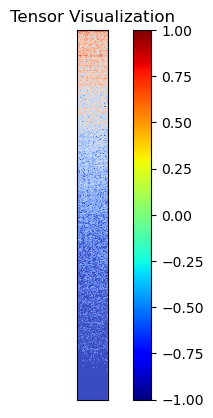

In [4]:
i = 40000
tensor = train_dataset[i][0][0]
plt.imshow(tensor, cmap='jet')
plt.title('Tensor Visualization')
plt.colorbar()

librosa.display.specshow(train_dataset[i][0][0].numpy())
plt.show()

In [22]:
# CNN Med 1lrk & LNN large (102,696,189 parameters)
class Ensemble(nn.Module):
    def __init__(self, CNN, LNN):
        super().__init__()
        self.cnn = CNN
        self.lnn = LNN
        self.classifier = nn.Linear(2, 1)

    def forward(self, spectrograms, features):
        spectrogram_preds = self.cnn(spectrograms)
        feature_preds = self.lnn(features)
        combined_preds = torch.stack((spectrogram_preds, feature_preds), dim=1)
        
        preds = self.classifier(combined_preds).squeeze(dim=1)
        return preds

# Run 4 medium model with one layer rectangular kernels (55,591,673 parameters)
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=(2, 1)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d((10, 5), stride=(2, 1)),
            
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

# Run 2 larger model (47,104,513 parameters)
class LNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits


In [35]:
# CNN Med 1lrk & LNN large with intermediate classifiation layer (102,696,251 parameters)
class Ensemble(nn.Module):
    def __init__(self, CNN, LNN):
        super().__init__()
        self.cnn = CNN
        self.lnn = LNN
        self.intermediary = nn.Linear(2, 16)
        self.classifier = nn.Linear(16, 1)

    def forward(self, spectrograms, features):
        spectrogram_preds = self.cnn(spectrograms)
        feature_preds = self.lnn(features)
        combined_preds = torch.stack((spectrogram_preds, feature_preds), dim=1)
        
        pred_features = self.intermediary(combined_preds)
        preds = self.classifier(pred_features).squeeze(dim=1)
        return preds

# Run 4 medium model with one layer rectangular kernels (55,591,673 parameters)
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=(2, 1)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d((10, 5), stride=(2, 1)),
            
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

# Run 2 larger model (47,104,513 parameters)
class LNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits


In [6]:
def split_seconds(seconds):
    minutes = seconds // 60
    hours = minutes // 60
    days = hours // 24
    return seconds % 60, minutes % 60, hours % 24, days


In [15]:
def main():
    # Define model
    convolutional = CNN()
    conv_state = torch.load("/home/distasiom/Documents/Summer2024/models/dnd_spectrogram_classifier_medium_1lrk/epoch_8.pt")
    convolutional.load_state_dict(conv_state)
    for param in convolutional.parameters():
        param.requires_grad = False
    linear = LNN()
    lin_state = torch.load("/home/distasiom/Documents/Summer2024/models/dnd_mfcc_classifier_large/epoch_54.pt")
    linear.load_state_dict(lin_state)
    for param in linear.parameters():
        param.requires_grad = False
    model = Ensemble(convolutional, linear)

    # Cuda setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    
    # Define models
    model = model.to(device)
   
    print(f"Using device: {device}")
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-4)
   
    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
   
    # Number of epochs
    num_epochs = 64
   
    # Train or load model?
    print("Training model....")
    start = time.time()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        
        model.train()
        for batch_idx, (spectrograms, features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
            optimizer.zero_grad()
           
            # Ensemble forward pass
            logits = model(spectrograms, features)
            loss = loss_fn(logits, labels.to(float))
            loss.backward()
            optimizer.step()

        model.eval()
        num_test = 0
        num_correct = 0
        total_loss = 0
        with torch.no_grad():
            for spectrograms, features, labels in tqdm(test_loader, desc="Testing", leave=False):
                spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
                logits = model(spectrograms, features)
                loss = loss_fn(logits, labels.to(float))
                total_loss += loss.item()
                preds = torch.round(torch.sigmoid(logits))
                num_test += labels.size(0)
                num_correct += preds.eq(labels).sum().item()
    
        tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")

        torch.save(model.state_dict(), f"/home/distasiom/Documents/Summer2024/models/dnd_ensemble_classifier/epoch_{str(epoch)}.pt")
   
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Training Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")
   
    # Evaluate model on validation data
    model.eval()
    print("Evaluating model....")
    start = time.time()
    total_loss = 0
    num_test = 0
    num_correct = 0
   
    with torch.no_grad():
        for spectrograms, features, labels in tqdm(val_loader, desc="Validating"):
            spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
            logits = model(spectrograms, features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()
   
    print(f"Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Testing Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")

In [16]:
main()

Using device: cuda
Training model....


Epochs:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/64, Test accuracy: 95.35, Total loss: 21.884193416257837


Epoch 2/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/64, Test accuracy: 95.57, Total loss: 15.891667680782295


Epoch 3/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/64, Test accuracy: 96.05, Total loss: 13.662390579914938


Epoch 4/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/64, Test accuracy: 96.27, Total loss: 12.644858053585446


Epoch 5/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/64, Test accuracy: 96.39, Total loss: 12.055158920907393


Epoch 6/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/64, Test accuracy: 96.55, Total loss: 11.587881009049697


Epoch 7/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/64, Test accuracy: 96.82, Total loss: 11.127068214805465


Epoch 8/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/64, Test accuracy: 96.92, Total loss: 10.918490838349305


Epoch 9/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/64, Test accuracy: 96.90, Total loss: 10.907565473157074


Epoch 10/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/64, Test accuracy: 96.98, Total loss: 10.77853069423213


Epoch 11/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 11/64, Test accuracy: 97.05, Total loss: 10.717197144895104


Epoch 12/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 12/64, Test accuracy: 97.06, Total loss: 10.643210290167136


Epoch 13/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 13/64, Test accuracy: 97.06, Total loss: 10.557714854606495


Epoch 14/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 14/64, Test accuracy: 97.00, Total loss: 10.58240986636791


Epoch 15/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 15/64, Test accuracy: 97.04, Total loss: 10.677975609949685


Epoch 16/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 16/64, Test accuracy: 97.04, Total loss: 10.583173563988398


Epoch 17/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 17/64, Test accuracy: 97.03, Total loss: 10.665859325207505


Epoch 18/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 18/64, Test accuracy: 97.02, Total loss: 10.705771061757615


Epoch 19/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 19/64, Test accuracy: 97.06, Total loss: 10.597919359449694


Epoch 20/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 20/64, Test accuracy: 97.04, Total loss: 10.614110366169466


Epoch 21/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 21/64, Test accuracy: 97.05, Total loss: 10.548552515098612


Epoch 22/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 22/64, Test accuracy: 97.07, Total loss: 10.621489727654094


Epoch 23/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 23/64, Test accuracy: 97.04, Total loss: 10.550415985489375


Epoch 24/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 24/64, Test accuracy: 97.06, Total loss: 10.609249151883192


Epoch 25/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 25/64, Test accuracy: 97.01, Total loss: 10.627166654739023


Epoch 26/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 26/64, Test accuracy: 97.09, Total loss: 10.664865788807846


Epoch 27/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 27/64, Test accuracy: 97.04, Total loss: 10.583492040941135


Epoch 28/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 28/64, Test accuracy: 97.05, Total loss: 10.680817520269132


Epoch 29/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 29/64, Test accuracy: 97.11, Total loss: 10.634088428469335


Epoch 30/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 30/64, Test accuracy: 97.07, Total loss: 10.601336433141823


Epoch 31/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 31/64, Test accuracy: 97.05, Total loss: 10.627682367759393


Epoch 32/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 32/64, Test accuracy: 97.07, Total loss: 10.603148273327855


Epoch 33/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 33/64, Test accuracy: 97.03, Total loss: 10.579152612250219


Epoch 34/64:   0%|          | 0/866 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
# Print number of parameters
conv = CNN()
lin = LNN()
model = Ensemble(conv, lin)
state = torch.load("/home/distasiom/Documents/Summer2024/models/dnd_ensemble_classifier/epoch_0.pt")
model.load_state_dict(state)
total_params = sum([torch.numel(p) for p in model.parameters()])
print(f"Total parameters: {total_params}")

Total parameters: 102696251


In [19]:
# Define model
convolutional = CNN()
linear = LNN()
model = Ensemble(convolutional, linear)

# Cuda setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)

print(f"Using device: {device}")

directory = "/home/distasiom/Documents/Summer2024/models/dnd_ensemble_classifier"
acc_epoch = None
max_acc = 0
loss_epoch = None
min_loss = float('inf')

for file in tqdm(os.listdir(directory), desc="Processing files"):
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")

    # Load model
    filepath = os.path.join(directory, file)
    state = torch.load(filepath)
    model.load_state_dict(state)

    # Evaluate model on validation data
    model.eval()
    total_loss = 0
    num_test = 0
    num_correct = 0

    with torch.no_grad():
        for spectrograms, features, labels in tqdm(val_loader, desc=f"Validating {file}", leave=False):
            spectrograms, features, labels = spectrograms.to(device), features.to(device), labels.to(device)
            logits = model(spectrograms, features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()

    accuracy = num_correct / num_test * 100
    if accuracy > max_acc:
        max_acc = accuracy
        acc_epoch = file
    if total_loss < min_loss:
        min_loss = total_loss
        loss_epoch = file

    print(f"{file}|| Test accuracy: {accuracy:.2f}, Total loss: {total_loss}")

print(f"Best accuracy: {max_acc} at {acc_epoch}")
print(f"Best loss: {min_loss} at {loss_epoch}")

Using device: cuda


Processing files:   0%|          | 0/33 [00:00<?, ?it/s]

Validating epoch_0.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_0.pt|| Test accuracy: 96.39, Total loss: 6.826291881521944


Validating epoch_1.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_1.pt|| Test accuracy: 96.74, Total loss: 4.72988009402986


Validating epoch_2.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_2.pt|| Test accuracy: 96.88, Total loss: 3.9948288609749136


Validating epoch_3.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_3.pt|| Test accuracy: 97.08, Total loss: 3.676218190449865


Validating epoch_4.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_4.pt|| Test accuracy: 97.11, Total loss: 3.4695354344101395


Validating epoch_5.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_5.pt|| Test accuracy: 97.26, Total loss: 3.3156085260544823


Validating epoch_6.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_6.pt|| Test accuracy: 97.26, Total loss: 3.2287771613964753


Validating epoch_7.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_7.pt|| Test accuracy: 97.23, Total loss: 3.1565663168172127


Validating epoch_8.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_8.pt|| Test accuracy: 97.31, Total loss: 3.1158472548765


Validating epoch_9.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_9.pt|| Test accuracy: 97.37, Total loss: 3.0982570309556556


Validating epoch_10.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_10.pt|| Test accuracy: 97.29, Total loss: 3.0814357589437904


Validating epoch_11.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_11.pt|| Test accuracy: 97.26, Total loss: 3.0711587506629505


Validating epoch_12.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_12.pt|| Test accuracy: 97.31, Total loss: 3.0692172927112513


Validating epoch_13.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_13.pt|| Test accuracy: 97.31, Total loss: 3.1170173299343213


Validating epoch_14.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_14.pt|| Test accuracy: 97.17, Total loss: 3.097724305943519


Validating epoch_15.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_15.pt|| Test accuracy: 97.23, Total loss: 3.156707052666532


Validating epoch_16.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_16.pt|| Test accuracy: 97.26, Total loss: 3.1354559427382953


Validating epoch_17.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_17.pt|| Test accuracy: 97.11, Total loss: 3.1504799588760974


Validating epoch_18.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_18.pt|| Test accuracy: 97.26, Total loss: 3.128259617431163


Validating epoch_19.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_19.pt|| Test accuracy: 97.26, Total loss: 3.1087226805207067


Validating epoch_20.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_20.pt|| Test accuracy: 97.26, Total loss: 3.0847972906193957


Validating epoch_21.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_21.pt|| Test accuracy: 97.17, Total loss: 3.1341405118796226


Validating epoch_22.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_22.pt|| Test accuracy: 97.29, Total loss: 3.0432635562093604


Validating epoch_23.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_23.pt|| Test accuracy: 97.26, Total loss: 3.0997665351789894


Validating epoch_24.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_24.pt|| Test accuracy: 97.31, Total loss: 3.100704280169323


Validating epoch_25.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_25.pt|| Test accuracy: 97.17, Total loss: 3.1494090667849353


Validating epoch_26.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_26.pt|| Test accuracy: 97.17, Total loss: 3.0886974374288165


Validating epoch_27.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_27.pt|| Test accuracy: 97.17, Total loss: 3.1266771368029844


Validating epoch_28.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_28.pt|| Test accuracy: 97.17, Total loss: 3.1196381724326256


Validating epoch_29.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_29.pt|| Test accuracy: 97.14, Total loss: 3.0936472419534993


Validating epoch_30.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_30.pt|| Test accuracy: 97.23, Total loss: 3.099420297169534


Validating epoch_31.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_31.pt|| Test accuracy: 97.20, Total loss: 3.128813499420167


Validating epoch_32.pt:   0%|          | 0/55 [00:00<?, ?it/s]

epoch_32.pt|| Test accuracy: 97.17, Total loss: 3.0992728522437
Best accuracy: 97.3722206179613 at epoch_9.pt
Best loss: 3.0432635562093604 at epoch_22.pt


# Medium 1lrk Spec & Large MFCC

Best accuracy: 97.40109731446722 at epoch_9.pt with loss 3.222888759185587

Best loss: 3.0430135516705383 at epoch_49.pt with accuracy 97.34

Also: epoch 47 (97.37, 3.069) epoch 31 (97.34, 3.0597) epoch 14 (97.37, 3.115) epoch 12 (97.34, 3.09299)

# Same with additional classification layer

Best accuracy: 97.3722206179613 at epoch_9.pt with loss 3.0982570309556556

Best loss: 3.0432635562093604 at epoch_22.pt with accuracy 97.29

Also: epoch 24 (97.31, 3.1007) epoch 12 (97.31, 3.0692)

In [36]:
# Define model
convolutional = CNN()
linear = LNN()
model = Ensemble(convolutional, linear)

# Cuda setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)
print(f"Using device: {device}")

# Load model
# state = torch.load("/home/distasiom/Documents/Summer2024/models/dnd_ensemble_classifier_1lrk_large/epoch_12.pt")
state = torch.load("/home/distasiom/Documents/Summer2024/models/dnd_ensemble_classifier_intermediary/epoch_12.pt")
model.load_state_dict(state)

# Value tracking
labels = torch.tensor([]).to(device)
files = tuple()
confidence = torch.tensor([]).to(device)

# Predict on validation data with model
model.eval()
with torch.no_grad():
    for filenames, spectrograms, features in tqdm(escape_loader, desc="Labeling"):
        spectrograms, features = spectrograms.to(device), features.to(device)
        logits = model(spectrograms, features)
        conf = torch.sigmoid(logits)
        preds = torch.round(conf)
        labels = torch.cat((labels, preds), dim=0)
        files += filenames
        confidence = torch.cat((confidence, conf), dim=0)

# Set up Dataframe for output csv
df = pd.DataFrame({
        'Filename': files,
        'Label': labels.to('cpu'),
        'Confidence': confidence.to('cpu')
    })
output_csv = "/home/distasiom/Documents/Summer2024/data/ESCAPEII_DADS_only_labels.csv"
df.to_csv(output_csv, index=False)


Using device: cuda


Labeling:   0%|          | 0/322 [00:00<?, ?it/s]

In [42]:
# Load your CSV file
csv = "/home/distasiom/Documents/Summer2024/data/ESCAPEII_DADS_only_labels_intermediary.csv"
df = pd.read_csv(csv)

# Function to extract the filename part and chunk number
def extract_filename_parts(filepath):
    # Extract the part before chunk
    filename_part = re.search(r'([^\\]+)(?=_chunk\d+)', filepath).group(1)
    # Extract the chunk number
    chunk_number = int(re.search(r'chunk(\d+)', filepath).group(1))
    return (filename_part, chunk_number)

# Apply the extraction function to create nuew columns
df[['Filename_Part', 'Chunk_Number']] = df['Filename'].apply(extract_filename_parts).apply(pd.Series)

# Sort the DataFrame based on the new columns
df_sorted = df.sort_values(by=['Filename_Part', 'Chunk_Number'])

# Drop the extra columns if no longer needed
df_sorted = df_sorted.drop(columns=['Filename_Part', 'Chunk_Number'])

# Save the sorted DataFrame to a new CSV file
df_sorted.to_csv(csv)

In [26]:
orig = pd.read_csv('/home/distasiom/Documents/Summer2024/data/ESCAPEII_DADS_only.csv')
filtDf = df[df['Label'] == 0]
filtDf.to_csv('/home/distasiom/Documents/Summer2024/data/ESCAPEII_DADS_only_drone_labels.csv')